In [ ]:
%%html
<style>
# div.prompt_container {width: 10%}
# div.prompt_container > div.prompt.input_prompt {font-size: 3px; 
#                                                 text-align: left;
#                                                 white-space: normal}
# div.prompt {min-width: 0px}
div.container#notebook-container {width: 1000px}
</style>

# Import stuff

In [1]:
%load_ext line_profiler
# %matplotlib widget
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from main_dycause_mp_new import *
from main_effcause import effcause_causal_discover
from effcause_lib.causal_graph_build import get_segment_split
from effcause_lib.causal_graph_build import get_bidirect_intervals

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocessing import Pool, RLock, freeze_support

import time
import datetime
import pandas as pd
import os
import numpy as np
import random
import networkx as nx
from sklearn import metrics as skmetrics
import pickle
# --- PCMCI ---
import tigramite.data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# plt.style.use('default')

freeze_support()  # for Windows support
tqdm.set_lock(RLock())  # for managing output contention

# Numerical Problems
DyCause optimization on IBM Microservice data 1->25 may have numerical problems. 
The interval of [0, 120] should pass the Granger causality test but not passes in DyCause optimization algorithm.
The problem is because that many data samples are constant during this interval, and the test is not reliable anymore.

**Important: Choose a data or an interval that is not constant.**

# Datasets
## IBM data

In [33]:
data_source = "ibm_micro_service"
# data_source = "pymicro"
aggre_delta = 1
verbose = 2

data, data_head = load_data(
    os.path.join("data", data_source, "rawdata.xlsx"),
    normalize=True,
    zero_fill_method="prevlatter",
    aggre_delta=aggre_delta,
    verbose=verbose,
)
df = pd.DataFrame(data, columns=data_head)
df

          Zero fill method              : Previous then latter
          Data header                   :
              1( 304 0s):ace-events-production-20160819-142035.ng.bluemix.net/socket.io/;GET
              2(2866 0s):api.xforce.ibmcloud.com/taxii;POST
              3(6743 0s):ace-appdetails-test-20160819-141650.ng.bluemix.net/apps/api/model;GET
              4(4970 0s):ace-dashboard-test-20160819-141650.ng.bluemix.net/dashboard/api/cf-apps-info;GET
              5( 574 0s):api.xforce.ibmcloud.com/socket.io/;GET
              6(5419 0s):ace-events-test-20160819-141650.ng.bluemix.net/events/cfServices;GET
              7(   0 0s):api.ng.bluemix.net/v2/app;PUT
              8(1064 0s):api.xforce.ibmcloud.com/casefiles/shared;GET
              9(4253 0s):ace-abstraction-test-20160819-141650.ng.bluemix.net/model/v1/dashboard;GET
             10(5799 0s):ace-appdetails-test-20160819-141650.ng.bluemix.net/socket.io/;GET
             11(5388 0s):ace-dashboard-test-20160819-141650.ng.blue

,ace-events-production-20160819-142035.ng.bluemix.net/socket.io/;GET,api.xforce.ibmcloud.com/taxii;POST,ace-appdetails-test-20160819-141650.ng.bluemix.net/apps/api/model;GET,ace-dashboard-test-20160819-141650.ng.bluemix.net/dashboard/api/cf-apps-info;GET,api.xforce.ibmcloud.com/socket.io/;GET,ace-events-test-20160819-141650.ng.bluemix.net/events/cfServices;GET,api.ng.bluemix.net/v2/app;PUT,api.xforce.ibmcloud.com/casefiles/shared;GET,ace-abstraction-test-20160819-141650.ng.bluemix.net/model/v1/dashboard;GET,ace-appdetails-test-20160819-141650.ng.bluemix.net/socket.io/;GET,...,new-console.ng.bluemix.net/events/;GET,new-console.ng.bluemix.net/dashboard/api/services-info;GET,ace-dashboard-test-20160819-141650.ng.bluemix.net/dashboard/api/action;GET,natural-language-classifier-toolkit.ng.bluemix.net/socket.io/;GET,ace-events-test-20160819-141650.ng.bluemix.net/events/;GET,ace-dashboard-production-20160819-142035.ng.bluemix.net/socket.io/;GET,ace-events-test-20160819-141650.ng.bluemix.net/events/cfServices/tags;GET,ace-events-test-20160819-141650.ng.bluemix.net/events/cfApps;GET,ibmwatson-rr-wsapi-prod.ng.bluemix.net/primus/;GET,ace-events-test-20160819-141650.ng.bluemix.net/socket.io/;GET
0,0.185536,-0.040922,-0.560660,-0.209866,-0.135201,-0.460862,-0.010821,-0.052927,-0.395324,-0.183134,...,-0.540941,-0.243833,-0.598429,-0.150932,-0.472836,-0.115019,-0.467312,-0.462348,-0.112582,-0.320729
1,-0.118311,-0.001586,-0.560660,-0.209866,-0.130923,-0.460862,-0.004869,-0.052927,-0.395324,-0.183134,...,-0.539783,-0.243833,-0.598429,-0.150932,-0.472911,-0.106948,-0.467312,-0.462348,-0.112582,-0.293026
2,-0.098587,-0.020443,-0.560660,-0.209866,-0.134173,-0.460862,-0.006567,-0.052884,-0.395324,-0.183134,...,-0.539783,-0.243833,-0.598429,-0.150932,-0.472911,-0.087143,-0.467312,-0.462348,-0.150615,-0.216618
3,-0.112067,-0.047016,-0.560660,-0.209866,-0.135774,-0.460862,-0.020377,-0.043539,-0.395324,-0.183134,...,-0.538953,-0.243833,-0.598429,-0.150932,-0.472871,-0.087143,-0.464388,-0.462348,-0.150615,-0.314675
4,-0.117871,-0.021808,-0.560660,-0.209866,-0.135780,-0.460862,0.006830,-0.047577,-0.395324,-0.183134,...,-0.538953,-0.243833,-0.598429,-0.150932,-0.472871,-0.087143,-0.463599,-0.462348,-0.222566,-0.086910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,-0.110788,-0.062566,1.774126,-0.214607,-0.135782,1.372551,0.015158,-0.039248,0.466897,-0.144252,...,2.051730,-0.211532,-0.301083,-0.149633,1.400999,-0.113538,1.298333,1.409046,-0.084724,0.028697
7195,-0.115334,-0.062566,1.774126,-0.214607,-0.133252,-0.222658,-0.010319,-0.052697,-0.211446,-0.144252,...,2.051730,-0.211532,-0.301083,-0.149633,1.400999,-0.113538,1.548905,-0.234808,-0.084724,0.028697
7196,-0.112447,-0.062566,1.775494,-0.214607,-0.135786,1.408775,0.000432,-0.025699,1.408849,-0.144252,...,2.051730,-0.211532,-0.301083,-0.149753,1.400999,-0.113538,1.318856,1.287242,-0.084724,0.028697
7197,-0.115656,-0.065284,1.775494,-0.214607,-0.135777,1.408775,-0.001709,-0.025699,1.408849,-0.144252,...,2.021795,-0.211532,-0.301083,-0.149753,1.404192,-0.087190,1.325389,1.287242,-0.084724,0.028697


## Simulation Datasets 1
From paper "AJCAI’15-Luo-Discovering Causal Structures from Time Series Data via Enhanced Granger Causality".
> This datasets are two simple (too few variables). The PC and PCMCI algorithms also complete fast.

![Simulaton Structure](imgs/1.png)

In [ ]:
gt_graph = nx.DiGraph()
gt_graph.add_nodes_from(range(5))
gt_graph.add_edges_from([(0,1), (0,2),(0,3),(3,4),(4,3)])
plt.figure(figsize=[3,3])
nx.draw(gt_graph, with_labels=True, pos=nx.drawing.layout.circular_layout(gt_graph))

In [ ]:
gt_graph = nx.DiGraph()
gt_graph.add_nodes_from(range(5))
gt_graph.add_edges_from([(0,0),(0,1), (0,2),(0,3),(3,3),(3,4),(4,3),(4,4)])
def simple_graph_plot(g):
    plt.figure(figsize=[3,3])
    nx.draw(g, with_labels=True, pos=nx.drawing.layout.circular_layout(g))
    plt.show()
simple_graph_plot(gt_graph)

In [ ]:
np.random.seed(42)
random.seed(42)
# We need to generate some initial samples for the later samples.
# So the length is a litter larger. The added samples are skipped later.
T = 2000 + 3
num_datasets = 50
datasets = []
for i in range(num_datasets):
    data = np.random.normal(0, 1, size=[T, 5])
    new_data = np.zeros_like(data)

    def get_data(d, t, i):
        if t<0:
            return 0
        return d[t, i]

    # X_t^{1,2,3}
    new_data[:, 0] = data[:, 0] + np.concatenate([np.zeros([1]), data[:-1, 0]]) * 0.95 * np.sqrt(2) - 0.9025 * np.concatenate([np.zeros([2]), data[:-2, 0]])
    new_data[:, 1] = data[:, 1] + 0.5 * np.concatenate([np.zeros([2]), data[:-2, 0]])
    new_data[:, 2] = data[:, 2] - 0.4 * np.concatenate([np.zeros([3]), data[:-3, 0]])

    for t in range(T):
        new_data[t, 3] = get_data(data, t, 3) - 0.5 * get_data(data, t-2, 0) + 0.25 * np.sqrt(2) * get_data(data, t-1, 3) + 0.25 * np.sqrt(2) * get_data(new_data, t-1, 4)
        new_data[t, 4] = get_data(data, t, 4) - 0.25 * np.sqrt(2) * get_data(new_data, t-1, 3) + 0.25 * np.sqrt(2) * get_data(data, t-1, 4)
    # Skip the first 3 samples because they are not complete correct.
    datasets.append(new_data[3:])
os.makedirs(os.path.join("data", "simulation"), exist_ok=True)
with open(os.path.join("data", "simulation", "datasets50.pkl"), "wb") as f:
    pickle.dump(datasets, f)

In [ ]:
with open(os.path.join("data", "simulation", "datasets50.pkl"), "rb") as f:
    datasets = pickle.load(f)

In [ ]:
plt.figure(figsize=[10, 4])
plt.plot(datasets[0])
pass

## Simulation Datasets 2
Try to simulate with larger number of variables and dynamic cause effect strength.

In [ ]:
from tigramite.data_processing import var_process

## TCDF Datasets
From paper "MAKE'21-Nauta-TCDF".

> TCDF extends the delayed cause-effect pairs to all indirect paths with at most 2 steps. Whether we should consider this extend ?

> This data contains some self edges. In Granger causality test this is not usually tested, should we **exclude those edges** or extend Granger to discover self edges ?


1. Finance datasets.
2. FMRI datasets.

![Datasets Summary](imgs/2.png)

Finance datasets (Current best scores):

| Method | Avg.Prec | Avg.Recall | Avg.F1 | Time (s) |
| :-: | :-: | :-: | :-: | :-: | 
| TCDF    | 38.57 | 27.59 | 31.76 | 211.67(approx) |
| Granger  |
| DyCause  |
| EffCause | 13.91 | 26.19 | 16.67 | 745.30 |
| PCMCI   |  3.54 | 46.66 |  6.53 |  61.40 |
| FullCI  |
| Lasso   |

FMRI datasets (Current Best Scores):

| Method | Avg.Prec | Avg.Recall | Avg.F1 | Time (s) |
| :-: | :-: | :-: | :-: | :-: | 
| TCDF    |  |  |  |  |
| Granger  |
| DyCause  |
| EffCause |  | 
| PCMCI   |
| FullCI  |
| Lasso |

Redesign the adaptive thresholding algorithm for better causal discovery. In the new algorithm, we focus on the causal strength of individual edges which is represented by the dynamic causality curves. Then we use a aggregation function to transform those curves to the decision values and decide whether there are causalities. By this way, we can also use `sklearn.metrics` package to calculate the Precision-Recall Curve and related metrics.

Finance datasets

> Methods: TCDF, PCMCI, DyCause, EffCause.

> Metrics: Avg.Prec, Avg.Recall, Avg.F1, Time (s)

- Finance
  - Basic Granger
    - 4.11%, 68.96%, 7.52%, 16.71s (auc:16.36%, ap:3.75%, sklearn metrics)
    - 4.79%, 96.32%, 9.06%, 16.55s (tpr:96.32%, fpr:69.51%, our metrics)
  - Dynamic Granger (Same as DyCause except for time)
    - 66.67%, 59.49%, 57.70%, 2203.87s (Avg.auc: 52.98%, Avg.ap: 52.83%, sklearn metrics)
  - TCDF
    - 42.70%, 34.07%, 37.24%, 93.83s (TCDF own evaluation function)
    - 47.71%, 54.09%, 38.65%, 93.83s (auc:34.59%, ap:25.57%, TCDF own graph with sklearn metrics)
  - DyCause (Orignal Work, Granger causal interval's.)
    - 48.04%, 34.00%, 21.18%, 2108.67s (auc:14.80%, ap:15.06%, sklearn metrics) 
    - 14.24%, 75.03%, 17.18%, 1763.74s (tpr: 75.03%, fpr: 51.52%, our metrics) 
  - DyCause (Bidirectional adjustment)
    - 66.67%, 59.49%, 57.70%, 1437.54s (Avg.auc: 52.98%, Avg.ap: 52.83%, sklearn metrics)
    - 31.99%, 97.18%, 38.47%, 1002.94s (tpr:97.18%, fpr:82.16%, our metrics)
  - PCMCI
    - 59.87%, 50.74%, 49.69%, 71.87s (auc:40.95%, ap:37.19%, sklearn metrics with the PCMCI graph)
  - EffCause (reuse_invdirection=False)
    - 22.08%, 78.31%, 30.03%, 549.36s (auc:34.73%, ap:18.97%, sklearn metrics)
  - EffCause (Bidirectional opt, Yifan Zhang's work.)
    - 19.84%, 28.80%, 20.61%, 313.04s (Avg.auc: 0.13355, Avg.ap: 0.09398)
    - 13.18%, 30.74%, 17.51%, 247.49s (tpr:30.74%, fpr:8.73%, our metrics)
  - EffCause (Bidirectional adjustment, reuse_invdirection=True, Bug fixed, rolling_method='pyc')
    - 66.67%, 59.49%, 57.70%, 1028.46s (Avg.auc: 52.98%, Avg.ap: 52.83%, `exp_rets_20210916_064047.pkl`, sklearn metrics)
  - EffCause (Bidirectional adjustment, reuse_invdirection=True, Bug fixed)
    - 66.67%, 59.49%, 57.70%, 1734.88s (Avg.auc: 52.98%, Avg.ap: 52.83%, `exp_rets_20210915_080724.pkl`, sklearn metrics)  
    
    

    
- FMRI>1000
  - Basic Granger
    - 44.60%, 84.24%, 57.66%, 0.68s (auc:65.81%, ap:41.74%, `exp_rets_20211011_145829.pkl`, bidirectional adjustment)
  - TCDF
    - 46.84%, 66.06%, 46.39%, 13.38s (auc:48.76%, ap:35.90%, `exp_records_sign0.9_20211011_115543.pkl`)
  - DyCause (bidirectional adjustment)
    - 54.12%, 82.12%, 64.57%, 57.99s (auc:42.15%, ap:47.03%, sklearn metrics, `exp_rets_20211011_105347.pkl`, sklearn metrics)
  - PCMCI
    - 66.14%, 80.30%, 72.30%, 2.15s (auc:53.36%, ap:56.76%, `exp_rets_20211011_192809.pkl`)
  - EffCause (Bidirectional adjustment, reuse_invdirection=True, Bug fixed)
    - 56.62%, 82.12%, 65.68%, 18.43s (Avg.auc: 40.51%, Avg.ap: 47.11%, `exp_rets_20211011_095427.pkl`, sklearn metrics)

In [ ]:
1437.54 / 60

In [47]:
from utility_funcs.proc_data import load_tcdf_data

datasets, gt_graphs = load_tcdf_data(dir="finance")

datasets_, gt_graphs_ = [], []
for i in range(len(datasets)):
    if datasets[i].shape[0]>1000:
        datasets_.append(datasets[i])
        gt_graphs_.append(gt_graphs[i])
datasets, gt_graphs = datasets_, gt_graphs_

In [23]:
[d.shape for d in datasets]

[(1200, 5), (1200, 10), (5000, 5), (5000, 5), (2400, 5), (2400, 5)]

In [ ]:
for g in gt_graphs:
    for e in g.edges:
        print(g.edges[e], end=',')
    print()

In [ ]:
for idx, g in enumerate(gt_graphs):
    for i in g.nodes:
        for j in g.nodes:
            if (i,j) in g.edges and (j, i) in g.edges:
                print("Double directed edges ({} <--> {}) in graph {}".format(i, j, idx))

In [ ]:
def plot_graph_simple(g, layout=nx.drawing.layout.circular_layout, figsize=[4,4]):
    plt.figure(figsize=figsize)
    nx.draw(g, with_labels=True, pos=layout(g))
    plt.show()

## Pair datasets

In [ ]:
from utility_funcs.proc_data import load_pairs_data
dfs, relations = load_pairs_data()

## TiMINo house dataset
This is the hourly measured temporature and humidity of 6 positions inside a house.

Column Names:
 * `Vorraum` 前厅，接待室 Living Room
 * `Aussen` 外部 Outside
 * `Spuele` Kitchen Boiler
 * `Innen` 棚 Shed
 * `WC` WC
 * `Bad` 浴室 Bathroom
 
Ground Truth:
* `Outside` causes all the others. And none causes `Outside`.
* `Shed` should not cause any one. It is only close and similar to the `Outsize`.
* `Living Room` does not cause any one but every one causes it because it has no heater.
* `WC` $\rightarrow$ `Kitchen Boiler` and `Bathroom` $\rightarrow$ `Kitchen Boiler` should not exist. But they might also be due to the fact that the sensor `Kitchen Boiler` is sitting on top of the kitchen boiler, which acts as a heat reservoir that delays temperature changes.
* `Bathroom` $\rightarrow$ `WC` probably exists since unlike the WC, the bathroom has a window and is thus affected directly by outside temperature, causing fast regulation of its radiator, which is placed on a thin wooden wall facing the WC.
 
1. Shed -> Living Room
2. Outside -> Shed, Kitchen Boiler, Living Room, WC, Bathroom
3. Kitchen Boiler -> Living Room
4. Living Room ->
5. WC -> Living Room
6. Bathroom -> Living Room, WC

**Test Exp Logs**
* `step=200, sign=1e-2, lag=50`, no normalized, save file: `temp_results/effcause/timino/exp_rets_20211111_172042.pkl`
* `step=200, sign=1e-2, lag=50, max_segment_len=1000`, no normalized, save file: `temp_results/effcause/timino/exp_rets_20211111_191533.pkl`

In [109]:
df = pd.read_csv(os.path.join("data", "timino_house_data", "2011-03-07bis2012-01-04.csv"))
print(df.columns)
# Filter only temporature
df = df.iloc[:, [0, 2,4,6,8,10]]
# Rename to English
df.columns = ["Living Room", "Outside", "Kitchen Boiler", "Shed", "WC", "Bathroom"]
df =df[["Shed", "Outside", "Kitchen Boiler", "Living Room", "WC", "Bathroom"]]
# Normalize
# data_mean = np.mean(df, axis=0)
# data_std = np.std(df, axis=0)
# df = (df - data_mean) / data_std
# select
# df = df[["Shed", "Outside"]]
df

Index(['VorraumT', 'VorraumH', 'AussenT', 'AussenH', 'SpueleT', 'SpueleH',
       'InnenT', 'InnenH', 'WCT', 'WCH', 'BadT', 'BadH'],
      dtype='object')


,Shed,Outside,Kitchen Boiler,Living Room,WC,Bathroom
0,16.5,3.5,15.5,6.5,16.0,14.0
1,16.5,2.0,14.5,4.5,15.5,14.0
2,16.5,1.0,13.5,4.0,15.0,13.5
3,17.0,-0.5,13.0,4.0,15.5,13.5
4,17.0,-1.0,13.0,4.0,16.5,14.0
...,...,...,...,...,...,...
7260,18.5,3.0,14.5,5.0,18.0,16.5
7261,18.0,2.5,14.5,5.0,17.5,16.0
7262,17.5,1.0,14.5,5.0,17.0,15.5
7263,17.0,0.5,14.0,5.0,17.0,15.5


In [ ]:
np.mean(df, axis=0)

In [ ]:
from effcause_lib.granger import get_lagged_data
ssrs = []
for lag in range(4, 500, 10):
#     lag = 20
    # Outside -> Shed
    dta, dtaown, dtajoint = get_lagged_data(df[["Shed", "Outside"]].to_numpy()[:, [1, 0]], lag, True, True)
    from statsmodels.regression.linear_model import OLS

    res2down = OLS(dta[:, 0], dtaown[:, :]).fit()
    res2djoint = OLS(dta[:, 0], dtajoint[:, :]).fit()

    pred_y = res2djoint.predict(dtajoint)
    ssr_1 = np.sum( (pred_y - dta[:, 0]) ** 2, axis=0)
    pred_y2 = res2down.predict(dtaown)
    ssr_2 = np.sum( (pred_y2 - dta[:, 0]) ** 2, axis=0)
    print("SSR_joint:", ssr_1)
    print("SSR_own:", ssr_2)
    
    ssrs.append((ssr_1, ssr_2))

In [ ]:
fig = plt.figure(figsize=[8, 3], dpi=300)
ax = fig.subplots(1, 1)
ax.plot(range(4, 500, 10), [i[0] for i in ssrs])
pass

In [ ]:
pred_y

In [ ]:
fig = plt.figure(figsize=[10, 6])
axs = fig.subplots(1, 1, sharex=True)
for i in [0, 1]:
    axs.plot(df.index, df[df.columns[i]], label=df.columns[i], alpha=0.8)
axs.plot(range(lag, df.shape[0]), pred_y, label="Prediction Joint Lag={}".format(lag), alpha=0.8)
axs.plot(range(lag, df.shape[0]), pred_y2, label="Prediction Own  Lag={}".format(lag), alpha=0.8)
axs.legend(loc='upper right')
# plt.savefig(os.path.join("data", "timino_house_data", "alldata.png"), dpi=300,
#            subplot_layout='tight')
axs.set_xlim(12, 12+100)
plt.show()

In [ ]:
fig = plt.figure(figsize=[10, 8], dpi=300)
axs = fig.subplots(6, 1, sharex=True)
for i in range(len(df.columns)):
    axs[i].plot(df.index, df[df.columns[i]], label=df.columns[i])
    axs[i].legend(loc='upper right')
# axs[-1].set_xlim(4000, 5000)
plt.savefig(os.path.join("data", "timino_house_data", "alldata.pdf"), dpi=300,
           subplot_layout='tight')
plt.show()

<IPython.core.display.Javascript object>


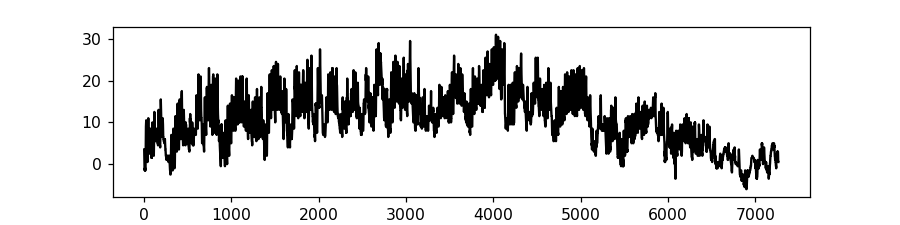

In [118]:
fig = plt.figure(figsize=[8, 2])
ax = fig.subplots(1, 1, sharex=True)

i=1
ax.plot(df.index, df[df.columns[i]], label=df.columns[i], color='k')
# ax.legend(loc='upper right')
# axs[-1].set_xlim(4000, 5000)
plt.savefig(os.path.join("data", "timino_house_data", f"alldata-{df.columns[i]}.png"), dpi=600,
           subplot_layout='tight')
plt.show()

## PEMS-bay

In [44]:
def get_weekly_pems_df(data_name):
    """
    Params:
        data_name: "pems-bay" or "metr-la"
    """
    df = pd.read_hdf("/workspace/DCRNN/data/{}.h5".format(data_name))
    print("Orignial dataframe shape:", df.shape)
    weekly_df = []
    s = df.index[0]
    while s <= df.index[-1]:
        e = s + pd.offsets.Week()
        # pandas in default includes the end point, so
        # we skip that data by using a second slide [::-1].
        # However, the last week data is not complete (not 7 days full),
        # so we don't need to skip the last.
        if e>df.index[-1]:
            weekly_df.append(df[s:e])
        else:
            weekly_df.append(df[s:e][:-1])
    #     print(df[s:e].shape)
    #     break
        s = e
    for i in weekly_df:
        print(i.shape, end=', ')
    print("Total data samples of weekly sliced dataframes:", sum([i.shape[0] for i in weekly_df]))
    return weekly_df

In [2]:
data = np.load("data/pems-bay/pems-bay.npy")
df = pd.DataFrame(data)
# print(df)

raw_df = pd.read_hdf("/workspace/DCRNN/data/pems-bay.h5")
raw_index = raw_df.index
# print(raw_df)

# Normalize
# data_mean = np.mean(df, axis=0)
# data_std = np.std(df, axis=0)
# df = (df - data_mean) / data_std

In [41]:
selected_cols = [248, 122, 247, 224, 80, 93]

In [17]:
print("Days:", df.shape[0] * 5  / 60 / 24)

Days: 180.95833333333334


In [ ]:
my_dpi=120
fig = plt.figure(figsize=[2560/my_dpi, 1440/my_dpi], dpi=my_dpi)
axs = fig.subplots(len(selected_cols), 1, sharex=True)
for i, col in enumerate(selected_cols):
    axs[i].plot(df.index, df.iloc[:, col], label=str(col))
    axs[i].legend(loc='upper right')
# axs[-1].set_xlim(0, 7 * 24 * 60 / 5)
plt.savefig(os.path.join("data", "pems-bay", "alldata.png"), dpi=my_dpi*5,
           subplot_layout='tight')
plt.show()

In [ ]:
raw_df = pd.read_hdf("/workspace/DCRNN/data/metr-la.h5")
raw_index = raw_df.index
# print(raw_df)
df = raw_df.copy()
df.columns = range(len(df.columns))
print(df)

# Normalize
# data_mean = np.mean(df, axis=0)
# data_std = np.std(df, axis=0)
# df = (df - data_mean) / data_std

In [45]:
weekly_df = get_weekly_pems_df("metr-la")

Orignial dataframe shape: (34272, 207)
(2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), (2016, 207), Total data samples of weekly sliced dataframes: 34272


# Methods

## Fix for Double Directed Causal Links
Granger causal intervals论文考虑的因果关系主要关注单向的，因此如果出现了双向（$x\rightarrow y,y\rightarrow x$）的情况，在其代码中需要特殊考虑。

需要修改的是从检验结果矩阵提取因果区间窗口的过程，之前提取因果区间窗口时沿用了论文中的思路，即：
> $x\rightarrow y$ 当且仅当检验结果中 $x\rightarrow y$ 成立而 $y\rightarrow x$ 不成立。

如果需要考虑双向的因果性，这是检验的结果很可能是$x\rightarrow y,y\rightarrow x$都成立，这时添加新的窗口。

In [62]:
from dycause_lib.causal_graph_build import get_segment_split, get_overlay_count
from effcause_lib.causal_graph_build import get_count

def build_intervals_bidirected(local_results, significant_thres, local_length, step, N, verbose=False):
    list_segment_split = get_segment_split(local_length, step)
    for x_i in range(N):
        for y_i in range(N):
            if x_i == y_i:
                continue
            key = "{}->{}".format(x_i, y_i)
#             print(key, local_results[key].keys())
            array_results_YX, array_results_XY = local_results[key]['result_YX'], local_results[key]['result_XY']
            array_results_YX = np.abs(array_results_YX)
            array_results_XY = np.abs(array_results_XY)
            nrows, ncols = array_results_YX.shape
            intervals = []
            pvalues = []
            for i in range(nrows):
                for j in range(i + 1, ncols):
                    if (abs(array_results_YX[i, j]) < significant_thres):
                        intervals.append((list_segment_split[i], list_segment_split[j]))
                        pvalues.append((array_results_YX[i, j], array_results_XY[i, j]))
#             if verbose:
#                 print(key, intervals)
            ordered_intervals = list(zip(pvalues, intervals))
            ordered_intervals.sort(key=lambda x: (x[0][0], -x[0][1]))
            local_results[key]['intervals_bidirected'] = ordered_intervals
            
            
def generate_DCC(local_results, T, N, interval_key="intervals", agg_func=None, 
                 verbose=False):
    """Generate dynamic causality curve (DCC) between two services by overlaying 
    intervals.
    
    Args:
        local_results: Causal discovery temp results.
        T: Data length in time dimension.
        N: Num of time series.
        interval_key: the intervals key in the local_results dict.
        agg_func: The aggregation function to merge intervals into dynamic 
            causality curves. Default is the sum aggregation function.
        verbose: whether print intermidiate information.
    """
    DCC = defaultdict(int)
    if agg_func is None:
        agg_func = get_overlay_count
    for x_i in range(N):
        for y_i in range(N):
            if y_i == x_i:
                continue
            key = f"{x_i}->{y_i}"
            intervals = local_results[key][interval_key]
#             from IPython.core.debugger import set_trace
#             set_trace() # 断点位置
            try:
                if len(intervals) != 0 and not isinstance(intervals[0][0], int):
    #                 print("not isinstance(intervals[0], int)", type(intervals[0]))
                    intervals = [_[1] for _ in intervals]
            except:
                from IPython.core.debugger import set_trace
                set_trace() # 断点位置
            if verbose:
                print(key, intervals)
            overlay_counts = agg_func(T, intervals)
            DCC[key] = overlay_counts
    return DCC

## Precision Recall Funcs

In [63]:
def granger_decision(dcc, g, N, agg_func=sum, self_edges=False):
    """Generate Granger decision values using agg_func.
    Params:
        dcc: the dynamic causality curves
        g: the ground truth graph
        N: the number of nodes
        agg_func: aggregation function that transform the dcc to a decision value.
        self_edges: whether include self edges.
    Returns:
        y:    the ground truth edge indication values.
        pred: the decision values of whether there are edges.
    """
    y = []
    pred = []
    for i in range(N):
        for j in range(N):
            if i!=j:
                pred.append(agg_func(dcc['{}->{}'.format(i, j)]))
                y.append((i, j) in g.edges)
            elif i==j and self_edges:
                # Consider self edges
                pred.append(agg_func(dcc['{}->{}'.format(i, j)]))
                y.append((i, j) in g.edges)
    return y, pred


def calc_pred(mat, gt_graph, N, self_edges=False, verbose=False):
    """Calculate the graph edge prediction classes.
    Params:
        self_edges: Whether includes the self edges. Default not including.
    """
    gt_es = gt_graph.edges()
    pred_es = []
    for i in range(N):
        for j in range(N):
            if i==j and not self_edges:
                continue
            if mat[i, j] > 0:
                pred_es.append((i, j))
    tp, fp, tn, fn = 0,0,0,0
    for i in range(N):
        for j in range(N):
            if i==j and not self_edges:
                continue
            e = (i, j)
            if e in pred_es:
                if e in gt_es:
                    tp += 1
                else:
                    fp += 1
            else:
                if e in gt_es:
                    fn += 1
                else:
                    tn += 1
    return tp, fp, tn, fn


def calc_f1(mat, gt_graph, N, self_edges=False, verbose=False):
    tp, fp, tn, fn = calc_pred(mat, gt_graph, N, self_edges=self_edges, verbose=verbose)
    if verbose:
        print(f"tp:{tp:>4d} fp:{fp:>4d} tn:{tn:>4d} fn:{fn:>4d}")
    try:
        prec = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2 * (prec * recall) / (prec+recall)
    except ZeroDivisionError as e:
        prec = 0
        recall = 0
        f1 = 0
    return prec, recall, f1


def calc_ap(metrics):
    """
    Params:
        op_opts: a list of dict which has "prec" and "recall" keys, could be unsorted.
    """
    op_pts = [(d['prec'], d['recall']) for d in metrics]
    op_pts.sort(key=lambda x:x[1])
    ap = 0
    for i in range(1, len(op_pts)):
        ap += op_pts[i][0] * (op_pts[i][1] - op_pts[i-1][1])
    return ap


from dycause_lib.causal_graph_build import adaptive_thresholding


def calc_pred_curve(dcc, gt_graph, N, verbose=False):
    metrics = []
    for thr in np.arange(0.1, 1.1, 0.1):
        mat = adaptive_thresholding(dcc, thr, N)
        tp, fp, tn, fn = calc_pred(mat, gt_graph, N)
        try:
            prec = tp/(tp+fp)
            tpr = recall = tp/(tp+fn)
            f1 = 2 * (prec * recall) / (prec+recall)
            fpr = fp/(fp+tn)
        except ZeroDivisionError as e:
            prec = 0
            tpr = recall = 0
            f1 = 0
            fpr = 0
        metrics.append({
            "thr": thr,
            "prec": prec,
            "recall": recall,
            "f1": f1,
            "tpr": tpr,
            "fpr": fpr
        })
        if verbose:
            print("thr:{:3.1f}".format(thr), end=', ')
            for k in ["prec", "recall", "f1", "tpr", "fpr"]:
                print("{}:{:7.2%}".format(k, metrics[-1][k]), end=', ')
            print()
    return metrics

## Evaluation functions

In [64]:
def append_dict(d, k, v):
    if k in d:
        d[k].append(v)
    else:
        d[k] = [v]

def basicgranger_causality_discover(d, N, bidirection=False):
    """
    Args:
        bidirection: boolean. Default is True. Whether use the new interval
                     extraction algorithm which includes double direction
                     intervals.
    """
#     T = d["T"]
    sign, lag, time_stat_dict = d["sign"], d["lag"], d["time_stat_dict"]
    if "local_result" in d:
        local_results = d["local_result"]
    elif "local_results" in d:
        local_results = d["local_results"]
    else:
        assert False, "error, no local_results in the exp record"
    dataset_id = d["dataset_id"]
    T = datasets[dataset_id].shape[0]
    if bidirection:
        build_intervals_bidirected(local_results, sign, T, T, N)
        dcc = generate_DCC(local_results, T, N, interval_key="intervals_bidirected")
    else:
        dcc = d["dcc"]
    y, pred = granger_decision(dcc, gt_graphs[dataset_id], N)
    return y, pred
        
        
def get_max_performance(exp_rets, datasets, causality_func, bidirection=False,
                        algo_params=["step", "sign", "lag"]):
    """Get the best performance of the experiments.
    We use the causality windows and dynamic causality curves to perform causal discovery.
    
    
    Params:
        exp_rets: a list of experiment logs. Each logs is a dict of algorithm parameters
                  and results.
        datasets: a list of datasets. Each dataset is a numpy array.
        causality_func: the function of causal discovery.
        bidirection: boolean. Default is True. Whether use the new interval
                     extraction algorithm which includes double direction
                     intervals.
        algo_params: a list of str. The algorithm's parameters such step, 
                     significance and etc. This will also be in the output dict.
    Returns:
        avg_metric: a dict of (dataset_id, metric_dict). metric_dict is a dict of 
                    (metric, value).
    """
    avg_metric = {}
    pbar = tqdm(total=len(exp_rets))
    for d in exp_rets:
        dataset_id = d["dataset_id"]
        time_stat_dict = d["time_stat_dict"]
        if dataset_id not in avg_metric:
            avg_metric[dataset_id] = {}
        N = datasets[dataset_id].shape[1]
        y, pred = causality_func(d, N, bidirection=bidirection)

        precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
        # calculate precision-recall AUC
        auc = skmetrics.auc(recall, precision)
        ap = skmetrics.average_precision_score(y, pred)

        f1 = 2 * recall * precision / (precision + recall)
        # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
        max_i = np.nanargmax(f1)
        assert max_i < len(precision), "The last precision and recall value is not from the data, should not be uesd!"

        for k, l in zip(['precision', 'recall', 'threshold', 'f1'], 
                         [precision, recall, thresholds, f1 ]):
            append_dict(avg_metric[dataset_id], k, l[max_i])
        
        append_dict(avg_metric[dataset_id], 'auc', auc)
        append_dict(avg_metric[dataset_id], 'ap', ap)
        append_dict(avg_metric[dataset_id], 'time', time_stat_dict['Construct-Impact-Graph-Phase'])
        # Record the algorithm parameters
        for k in algo_params:
            append_dict(avg_metric[dataset_id], k, d[k])
        pbar.update(1)
#         break
    pbar.close()
    return avg_metric

def eval_dataset_best(avg_metric, n, select_max_key = 'f1', 
                      metric_names=['precision', 'recall', 'f1', 'auc', 'ap', 'time']):
    """Find out the best performance for each dataset and store the results to 
    `dataset_avg_metric`. Also evaluate the overall performance.
    
    Params:
        avg_metric: A dict of performance per dataset. Results of function 
                    get_max_performance(...). Key is dataset id, Value is a dict of 
                    metric list.
        n: num of datasets.
        select_max_key: the key used to select the best causality discovery parameters.
                        Default is F1.
    Returns:
        dataset_avg_metric: a dict of (metric_name, values). The values are the best of the
                            corresponding dataset.
    """
    dataset_avg_metric = {}
    for i in range(n):
        # Not all selected metric are nans, we can always get a maximum skiping the nans.
        if not np.all(np.isnan(avg_metric[i][select_max_key])):
            # Set nans to 0.0 and argmax.
            a = np.array(avg_metric[i][select_max_key]).copy()
            a[np.isnan(a)] = 0
            idx = np.argmax(a)
            for key in metric_names:
                append_dict(dataset_avg_metric, key, avg_metric[i][key][idx])
            append_dict(dataset_avg_metric, 'idx', idx)
        # If all select_max_key is nans, meaning that f1 is nan, and all precision and recall is 0.0.
        #   For auc and ap, we use the maximum.
        else:
            for key in metric_names:
                if key in ['precision', 'recall']:
                    append_dict(dataset_avg_metric, key, 0.0)
                elif key == 'f1':
                    append_dict(dataset_avg_metric, key, np.nan)
                elif key in ['auc', 'ap']:
                    append_dict(dataset_avg_metric, key, np.max(avg_metric[i][key]))
                else:
                    append_dict(dataset_avg_metric, 'time', np.mean(avg_metric[i]['time']))
            append_dict(dataset_avg_metric, 'idx', np.nan)

    for key in metric_names:
        if not key=="time":
            a = np.mean(dataset_avg_metric[key])
            print("{}:{:.2%}".format(key, a), end=', ')
    print("{}:{:.2f}s".format("time", np.mean(dataset_avg_metric["time"])), end=', ')
    return dataset_avg_metric

## Basic Granger
Without dynamic windows. With multiprocess=3.

* Finance (sign=[0.005, 0.01, 0.05, 0.1], lag=3, save_file=`exp_rets_20210809_153957.pkl`, bidirection adjustment)
  * 4.11%, 68.96%, 7.52%, 16.71s (auc:16.36%, ap:3.75%, sklearn metrics)
  * 4.79%, 96.32%, 9.06%, 16.55s (tpr:96.32%, fpr:69.51%, our metrics)
  
* fMRI (sign=[0.005, 0.01, 0.05, 0.1], lag=3, save file=`exp_rets_20211011_145829.pkl`)
  * precision:44.60%, recall:84.24%, f1:57.66%, auc:65.81%, ap:41.74%, time:0.68s, bidirection adjustment
  * precision:38.15%, recall:83.33%, f1:43.07%, auc:36.24%, ap:31.04%, time:0.70s, no bidirection adjustment

In [ ]:
# Search through parameters and save results.
exp_rets = []
pbar = tqdm(total=len(datasets))
for i, data in enumerate(datasets):
    for T in range(4000, 5000, 1000):
        for sign in [0.005, 0.01, 0.05, 0.1]:
            for lag in [3]:
                local_results, dcc, mat, time_stat_dict = dycause_causal_discover(
                    # Data params
                    data.to_numpy()[0:T, :],
                    # Granger interval based graph construction params
                    step=T,
                    significant_thres=sign,
                    lag=lag,  # must satisfy: step > 3 * lag + 1
                    adaptive_threshold=0.7,
                    use_multiprocess=True,
                    max_workers=3,
                    opt_method="fast_version_3",
                    # Debug_params
                    verbose=False,
                    runtime_debug=True,
                )
                exp_rets.append((f"dataset{i}", T, sign, lag, local_results, time_stat_dict))
                print(time_stat_dict['Construct-Impact-Graph-Phase'])
                pbar.update(1)
pbar.close()

In [ ]:
# Search through parameters and save results for Root Cause Analysis in IBM dataset.
exp_rets = []
pbar = tqdm(total=3 ** 4)
for bef in [100, 200, 300]:
    for aft in [100, 200, 300]:
        for sign in [0.01, 0.05, 0.1]:
            for lag in [5, 10, 15]:
                local_results, dcc, mat, time_stat_dict = dycause_causal_discover(
                    # Data params
                    df.to_numpy()[4653-bef:4653+aft, :],
                    # Granger interval based graph construction params
                    step=bef+aft,
                    significant_thres=sign,
                    lag=lag,  # must satisfy: step > 3 * lag + 1
                    adaptive_threshold=0.7,
                    use_multiprocess=True,
                    max_workers=3,
                    opt_method="fast_version_3",
                    # Debug_params
                    verbose=True,
                    runtime_debug=True,
                )
                exp_rets.append({
                    'bef': bef,
                    'aft': aft,
                    'pivot_time': 4653,
                    "pc_alpha": sign, 
                    'tau_max': lag,
                    "mat": mat,
                    "time": time_stat_dict['Construct-Impact-Graph-Phase']
                })
                pbar.desc = "{:.2f} s".format(toc-tic)
                print(time_stat_dict['Construct-Impact-Graph-Phase'])
                pbar.update(1)
pbar.close()

In [42]:
# Use the timezone in my location.
local_tz = datetime.timezone(datetime.timedelta(hours=8))
time_str = datetime.datetime.now(local_tz).strftime("%Y%m%d_%H%M%S")
fname = os.path.join("temp_results", "basicgranger", "ibm_micro_service", f"exp_rets_{time_str}.pkl")
print(fname)
os.makedirs(os.path.dirname(fname), exist_ok=True)
with open(fname, "wb") as f:
    pickle.dump(exp_rets, f)

temp_results/basicgranger/ibm_micro_service/exp_rets_20211115_153930.pkl


In [9]:
fname = os.path.join("temp_results", "basicgranger", "tcdf_finance", "exp_rets_20210809_153957.pkl")
with open(fname, "rb") as f:
    exp_rets = pickle.load(f)

In [11]:
exp_rets[0].keys()

dict_keys(['dataset_id', 'step', 'sign', 'lag', 'local_results', 'dcc', 'time_stat_dict'])

## Dynamic Granger
With dynamic windows scheme, multiprocess=3. Without pruning, fit optimization. The performance of this method should be the same as DyCause. So we only measure the execution time here.

To be accurate, we first get the best algorithm parameters from DyCause experiments and use the same parameters here to measure time.

**Finance datasets[0]**
* step=100, time=3335.7242715358734
* step=200, time=972.2014448642731
* step=300, time=463.42916679382324

**Fmri>1000, datasets
* step=100, time_l=[2.200563907623291,  7.336278676986694,  171.9517560005188, 195.74767971038818, 22.663902759552002, 21.631117820739746]

In [21]:
(3335.7242715358734+972.2014448642731+463.42916679382324)/3

1590.4516277313232

In [14]:
datasets[0]

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24
0,0.129999,0.991586,0.490534,1.030064,0.444978,1.208354,0.827543,1.338010,0.759437,0.541619,...,-0.089528,0.507956,0.988139,0.987901,0.310424,-0.029630,0.371462,0.130385,-0.287957,-0.757097
1,0.117729,-0.303972,-1.082923,-0.695533,-0.071504,-0.692810,0.102175,-0.669950,-0.587785,-0.168711,...,-0.532579,-0.594185,-0.396401,-0.735928,-1.771136,-0.548579,-0.357340,-0.914606,-0.480977,-0.567342
2,-0.990932,-1.090502,-0.730285,-0.278989,0.345468,-0.935047,-0.460561,-0.421315,0.100106,-0.831737,...,-0.572841,-0.885619,-0.508891,-0.243055,-0.105957,-0.482223,-0.492560,-0.204166,0.382463,-0.550881
3,1.940631,2.009416,1.683663,1.134586,1.794349,1.398274,-0.106631,1.671531,1.490054,2.175950,...,1.880062,1.461646,1.817153,1.704725,2.065767,1.524978,1.665820,1.425453,2.211056,1.526384
4,0.788248,0.093302,-0.032045,0.589187,0.616736,0.390370,0.965328,0.542184,-0.203809,1.290335,...,-0.238918,0.637504,0.212562,0.933164,0.650985,-0.660012,0.247150,0.771785,0.256871,-0.510581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.559481,0.914032,0.613992,0.271723,0.285446,-0.531469,0.232266,-0.161830,-0.049497,0.498747,...,-0.265284,0.477328,0.498301,0.386230,0.125227,0.309916,0.743697,0.417331,-0.077563,0.558236
3996,-0.417690,0.164793,0.077312,0.342314,-0.045468,0.921652,-0.211022,-0.339971,-0.496297,-0.126481,...,-0.859952,-0.550708,-0.918429,-0.519199,-0.806427,-0.294195,-1.218502,-1.511831,-0.723482,-1.860905
3997,-0.170097,0.456529,0.046664,0.206752,-0.498837,0.485043,-0.093383,-0.310373,0.035225,-0.086602,...,-0.183991,-0.077597,-0.149101,-0.421050,-0.365082,0.104056,-0.315758,0.006479,0.686833,0.183096
3998,-0.743060,-1.238800,-1.334410,-0.402677,-0.753884,-0.548000,-0.395417,-0.694155,-0.786199,-1.121678,...,-0.810432,-0.842492,-1.000272,-1.717997,-0.732746,-1.382089,-1.255228,-1.552549,-1.158471,-1.515338


In [ ]:
time_l = []
for df in datasets:
    local_results_1, dcc_1, mat_1, time_stat_dict_1 = dycause_causal_discover(
        # Data params
        df.to_numpy(),
        # Granger interval based graph construction params
        step=100,
        significant_thres=0.1,
        lag=3,  # must satisfy: step > 3 * lag + 1
        adaptive_threshold=0.7,
        use_multiprocess=True,
        max_workers=3,
        opt_method="standard",
        # Debug_params
        verbose=2,
        runtime_debug=True,
    )
    print(time_stat_dict_1['Construct-Impact-Graph-Phase'])
    time_l.append(time_stat_dict_1['Construct-Impact-Graph-Phase'])

In [29]:
time_stat_dict_1['Construct-Impact-Graph-Phase']

21.631117820739746

In [32]:
time_l

[2.200563907623291,
 7.336278676986694,
 171.9517560005188,
 195.74767971038818,
 22.663902759552002,
 21.631117820739746]

In [ ]:
build_intervals_bidirected(local_results_1, 0.1, df.shape[0], 100, df.shape[1])
dcc_1_bd = generate_DCC(local_results_1, df.shape[0], df.shape[1], interval_key="intervals_bidirected")

In [ ]:
arr_YX = local_results_1['0->1']["result_YX"]
arr_XY = local_results_1['0->1']["result_XY"]

list_segment_split = get_segment_split(df.shape[0], 100)
for x_i in range(N):
    for y_i in range(N):
        if x_i == y_i:
            continue
        key = "{}->{}".format(x_i, y_i)
#             print(key, local_results[key].keys())
        array_results_YX, array_results_XY = local_results_1[key]['result_YX'],\
            local_results_1[key]['result_XY']
        array_results_YX = np.abs(array_results_YX)
        array_results_XY = np.abs(array_results_XY)
        nrows, ncols = array_results_YX.shape
        intervals = []
        pvalues = []
        for i in range(nrows):
            for j in range(i + 1, ncols):
                if array_results_YX[i, j] == -2 or array_results_XY[i, j] == -2:
                    print("[{},{}]".format(list_segment_split[i], list_segment_split[j]))
        break
    break

In [ ]:
for x_i in range(df.shape[1]):
    for y_i in range(df.shape[1]):
        if x_i != y_i:
            one_dcc = dcc_1["{}->{}".format(x_i,y_i)]
            one_dcc_bd = dcc_1_bd["{}->{}".format(x_i,y_i)]
            fig = plt.figure(figsize=[5,5])
            fig.subplots_adjust(hspace=0.05)
            fig.suptitle("{}->{}".format(df.columns[x_i],df.columns[y_i]))
            axs = fig.subplots(2, 1, sharex=True)
            axs[0].plot(one_dcc, label='Single {}'.format(sum(one_dcc)))
            axs[0].legend(loc="upper right")
            axs[1].plot(one_dcc_bd, label='Bidirect {}'.format(sum(one_dcc_bd)))
            axs[1].legend(loc="upper right")
            fname = os.path.join("temp_results/dynamicgranger/timino_house_data/dcc", 
                                 "{}->{}.png".format(x_i, y_i))
            os.makedirs(os.path.dirname(fname), exist_ok=True)
            fig.savefig(fname, dpi=600, bbox_inches='tight')
            fig.show()

In [ ]:
op_pts_list = []
for data in datasets:
    local_results_1, dcc_1, mat_1, time_stat_dict_1 = dycause_causal_discover(
        # Data params
        data[0:300, :],
        # Granger interval based graph construction params
        step=60,
        significant_thres=0.1,
        lag=10,  # must satisfy: step > 3 * lag + 1
        adaptive_threshold=0.7,
        use_multiprocess=True,
        max_workers=3,
        opt_method="standard",
        # Debug_params
        verbose=2,
        runtime_debug=True,
    )
    build_intervals_bidirected(local_results_1, 0.1, 300, 60, 5)
    dcc_1_bd = generate_DCC(local_results_1, 300, 5, interval_key="intervals_bidirected")
    op_pts_list.append(calc_pred_curve(dcc_1_bd, gt_graph, N))

In [ ]:
time_hist = []
pbar = tqdm(total=len(params))
for i, d in enumerate(params):
    local_results_1, dcc_1, mat_1, time_stat_dict_1 = dycause_causal_discover(
        # Data params
        datasets[i].to_numpy(),
        # Granger interval based graph construction params
        step=d["step"],
        significant_thres=d["sign"],
        lag=d["lag"],  # must satisfy: step > 3 * lag + 1
        adaptive_threshold=0.7,
        use_multiprocess=True,
        max_workers=3,
        opt_method="standard",
        # Debug_params
        verbose=2,
        runtime_debug=True,
    )
    time_hist.append(time_stat_dict_1['Construct-Impact-Graph-Phase'])
    pbar.update(1)
pbar.close()

## DyCause (Pruned Dynamic Granger)
With dynamic windows, pruning optimization, multiprocess=3. Without fit optimization.
* Finance (step=[100, 200, 300], sign=[0.005, 0.01, 0.05], lag=3, save_file=`exp_rets_20210806_002717.pkl`, bidirectional adjustment)
 * 66.67%, 59.49%, 57.70%, 1437.54s (Avg.auc: 52.98%, Avg.ap: 52.83%, sklearn metrics)
 * 31.99%, 97.18%, 38.47%, 1002.94s (tpr:97.18%, fpr:82.16%, our metrics)
 
 
* FMRI (step=[100, 200, 300], sign=[0.005, 0.01, 0.05], lag=3, save_file=`exp_rets_20211011_105347.pkl`, bidirectional adjustment)
  * 54.12%, 82.12%, 64.57%, 57.99s (auc:42.15%, ap:47.03%, sklearn metrics)

In [ ]:
local_results_dy, dcc_dy, mat_dy, time_stat_dict_dy = dycause_causal_discover(
    # Data params
    data[4653-300:4653+300, :],
    # Granger interval based graph construction params
    step=70,
    significant_thres=0.1,
    lag=5,  # must satisfy: step > 3 * lag + 1
    adaptive_threshold=0.7,
    use_multiprocess=True,
    max_workers=3,
    opt_method="fast_version_3",
    # Debug_params
    verbose=2,
    runtime_debug=True,
)

print(time_stat_dict_dy['Construct-Impact-Graph-Phase'])

In [ ]:
step=200
local_results_dy, dcc_dy, mat_dy, time_stat_dict_dy = dycause_causal_discover(
    # Data params
#     datasets[0].to_numpy()[:600, :],
    df.to_numpy(),
    # Granger interval based graph construction params
    step=step,
    significant_thres=0.01,
    lag=5,  # must satisfy: step > 3 * lag + 1
    adaptive_threshold=0.7,
    use_multiprocess=True,
    max_workers=3,
    # Debug_params
    verbose=True,
    runtime_debug=True,
)
print(time_stat_dict_dy['Construct-Impact-Graph-Phase'])

In [ ]:
print(tabulate.tabulate(local_results_dy['1->0']['result_YX']))

In [ ]:
build_intervals_bidirected(local_results_dy, 0.1, 600, 100, df.shape[1])
dcc_dy_bd = generate_DCC(local_results_dy, 600, df.shape[1], interval_key="intervals_bidirected")
# calc_pred_curve(dcc_2_bd, gt_graph, N)
# calc_pred_curve(dcc_2, gt_graph, N)

In [ ]:
cnt = 0
# dcc_dy = generate_DCC(local_results_dy, 600, datasets[0].shape[1], interval_key="intervals")
for x_i in range(datasets[0].shape[1]):
    for y_i in range(datasets[0].shape[1]):
        if x_i != y_i:
#             one_dcc = dcc_dy["{}->{}".format(x_i,y_i)]
            one_dcc = dcc_dy["{}->{}".format(x_i,y_i)]
            fig = plt.figure(figsize=[5,2])
            fig.subplots_adjust(hspace=0.05)
#             fig.suptitle("{}->{}".format(df.columns[x_i],df.columns[y_i]))
            axs = fig.subplots(1, 1, sharex=True, squeeze=False)
            axs[0,0].plot(one_dcc, label='Single {}'.format(sum(one_dcc)))
            axs[0,0].legend(loc="upper right")
#             axs[1].plot(one_dcc_bd, label='Bidirect {}'.format(sum(one_dcc_bd)))
#             axs[1].legend(loc="upper right")
#             fname = os.path.join("temp_results/dycause/timino_house_data/dcc", 
#                                  "{}->{}.png".format(x_i, y_i))
#             os.makedirs(os.path.dirname(fname), exist_ok=True)
#             fig.savefig(fname, dpi=600, bbox_inches='tight')
            fig.show()
            cnt += 1
            if cnt==5:
                break
    if cnt==5:
        break

In [ ]:
# Search through parameters and save results.
exp_rets = []
pbar = tqdm(total=len(datasets) * 1 * 3 * 3 * 1)
for i, data in enumerate(datasets):
    for T in range(4000, 5000, 1000):
        for step in [100, 200, 300]:
            for sign in [0.005, 0.01, 0.05]:
                for lag in [3]:
                    local_results, dcc, mat, time_stat_dict = dycause_causal_discover(
                        # Data params
                        data.to_numpy()[0:T, :],
                        # Granger interval based graph construction params
                        step=step,
                        significant_thres=sign,
                        lag=lag,  # must satisfy: step > 3 * lag + 1
                        adaptive_threshold=0.7,
                        use_multiprocess=True,
                        max_workers=3,
                        # Debug_params
                        verbose=True,
                        runtime_debug=True,
                    )
                    exp_rets.append(({
                        "dataset_id": i, 
                        "T": T,
                        "step": step,
                        "sign": sign,
                        "lag": lag,
                        "local_result": local_results,
                        "dcc": dcc,
                        "time_stat_dict": time_stat_dict
                    }))
                    pbar.set_description("{:.2f} s".format(time_stat_dict['Construct-Impact-Graph-Phase']))
                    pbar.update(1)
pbar.close()


#                 N = data.to_numpy().shape[1]
#                 build_intervals_bidirected(local_results_2, sign, T, 60, N)
#                 dcc_2_bd = generate_DCC(local_results_2, T, N, interval_key="intervals_bidirected")

# op_pts_list = []
# for data in datasets:
#     local_results_2, dcc_2, mat_2, time_stat_dict_2 = dycause_causal_discover(
#         # Data params
#         data[0:300, :],
#         # Granger interval based graph construction params
#         step=60,
#         significant_thres=0.1,
#         lag=10,  # must satisfy: step > 3 * lag + 1
#         adaptive_threshold=0.7,
#         use_multiprocess=True,
#         max_workers=3,
#         opt_method="fast_version_3",
#         # Debug_params
#         verbose=True,
#         runtime_debug=True,
#     )
#     build_intervals_bidirected(local_results_2, 0.1, 300, 60, 5)
#     dcc_2_bd = generate_DCC(local_results_2, 300, 5, interval_key="intervals_bidirected")
#     op_pts_list.append(calc_pred_curve(dcc_2_bd, gt_graph, N))

## EffCause (Pruned Opt Granger (Final))
With dynamic windows, pruning scheme, fit optimization, multiprocess=3.

* Datasets50 (Exclude self edges): Avg. Prec. 28.96%, Avg.Rec. 42.40%, Avg.F1 34.04%. Time: 15.95 seconds
* Finance (datasets[0]): Prec: 8.85%, Recall: 38.68%, F1: 13.32%, Time: 789.79s. (Without parameter tune sig0.1, lag5, T4000, save file: `temp_results/effcause/tcdf_finance/exp_rets_20210730_145326.pkl`)
* Finance: Avg. Prec: 8.02%, Avg.Rec: 44.50%, Avg.F1: 13.09%, Time: 918.33 s (With step60, sig[0.01, 0.05], lag5, T4000, save file: `temp_results/effcause/tcdf_finance/exp_rets_20210730_200154.pkl`)
* Finance: Avg. Prec: 13.91%, Avg.Rec: 26.19%, Avg.F1: 16.67%, Time: 745.30 s (With step60, sig[0.005, 0.01, 0.05], lag3, T4000, save file:  ``
* Finance: Avg.Prec: 19.84%, Avg.Rec: 28.80%, Avg.F1: 20.61%, Avg.auc: 0.13355, Avg.ap: 0.09398, Time: 313.04s (With step[100,200,300], sign[0.005, 0.01, 0.05], lag3, save file: `exp_rets_20210804_171625.pkl`)

* Finance: precision:22.08%, recall:78.31%, f1:30.03%, auc:34.73%, ap:18.97%, time:549.36s,  (With reuse_invdirection=False, the best parameters from DyCause output file `exp_rets_20210806_002717.pkl`, save file: `exp_rets_20210812_193546.pkl`)

### Bug fixed version
* Finance: Avg.Prec: 66.67%, Avg.Rec: 59.49%, Avg.F1: 57.70%, Avg.auc: 52.98%, Avg.ap: 52.83%, Time: 1734.88s (With reuse_invdirection=False, step[100,200,300], sign[0.005, 0.01, 0.05], lag3, save file: `exp_rets_20210915_080724.pkl`)
* Finance: Avg.Prec: 66.67%, Avg.Rec: 59.49%, Avg.F1: 57.70%, Avg.auc: 52.98%, Avg.ap: 52.83%, Time: 1028.46s (With reuse_invdirection=True, step[100,200,300], sign[0.005, 0.01, 0.05], lag3, save file: `exp_rets_20210916_064047.pkl`)


* FMRI: Avg.Prec: 56.62%, Avg.Rec: 82.12%, Avg.F1: 65.68%, Avg.auc: 40.51%, Avg.ap: 47.11%, time:18.43s, (With reuse_invdirection=True, step[100,200,300], sign[0.005, 0.01, 0.05], lag3, save file: `exp_rets_20211011_095427.pkl`)

**HouseTemperature**
* `step=200, sign=1e-2, lag=50`, save file: `temp_results/effcause/timino/exp_rets_20211111_172042.pkl`
* `step=200, sign=1e-2, lag=50, max_segment_len=1000`, save file: `temp_results/effcause/timino/exp_rets_20211111_191533.pkl`

In [89]:
def effcause_build_intervals(N, local_results, significant_thres, list_segment_split,
                            reuse_invdirection=True, verbose=False, level=None):
    '''
    Params:
        level: which level of sliding windows to keep. If None, keep all levels.
            should be >= 1 and <= maximum num of step-size windows.
    '''
    for x_i in range(N):
        for y_i in range(N):
            if x_i == y_i:
                continue
            if x_i > y_i and reuse_invdirection:
                continue
            d = local_results['{}->{}'.format(x_i, y_i)]

            matrics = [d['result_YX'], d['result_XY']]
            intervals_XY, intervals_YX = get_bidirect_intervals(
                matrics, significant_thres, list_segment_split, level=level
            )
            local_results["%s->%s" %
                            (x_i, y_i)]["intervals"] = intervals_XY
            if verbose:
                print("intervals of %s->%s" % (x_i, y_i), intervals_XY)
            if reuse_invdirection:
                local_results["%s->%s" %
                                (y_i, x_i)]["intervals"] = intervals_YX
                if verbose:
                    print("intervals of %s->%s" % (y_i, x_i), intervals_YX)

            # Intervals that only judge by one side, without also judging the other side as in
            # paper "Discovery of Granger causal intervals".
            intervals_XY, intervals_YX = get_bidirect_intervals(
                matrics, significant_thres, list_segment_split, with_inv_judge=False, level=level
            )
            local_results["%s->%s" %
                            (x_i, y_i)]["intervals_noinv"] = intervals_XY
            if verbose:
                print("intervals_noinv of %s->%s" % (x_i, y_i), intervals_XY)
            if reuse_invdirection:
                local_results["%s->%s" %
                                (y_i, x_i)]["intervals_noinv"] = intervals_YX
                if verbose:
                    print("intervals_noinv of %s->%s" % (y_i, x_i), intervals_YX)
        

### Focus on 1 dataset

In [ ]:
# Search through parameters and save results. 1 dataset
exp_rets = []
pbar = tqdm(total=1 * 3 * 3)
for i, data in enumerate(datasets[:1]):
#     for T in range(4000, 5000, 1000):
        for step in [100, 200, 300][2:3]:
            for sign in [0.005, 0.01, 0.05][0:1]:
                for lag in [3]:
                    local_results, dcc, mat, time_stat_dict = effcause_causal_discover(
                        # Data params
                        data.to_numpy()[:, :],
                        # Granger interval based graph construction params
                        step=step,
                        significant_thres=sign,
                        lag=lag,  # must satisfy: step > 3 * lag + 1
                        adaptive_threshold=0.7,
                        use_multiprocess=True,
                        max_workers=3,
                        reuse_invdirection=True,
                        # Debug_params
                        verbose=True,
                        runtime_debug=True,
                    )
                    exp_rets.append(({
                        "dataset_id": i, 
#                         "T": T,
                        "step": step,
                        "sign": sign,
                        "lag": lag,
                        "local_result": local_results,
                        "dcc": dcc,
                        "time_stat_dict": time_stat_dict
                    }))
                    pbar.set_description("{:.2f} s".format(time_stat_dict['Construct-Impact-Graph-Phase']))
                    pbar.update(1)
pbar.close()

In [120]:
with open('temp_results/effcause/timino/exp_rets_20211111_191533.pkl', "rb") as f:
    exp_rets = pickle.load(f)

In [125]:
exp_rets[0]['dcc']['0->1']

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [94]:
time_stat_dict['Construct-Impact-Graph-Phase']

NameError: name 'time_stat_dict' is not defined

In [ ]:
# Search through parameters and save results. 1 dataset
exp_rets_ori = []
pbar = tqdm(total=1 * 3 * 3)
for i, data in enumerate(datasets[:1]):
    for T in range(4000, 5000, 1000):
        for step in [100, 200, 300][2:3]:
            for sign in [0.005, 0.01, 0.05][0:1]:
                for lag in [3]:
                    local_results, dcc, mat, time_stat_dict = effcause_causal_discover(
                        # Data params
                        data.to_numpy()[0:T, :],
                        # Granger interval based graph construction params
                        step=step,
                        significant_thres=sign,
                        lag=lag,  # must satisfy: step > 3 * lag + 1
                        adaptive_threshold=0.7,
                        use_multiprocess=True,
                        max_workers=3,
                        reuse_invdirection=False,
                        # Debug_params
                        verbose=True,
                        runtime_debug=True,
                    )
                    exp_rets_ori.append(({
                        "dataset_id": i, 
                        "T": T,
                        "step": step,
                        "sign": sign,
                        "lag": lag,
                        "local_result": local_results,
                        "dcc": dcc,
                        "time_stat_dict": time_stat_dict
                    }))
                    pbar.set_description("{:.2f} s".format(time_stat_dict['Construct-Impact-Graph-Phase']))
                    pbar.update(1)
pbar.close()

In [ ]:
time_stat_dict['Construct-Impact-Graph-Phase']

In [70]:
step=200

local_results_eff, dcc_eff, mat_eff, time_stat_dict_eff = effcause_causal_discover(
    # Data params
#     data[4653-300:4653+100, :],
    df.to_numpy()[:, :],
    # Granger interval based graph construction params
    step=step,
    significant_thres=0.01,
    lag=50,  # must satisfy: step > 3 * lag + 1
    adaptive_threshold=0.7,
    use_multiprocess=True,
    max_workers=1,
    reuse_invdirection=True,
    rolling_method="zyf",
    min_nobs=110,
    max_segment_len=None,
    adftest=False,
    # Debug_params
    verbose=True,
    runtime_debug=False,
)
print(time_stat_dict_eff['Construct-Impact-Graph-Phase'])

------------------------------------EffCause------------------------------------
--------------------EffCause impact graph construction phase--------------------
          Starting at                                 20211111_084326                                 
          Calculating granger intervals:
               data shape   :(7265, 6)
               lag          :50
               significant  :0.01
               step         :200
               min len      :200
               max len      :7265
               method       :v1
               rolling meth :zyf
               min_nobs     :110
               adf test     :False
               share_data_by_pickle:False
               segment split: [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200, 6400, 6600, 6800, 7000, 7265]


KeyboardInterrupt: 

In [ ]:
import tabulate
print(tabulate.tabulate(local_results_eff['0->1']['result_YX']))

In [ ]:
import tabulate
print(tabulate.tabulate(local_results_eff['0->1']['result_XY']))

In [104]:
step = 200
local_results_eff = exp_rets[0]['local_results']

local_length = df.shape[0]
list_segment_split = get_segment_split(local_length, step)
effcause_build_intervals(df.shape[1], local_results_eff, 1e-2, list_segment_split, verbose=True, level=None)
# build_intervals_bidirected(local_results_eff, 0.1, 600, 100, df.shape[1])
dcc_eff_new = generate_DCC(local_results_eff, local_length, df.shape[1], interval_key="intervals")

intervals of 0->1 []
intervals of 1->0 [(1400, 2200), (1400, 2400), (1600, 2400), (1800, 2200)]
intervals_noinv of 0->1 [(200, 600), (200, 800), (4400, 5400), (4600, 5400), (4600, 5600), (4800, 5600), (5000, 5600), (6000, 6800), (6000, 7000)]
intervals_noinv of 1->0 [(200, 600), (200, 800), (1400, 2200), (1400, 2400), (1600, 2400), (1800, 2200), (4400, 5400), (4600, 5400), (4600, 5600), (4800, 5600), (5000, 5600), (6000, 6800), (6000, 7000)]
intervals of 0->2 []
intervals of 2->0 []
intervals_noinv of 0->2 [(600, 1200), (600, 1400), (600, 1600), (800, 1400), (800, 1600), (800, 1800), (1000, 1600), (1000, 1800), (1000, 2000), (1200, 1600), (1200, 1800), (1200, 2000), (1200, 2200), (1400, 2000), (1400, 2200), (1400, 2400), (1600, 2000), (1600, 2200), (1600, 2400), (1600, 2600), (1800, 2200), (1800, 2400), (1800, 2600), (1800, 2800), (2000, 2600), (2000, 2800), (2000, 3000), (2200, 2800), (2200, 3000), (2200, 3200), (2400, 2800), (2400, 3000), (2400, 3200), (2400, 3400), (2600, 3000), (26

In [ ]:
# N = df.shape[0]
# for x_i in range(N):
#     for y_i in range(N):
#         if x_i == y_i:
#             continue
#         if x_i > y_i and reuse_invdirection:
#             continue
#         d = local_result['{}->{}'.format(x_i, y_i)]
        

### Dynamic causality curve visualization

In [ ]:
def get_decision_values(dcc,N, agg_func=sum, self_edges=False):
    pred = []
    for i in range(N):
        for j in range(N):
            if i!=j:
                pred.append(float(agg_func(dcc['{}->{}'.format(i, j)])))
            elif i==j and self_edges:
                # Consider self edges
                pred.append(float(agg_func(dcc['{}->{}'.format(i, j)])))
    return pred

pred = get_decision_values(dcc_eff_new, df.shape[1])
print(pred)

In [ ]:
for i in range(0, 400, step):
    print(dcc_eff_new["{}->{}".format(0, 2)][i])

<IPython.core.display.Javascript object>


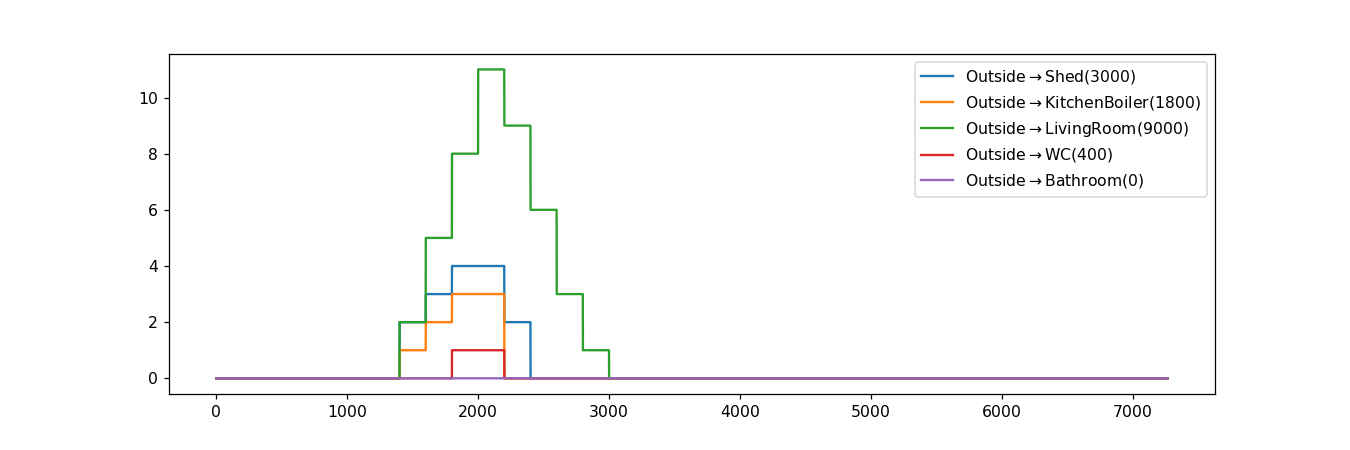

In [105]:
N = df.shape[1]
# for x_i in range(N):
x_i = 1
fig = plt.figure(figsize=[12,4])
fig.subplots_adjust(hspace=0.05)
axs = fig.subplots(1, 1, sharex=True, squeeze=False)
for y_i in range(N):
    if x_i != y_i:
        one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]

#             fig.suptitle("{}->{}".format(df.columns[x_i],df.columns[y_i]))

        text = r'$\mathrm{%s}\rightarrow \mathrm{%s} (%d)$' % (
            df.columns[x_i], df.columns[y_i], sum(one_dcc))
        axs[0,0].plot(one_dcc, label=text)

xticks = axs[0, 0].get_xticks()
# axs[0, 0].set_xticklabels([str(i+4653-300) for i in xticks])
axs[0, 0].legend(loc='upper right')
#     fname = os.path.join("temp_results", "plot", "timino", "from-{}-lag50.png".format(df.columns[x_i]))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     plt.savefig(fname, dpi=600, bbox_inches='tight')
# break
# pass

In [ ]:
N = df.shape[1]
fig = plt.figure(figsize=[12,4])
fig.subplots_adjust(hspace=0.05)
axs = fig.subplots(1, 1, sharex=True, squeeze=False)
for x_i, y_i in [(0,4), (2,3), (4,3), (5, 3)]:
    one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]
    text = r'$\mathrm{%s}\rightarrow \mathrm{%s} (%d)$' % (
        df.columns[x_i], df.columns[y_i], sum(one_dcc))
    axs[0,0].plot(one_dcc, label=text)

axs[0, 0].legend(loc='upper right')
fname = os.path.join("temp_results", "plot", "timino", "selected-pairs-lag50.png")
os.makedirs(os.path.dirname(fname), exist_ok=True)
plt.savefig(fname, dpi=600, bbox_inches='tight')
pass

In [ ]:
local_results_eff['0->1'].keys()

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.subplots(1, 1)
N = df.shape[1]
nodes = set(range(1, N+1))
fontsize='x-large'
node_size=400

g = nx.DiGraph()
g.add_nodes_from(range(1, N+1))
for i in range(1, N+1):
    for j in range(1, N+1):
        if i!=j:
            g.add_edge(i, j)

node_pos = nx.drawing.layout.circular_layout(g)


def plot_edges(plot_edges, cs, style):
#         plot_edges = []
#         edge_widths = []
#         edge_colors = []
#         for e in g.edges:
#             if cond(g_diff.edges[e]['weight']):
#                 plot_edges.append(e)
#                 edge_widths.append(abs(g_diff.edges[e]['weight']) * width_multi)
#                 edge_colors.append(c)
    arrow_collects = nx.draw_networkx_edges(g, node_pos, ax=ax,
                                            arrows=True, arrowstyle='->', 
                                            arrowsize=10, connectionstyle="Arc3, rad=0.2",
                                            alpha=0.8,
                                            edgelist=plot_edges, width=2, 
                                            edge_color=cs, node_size=node_size)
    if arrow_collects is not None:
        [a.set_linestyle(style) for a in arrow_collects]

cmap = plt.get_cmap('Greys')
cs = []
for (v1, v2) in g.edges:
    dcc_sum = float(sum(dcc_eff_new["{}->{}".format(v1-1, v2-1)]))
    cs.append(dcc_sum)
from matplotlib.colors import Normalize
norm = Normalize()
cs = norm(cs)
cs = [cmap(i) for i in cs]
plot_edges(g.edges, cs, 'solid')



nx.draw_networkx_labels(g, node_pos, labels={i: str(i) for i in nodes}, font_size=fontsize,
                       font_color='k', ax=ax)
nx.draw_networkx_nodes(g, node_pos, node_size=node_size, node_color='gray', alpha=1.0, ax=ax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)


import matplotlib.cm as cm

plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.03)

from matplotlib.lines import Line2D
legend_lines = []
text = ""
for i, col in enumerate(df.columns):
    text += "{}: {}\n".format(i+1, col)
text = text.rstrip('\n')
legend_lines.append(
    Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="gray",
           label='Nodes:'+"\n"+text))

ax.legend(handles=legend_lines, loc='upper left', fontsize=8, ncol=1)

### All datasets

In [ ]:
# Search through parameters and save results.
exp_rets = []
pbar = tqdm(total=len(datasets) * 1 * 3 * 3 * 1)
for i, data in enumerate(datasets):
    for T in range(4000, 5000, 1000):
        for step in [100, 200, 300]:
            for sign in [0.005, 0.01, 0.05]:
                for lag in [3]:
                    local_results, dcc, mat, time_stat_dict = effcause_causal_discover(
                        # Data params
                        data.to_numpy()[0:T, :],
                        # Granger interval based graph construction params
                        step=step,
                        significant_thres=sign,
                        lag=lag,  # must satisfy: step > 3 * lag + 1
                        adaptive_threshold=0.7,
                        use_multiprocess=True,
                        max_workers=3,
                        # Debug_params
                        verbose=True,
                        runtime_debug=True,
                    )
                    exp_rets.append(({
                        "dataset_id": i, 
                        "T": T,
                        "step": step,
                        "sign": sign,
                        "lag": lag,
                        "local_results": local_results,
                        "dcc": dcc,
                        "time_stat_dict": time_stat_dict
                    }))
                    pbar.set_description("{:.2f} s".format(time_stat_dict['Construct-Impact-Graph-Phase']))
                    pbar.update(1)
pbar.close()

In [ ]:
ex_rets_selected = []
pbar = tqdm(total=len(params))
for i, d in enumerate(params):
    local_results, dcc, mat, time_stat_dict = effcause_causal_discover(
        # Data params
        datasets[i].to_numpy()[:, :],
        # Granger interval based graph construction params
        step=d['step'],
        significant_thres=d['sign'],
        lag=d['lag'],  # must satisfy: step > 3 * lag + 1
        adaptive_threshold=0.7,
        use_multiprocess=True,
        max_workers=3,
        reuse_invdirection=True,
        # Debug_params
        verbose=True,
        runtime_debug=True,
    )
    ex_rets_selected.append({
                        "dataset_id": i, 
                        "T": datasets[i].to_numpy().shape[0],
                        "step": d['step'],
                        "sign": d['sign'],
                        "lag": d['lag'],
                        "local_results": local_results,
                        "dcc": dcc,
                        "time_stat_dict": time_stat_dict
                    })
    pbar.update(1)
pbar.close()

In [ ]:
# Use the timezone in my location.
local_tz = datetime.timezone(datetime.timedelta(hours=8))
time_str = datetime.datetime.now(local_tz).strftime("%Y%m%d_%H%M%S")
fname = os.path.join("temp_results", "effcause", "tcdf_finance", f"exp_rets_{time_str}.pkl")
print(fname)
os.makedirs(os.path.dirname(fname), exist_ok=True)
with open(fname, "wb") as f:
#     pickle.dump(exp_rets, f)
    pickle.dump(ex_rets_selected, f)

In [ ]:
fname = os.path.join("temp_results", "effcause", "tcdf_finance", 
                     "exp_rets_20210812_193546.pkl")
with open(fname, "rb") as f:
    exp_rets = pickle.load(f)

In [ ]:
exp_rets[0]["local_results"]["0->1"].keys()

## Evaluation
### Basic Granger Global edge construction (sklearn metrics)

In [12]:
dataset_algo_best_metric = get_max_performance(
    exp_rets, datasets, basicgranger_causality_discover, bidirection=False,
    algo_params=["sign", "lag"])

In [13]:
dataset_best_metric = eval_dataset_best(
    dataset_algo_best_metric, len(datasets), select_max_key = 'f1', 
    metric_names=['precision', 'recall', 'f1', 'auc', 'ap', 'time'])

precision:4.11%, recall:68.96%, f1:7.52%, auc:16.36%, ap:3.75%, time:16.71s, 

In [14]:
dataset_algo_best_metric[0]

{'precision': [0.01, 0.01, 0.01, 0.01],
 'recall': [1.0, 1.0, 1.0, 1.0],
 'threshold': [0, 0, 0, 0],
 'f1': [0.019801980198019802,
  0.019801980198019802,
  0.019801980198019802,
  0.019801980198019802],
 'auc': [0.005, 0.005, 0.005, 0.005],
 'ap': [0.01, 0.01, 0.01, 0.01],
 'time': [16.946052074432373,
  17.508620500564575,
  17.010972023010254,
  16.651460886001587],
 'sign': [0.005, 0.01, 0.05, 0.1],
 'lag': [3, 3, 3, 3]}

#### ROC for basic granger

In [16]:
dataset_roc_curve_data = {}

In [17]:
# rcParams['font.family'] = 'Serif'
# fig = plt.figure(1, figsize=[5,5])
# axs = fig.subplots(1, 1)

for i in range(len(datasets)):
    best_algo_idx = dataset_best_metric['idx'][i]
    exp_idx = best_algo_idx + i * 4
    d=exp_rets[exp_idx]
    dataset_id = d["dataset_id"]
    time_stat_dict = d["time_stat_dict"]
    
    N = datasets[dataset_id].shape[1]
    y, pred = basicgranger_causality_discover(d, N, bidirection=True)

    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)
    if i not in dataset_roc_curve_data:
        dataset_roc_curve_data[i] = {}
    dataset_roc_curve_data[i]["basicgranger"] = {"precision": precision,
                                                  "recall": recall,
                                                  "ap": ap}
    
#     f1 = 2 * recall * precision / (precision + recall)
#     # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
#     max_i = np.nanargmax(f1)
    
    
#     no_skill = sum([i == True for i in y]) / len(y)
#     axs.clear()
#     axs.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.4)
#     axs.plot(recall, precision, label='Basic Granger')
#     axs.set_xlabel("Recall")
#     axs.set_ylabel("Precision")
#     axs.set_title("Dataset {} AUC:{:.4f} AP:{:.4f} \nTime: {:.2f}s".format(
#         dataset_id, auc, ap, time_stat_dict['Construct-Impact-Graph-Phase']))
#     axs.legend()
#     fname = os.path.join("temp_results/basicgranger/tcdf_finance/roccurves", "dataset-{}.png".format(dataset_id))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     fig.savefig(fname, dpi=600, bbox_inches='tight')
#     fig.show()
#     break

### Basic Granger Adaptive Edge Construction (Our metrics)
Use our adaptive_thresholding algorithm to generate graph and estimate edge probability.

In [ ]:
dataset_d = {}
pbar = tqdm(total=len(exp_rets))
for d in exp_rets:
    dataset_id = d["dataset_id"]

    T = d["T"]
    sign = d["sign"]
    lag  = d["lag"]
    local_results =d["local_result"]
#     dcc = d["dcc"]
    time_stat_dict = d["time_stat_dict"]

    N = datasets[dataset_id].shape[1]
    build_intervals_bidirected(local_results, sign, T, T, N)
    dcc_bd = generate_DCC(local_results, T, N, interval_key="intervals_bidirected")
    metrics = calc_pred_curve(dcc_bd, gt_graphs[dataset_id], N, verbose=True)
    # Propagate exp params.
    for i in metrics:
        i["sign"] = sign
        i["lag"] = lag
        i["time"] = time_stat_dict['Construct-Impact-Graph-Phase']
    append_dict(dataset_d, dataset_id, metrics)

    pbar.update(1)
#     break
pbar.close()

# def prof_func():
#     metrics = calc_pred_curve(dcc_bd, gt_graphs[dataset_id], N, verbose=True)

# %lprun -f calc_pred_curve calc_pred_curve(dcc_bd, gt_graphs[dataset_id], N, verbose=True)
# %lprun -f adaptive_thresholding adaptive_thresholding(dcc_bd, 0.1, N)

In [11]:
select_max_key = 'f1'
dataset_avg_metric = {}
for idx, v in dataset_d.items():
    print("Dataset {}".format(idx), end="\t")
    best = []
    for m in v:
        best.append(np.max([i[select_max_key] for i in m]))
    best_id = np.argmax(best)
    for key in ['prec', 'recall', 'f1', 'tpr', 'fpr']:
        a = np.max([i[key] for i in v[best_id]])
        print("{}:{:.2%}".format(key, a), end='\t')
        append_dict(dataset_avg_metric, key, a)
    append_dict(dataset_avg_metric, 'time', v[best_id][0]['time'])
    print()

for key in ['prec', 'recall', 'f1', 'tpr', 'fpr']:
    a = np.mean(dataset_avg_metric[key])
    print("{}:{:.2%}".format(key, a), end='\t')
print("{}:{:.2f}".format("time", np.mean(dataset_avg_metric["time"])), end='\t')

Dataset 0	prec:1.57%	recall:100.00%	f1:3.08%	tpr:100.00%	fpr:63.47%	
Dataset 1	prec:4.48%	recall:100.00%	f1:8.57%	tpr:100.00%	fpr:65.98%	
Dataset 2	prec:5.12%	recall:100.00%	f1:9.73%	tpr:100.00%	fpr:63.97%	
Dataset 3	prec:4.81%	recall:100.00%	f1:9.18%	tpr:100.00%	fpr:64.72%	
Dataset 4	prec:4.63%	recall:100.00%	f1:8.86%	tpr:100.00%	fpr:67.30%	
Dataset 5	prec:4.44%	recall:100.00%	f1:8.50%	tpr:100.00%	fpr:62.78%	
Dataset 6	prec:3.97%	recall:95.00%	f1:7.63%	tpr:95.00%	fpr:79.14%	
Dataset 7	prec:6.72%	recall:86.84%	f1:12.48%	tpr:86.84%	fpr:81.49%	
Dataset 8	prec:7.33%	recall:85.00%	f1:13.49%	tpr:85.00%	fpr:76.79%	
prec:4.79%	recall:96.32%	f1:9.06%	tpr:96.32%	fpr:69.51%	time:16.55	

### DyCause Global edge construction (sklearn metrics)

In [18]:
fname = os.path.join("temp_results", "dycause", "tcdf_finance", 
                     "exp_rets_20210806_002717.pkl")
with open(fname, "rb") as f:
    exp_rets = pickle.load(f)

In [ ]:
exp_rets[0].keys()

In [19]:
def dycause_causality_discover(d, N, bidirection=True):
    """
    
    Args:
        bidirection: boolean. Default is True. Whether use the new interval
                     extraction algorithm which includes double direction
                     intervals.
    """
    # T = d["T"]
    step, sign, lag, time_stat_dict = d["step"], \
        d["sign"], d["lag"], d["time_stat_dict"]
    if "local_results" in d:
        local_results = d["local_results"]
    elif "local_result" in d:
        local_results = d["local_result"]
    else:
        raise KeyError("local_results not found.")
    dataset_id = d["dataset_id"]
    T = datasets[dataset_id].shape[0]
    
    verbose=False
#     if step==300 and sign==0.005 and lag==3 and dataset_id==0:
#         verbose=True
        
    if bidirection:
        build_intervals_bidirected(local_results, sign, T, step, N, verbose=verbose)
        dcc = generate_DCC(local_results, T, N, interval_key="intervals_bidirected")
    else:
#         dcc = d["dcc"]
        dcc = generate_DCC(local_results, T, N, interval_key="intervals", verbose=verbose)
    y, pred = granger_decision(dcc, gt_graphs[dataset_id], N)
    return y, pred

avg_metric = get_max_performance(exp_rets, datasets, dycause_causality_discover,
                                 bidirection=True)

In [ ]:
avg_metric[0]

In [ ]:
np.mean([d["time_stat_dict"]['Construct-Impact-Graph-Phase'] for d in exp_rets])

In [20]:
dataset_best_metric = eval_dataset_best(avg_metric, len(datasets))

precision:66.67%, recall:59.49%, f1:57.70%, auc:52.98%, ap:52.83%, time:1437.54s, 

In [ ]:
dataset_best_metric

In [ ]:
params = []
for i, idx in enumerate(dataset_best_metric['idx']):
    exp_idx = idx + i * 9
    d = {}
    for k in ["step", "sign", "lag"]:
        d[k] = exp_rets[exp_idx][k]
    params.append(d)

In [ ]:
params

In [ ]:
a = np.array(dataset_avg_metric['f1'])
np.mean(a[np.logical_not(np.isnan(a))])

In [ ]:
dataset_avg_metric['precision']

In [ ]:
# Print the best evaluation metrics for each dataset.
time_sum = 0
for i in range(len(datasets)):
    idx = dataset_avg_metric['idx'][i] + i * 9
    d = exp_rets[idx]
    dataset_id = d["dataset_id"]
    
    T = d["T"]
    step = d["step"]
    sign = d["sign"]
    lag  = d["lag"]
    local_results =d["local_result"]
    dcc = d["dcc"]
    time_stat_dict = d["time_stat_dict"]
    
    N = datasets[dataset_id].shape[1]
    build_intervals_bidirected(local_results, sign, T, step, N)
    dcc_bd = generate_DCC(local_results, T, N, interval_key="intervals_bidirected")
    y, pred = granger_decision(dcc_bd, gt_graphs[dataset_id], N)
    
    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)
    f1 = 2 * recall * precision / (precision + recall)
    max_i = np.argmax(f1)
    assert max_i < len(precision), "The last precision and recall value is not from the data, should not be uesd!"
    print("Prec:{:.2%}\tRecall:{:.2%}\tF1:{:.2%}\tAUC:{:.2%}\tAP:{:.2%}\tTime:{:.2f}s".format(
        precision[max_i], recall[max_i], f1[max_i], auc, ap, time_stat_dict['Construct-Impact-Graph-Phase']
    ))
    time_sum += time_stat_dict['Construct-Impact-Graph-Phase']
#     break

In [ ]:
time_sum / len(datasets)

In [ ]:
a = pred > thresholds[max_i]
print("Num. of Edges:", np.sum(a))
idx = 0
for i in range(N):
    for j in range(N):
        if i==j:
            continue
        if a[idx][0] == True:
            print("{}->{}".format(i, j))
        idx += 1

In [ ]:
gt_graphs[0].edges

In [ ]:
a[28][0] == True

In [ ]:
fig = plt.figure(figsize=[5,5])
axs = fig.subplots(1, 1)

no_skill = sum([i == True for i in y]) / len(y)
axs.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.4)
axs.plot(recall, precision, label='DyCause')
axs.set_xlabel("Recall")
axs.set_ylabel("Precision")
axs.set_title("Dataset {} (AUC:{:.4f} AP:{:.4f})".format(dataset_id, auc, ap))
axs.legend()
plt.show()

In [21]:
rcParams['font.family'] = 'Serif'
# fig = plt.figure(1, figsize=[5,5])
# axs = fig.subplots(1, 1)

for i in range(len(datasets)):
    best_algo_idx = dataset_best_metric['idx'][i]
    exp_idx = best_algo_idx + i * 9
    d=exp_rets[exp_idx]
    dataset_id = d["dataset_id"]
    time_stat_dict = d["time_stat_dict"]
    
    N = datasets[dataset_id].shape[1]
    y, pred = dycause_causality_discover(d, N, bidirection=True)

    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)

    if i not in dataset_roc_curve_data:
        dataset_roc_curve_data[i] = {}
    dataset_roc_curve_data[i]["dycause"] = {"precision": precision,
                                                  "recall": recall,
                                                  "ap": ap}
    
#     f1 = 2 * recall * precision / (precision + recall)
#     # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
#     max_i = np.nanargmax(f1)
    
    
#     no_skill = sum([i == True for i in y]) / len(y)
#     axs.clear()
#     axs.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.4)
#     axs.plot(recall, precision, label='DyCause')
#     axs.set_xlabel("Recall")
#     axs.set_ylabel("Precision")
#     axs.set_title("Dataset {} AUC:{:.4f} AP:{:.4f} \nTime: {:.2f}s".format(
#         dataset_id, auc, ap, time_stat_dict['Construct-Impact-Graph-Phase']))
#     axs.legend()
#     fname = os.path.join("temp_results/dycause/tcdf_finance/roccurves", "dataset-{}.png".format(dataset_id))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     fig.savefig(fname, dpi=600, bbox_inches='tight')
#     fig.show()
#     break

### DyCause Adaptive Edge Construction (Our metrics)
Use our adaptive_thresholding algorithm to generate graph and estimate edge probability.

In [ ]:
import re
dataset_d = {}
pbar = tqdm(total=len(exp_rets))
for d in exp_rets:
    dataset_id = d["dataset_id"]
    N = datasets[dataset_id].shape[1]
    
    T = d["T"]
    step = d["step"]
    sign = d["sign"]
    lag  = d["lag"]
    local_results =d["local_result"]
    build_intervals_bidirected(local_results, sign, T, step, N)
    dcc = generate_DCC(local_results, T, N, interval_key="intervals_bidirected")
#     dcc = d["dcc"]
    time_stat_dict = d["time_stat_dict"]

    N = datasets[dataset_id].shape[1]
    metrics = calc_pred_curve(dcc, gt_graphs[dataset_id], N, verbose=True)
    # Propagate exp params.
    for i in metrics:
        i["step"] = step
        i["sign"] = sign
        i["lag"] = lag
        i["time"] = time_stat_dict['Construct-Impact-Graph-Phase']
    append_dict(dataset_d, dataset_id, metrics)

    pbar.update(1)
#     break
pbar.close()

In [ ]:
dataset_d[0][0]

In [ ]:
select_max_key = 'f1'
dataset_avg_metric = {}
for idx, v in dataset_d.items():
    print("Dataset {}".format(idx), end=", ")
    best = []
    for m in v:
        best.append(np.max([i[select_max_key] for i in m]))
    best_id = np.argmax(best)
    for key in ['prec', 'recall', 'f1', 'tpr', 'fpr']:
        a = np.max([i[key] for i in v[best_id]])
        print("{}:{:7.2%}".format(key, a), end=', ')
        append_dict(dataset_avg_metric, key, a)
    append_dict(dataset_avg_metric, 'time', v[best_id][0]['time'])
    print()

for key in ['prec', 'recall', 'f1', 'tpr', 'fpr']:
    a = np.mean(dataset_avg_metric[key])
    print("{}:{:7.2%}".format(key, a), end=', ')
print("{}:{:.2f}s".format("time", np.mean(dataset_avg_metric["time"])))

In [ ]:
print("Mean AP over 50 simulation datasets:", np.mean([calc_ap(_) for _ in op_pts_list]))

print("Mean Max F1 score over 50 simulation datasets:", np.mean([np.max([2*j[0]*j[1]/(j[0]+j[1]) for j in i]) for i in op_pts_list]))

### EffCause Global Edge Construct (sklearn metrics)

In [22]:
fname = os.path.join("temp_results", "effcause", "tcdf_finance", 
                     "exp_rets_20210916_064047.pkl")
with open(fname, "rb") as f:
    exp_rets = pickle.load(f)

In [25]:
np.mean([i["time_stat_dict"]["Construct-Impact-Graph-Phase"] for i in exp_rets])

16.13094684812758

In [23]:
# exp_metrics = []
# pbar = tqdm(total=len(exp_rets))
# avg_metric = {}
# for d in exp_rets:
#     dataset_id = d["dataset_id"]
    
#     T = d["T"]
#     step = d["step"]
#     sign = d["sign"]
#     lag  = d["lag"]
#     local_results =d["local_result"]
#     dcc = d["dcc"]
#     time_stat_dict = d["time_stat_dict"]
    
#     if dataset_id not in avg_metric:
#         avg_metric[dataset_id] = {}
#     N = datasets[dataset_id].shape[1]

#     y, pred = granger_decision(dcc, gt_graphs[dataset_id], N)
    
#     precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
#     # calculate precision-recall AUC
#     auc = skmetrics.auc(recall, precision)
#     ap = skmetrics.average_precision_score(y, pred)
#     exp_metrics.append((dataset_name, T, sign, lag, precision, recall, thresholds, auc, ap))
#     f1 = 2 * recall * precision / (precision + recall)
#     max_i = np.argmax(f1)
#     assert max_i < len(precision), "The last precision and recall value is not from the data, should not be uesd!"
#     append_dict(avg_metric[dataset_id], 'precision', precision[max_i])
#     append_dict(avg_metric[dataset_id], 'recall', recall[max_i])
#     append_dict(avg_metric[dataset_id], 'f1', f1[max_i])
#     append_dict(avg_metric[dataset_id], 'auc', auc)
#     append_dict(avg_metric[dataset_id], 'ap', ap)
#     append_dict(avg_metric[dataset_id], 'time', time_stat_dict['Construct-Impact-Graph-Phase'])
#     pbar.update(1)
# pbar.close()

def effcause_causality_discover(d, N, bidirection=False, *kw, **kws):
#     T = d["T"]
    T = datasets[0].shape[0]
    step, sign, lag, time_stat_dict = d["step"], d["sign"], d["lag"], \
        d["time_stat_dict"]
    dataset_id = d["dataset_id"]
    if "local_results" in d:
        local_results = d["local_results"]
    elif "local_result" in d:
        local_results = d["local_result"]
    else:
        raise KeyError("local_results not found.")
    dataset_id = d["dataset_id"]
    
    verbose=False
#     if step==300 and sign==0.005 and lag==3 and dataset_id==0:
#         verbose=True
    #     dcc = d["dcc"]
    if bidirection:
        build_intervals_bidirected(local_results, sign, T, step, N)
        dcc = generate_DCC(local_results, T, N, interval_key="intervals_bidirected", verbose=verbose)
    else:
#         dcc = d["dcc"]
        dcc = generate_DCC(local_results, T, N, interval_key="intervals_noinv", verbose=verbose)
    y, pred = granger_decision(dcc, gt_graphs[dataset_id], N, agg_func=np.sum)
    return y, pred

avg_metric = get_max_performance(exp_rets, datasets, effcause_causality_discover, bidirection=False)

In [ ]:
avg_metric

In [24]:
# select_max_key = 'f1'
# dataset_avg_metric = {}
# for i in range(len(datasets)):
#     # Not all selected metric are nans, we can always get a maximum skiping the nans.
#     if not np.all(np.isnan(avg_metric[1][select_max_key])):
#         # Set nans to 0.0 and argmax.
#         a = np.array(avg_metric[i][select_max_key]).copy()
#         a[np.isnan(a)] = 0
#         idx = np.argmax(a)
#         for key in ['precision', 'recall', 'f1', 'auc', 'ap', 'time']:
#             append_dict(dataset_avg_metric, key, avg_metric[i][key][idx])
#         append_dict(dataset_avg_metric, 'idx', idx)
#     # If all select_max_key is nans, meaning that f1 is nan, and all precision and recall is 0.0.
#     #   For auc and ap, we use the maximum.
#     else:
#         for key in ['precision', 'recall']:
#             append_dict(dataset_avg_metric, key, 0.0)
#         append_dict(dataset_avg_metric, 'f1', np.nan)
#         for key in ['auc', 'ap']:
#             append_dict(dataset_avg_metric, key, np.max(avg_metric[i][key]))
#         append_dict(dataset_avg_metric, 'time', np.max(avg_metric[i]['time']))
#         append_dict(dataset_avg_metric, 'idx', np.nan)
# for k, v in dataset_avg_metric.items():
#     print("Avg.{}: {:.5f}".format(k, np.mean(v)), end='\t')

dataset_best_metric = eval_dataset_best(avg_metric, len(datasets))

precision:66.67%, recall:59.49%, f1:57.70%, auc:52.98%, ap:52.83%, time:1028.46s, 

In [ ]:
dataset_best_metric

#### ROC Effcause

In [26]:
# rcParams['font.family'] = 'Serif'
# fig = plt.figure(1, figsize=[5,5])
# axs = fig.subplots(1, 1)

for i in range(len(datasets)):
    best_algo_idx = dataset_best_metric['idx'][i]
    exp_idx = best_algo_idx + i * 1
    d=exp_rets[exp_idx]
    dataset_id = d["dataset_id"]
    time_stat_dict = d["time_stat_dict"]
    
    N = datasets[dataset_id].shape[1]
    y, pred = effcause_causality_discover(d, N, bidirection=False)

    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)

    if i not in dataset_roc_curve_data:
        dataset_roc_curve_data[i] = {}
    dataset_roc_curve_data[i]["effcause"] = {"precision": precision,
                                                  "recall": recall,
                                                  "ap": ap}
    
#     f1 = 2 * recall * precision / (precision + recall)
#     # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
#     max_i = np.nanargmax(f1)
    
    
#     no_skill = sum([i == True for i in y]) / len(y)
#     axs.clear()
#     axs.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.4)
#     axs.plot(recall, precision, label='EffCause')
#     axs.set_xlabel("Recall")
#     axs.set_ylabel("Precision")
#     axs.set_title("Dataset {} AUC:{:.4f} AP:{:.4f} \nTime: {:.2f}s".format(
#         dataset_id, auc, ap, time_stat_dict['Construct-Impact-Graph-Phase']))
#     axs.legend()
#     fname = os.path.join("temp_results/effcause/tcdf_finance/roccurves", "dataset-{}.png".format(dataset_id))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     fig.savefig(fname, dpi=300, bbox_inches='tight')
#     fig.show()
#     break

In [ ]:
np.mean([i[6]['Construct-Impact-Graph-Phase'] for i in exp_rets])

In [ ]:
dcc1 = exp_rets[0][5]
dcc2 = exp_rets[1][5]
fig = plt.figure(figsize=[8, 4])
axs = fig.subplots(2, 1)
for k in ['0->1', '1->0']:
    axs[0].plot(dcc1[k], alpha=0.5)
    axs[1].plot(dcc2[k], alpha=0.5)

In [ ]:
len(exp_rets)

### EffCause Adaptive Edge Construct (Our metrics)
Use our adaptive_thresholding algorithm to generate graph and estimate edge probability.

In [ ]:
import re
dataset_d = {}
pbar = tqdm(total=len(exp_rets))
for d in exp_rets:
    dataset_id = d["dataset_id"]
    
    T = d["T"]
    step = d["step"]
    sign = d["sign"]
    lag  = d["lag"]
#     local_results =d["local_result"]
    dcc = d["dcc"]
    time_stat_dict = d["time_stat_dict"]

    N = datasets[dataset_id].shape[1]
    metrics = calc_pred_curve(dcc, gt_graphs[dataset_id], N, verbose=True)
    # Propagate exp params.
    for i in metrics:
        i["step"] = step
        i["sign"] = sign
        i["lag"] = lag
        i["time"] = time_stat_dict['Construct-Impact-Graph-Phase']
    append_dict(dataset_d, dataset_id, metrics)

    pbar.update(1)
#     break
pbar.close()

In [ ]:
dataset_d[0]

In [ ]:
select_max_key = 'f1'
dataset_avg_metric = {}
for idx, v in dataset_d.items():
    print("Dataset {}".format(idx), end="\t")
    best = []
    for m in v:
        best.append(np.max([i[select_max_key] for i in m]))
    best_id = np.argmax(best) # specify the data params
    best_thr_idx = np.argmax([_[select_max_key] for _ in v[best_id]]) # specify the best threshold value
    for key in ['prec', 'recall', 'f1', 'tpr', 'fpr']:
        a = v[best_id][best_thr_idx][key]
        print("{}:{:.2%}".format(key, a), end='\t')
        append_dict(dataset_avg_metric, key, a)
    append_dict(dataset_avg_metric, 'time', v[best_id][0]['time'])
    print()
    
#     if idx==2:
#         break

for key in ['prec', 'recall', 'f1', 'tpr', 'fpr']:
    a = np.mean(dataset_avg_metric[key])
    print("{}:{:.2%}".format(key, a), end='\t')
print("{}:{:.2f}".format("time", np.mean(dataset_avg_metric["time"])), end='\t')

In [ ]:
best_id, best_thr_idx

## 1 dataset exps & Visualization

In [ ]:
d = exp_rets[best_id + idx * 4]
dataset_id = d["dataset_id"]
assert dataset_id == idx
    
T = d["T"]
# step = d["step"]
sign = d["sign"]
lag  = d["lag"]
#     local_results =d["local_result"]
dcc = d["dcc"]
time_stat_dict = d["time_stat_dict"]

N = datasets[dataset_id].shape[1]
metrics = calc_pred_curve(dcc, gt_graphs[dataset_id], N, verbose=True)
print(metrics)
#     tp, fp, tn, fn = calc_pred(mat, gt_graphs[0], N)
#     fpr = fp/(fp+tn)
#     
#     op_pts.append((prec, recall))
#     print(f"TP:{tp}\tFP:{fp}\tTN:{tn}\tFN:{fn}\tP:{prec:.2f}\tR:{recall:.2f}\tF1:{f1:.2f}\tTPR:{recall:.2f}\tFPR:{fpr:.2f}")

In [ ]:
mat = adaptive_thresholding(dcc, 1.0, N)
prec, recall, f1 = calc_f1(mat, gt_graphs[dataset_id], N, verbose=True)
print(prec, recall, f1)
print(gt_graphs[dataset_id].edges)

In [ ]:
mat_g = nx.DiGraph()
mat_g.add_nodes_from(range(N))
for i in range(N):
#     bar_data = []
    for j in range(N):
#         if i!=j:
# #             print('{}->{}'.format(i, j), "\t", sum(dcc['{}->{}'.format(i, j)]))
#             bar_data.append(float(sum(dcc['{}->{}'.format(i, j)])))
#         else:
#             bar_data.append(0)
        if mat[i, j]>0:
#             print(f"({i},{j}),", end="")
            mat_g.add_edge(i, j)
#     plt.figure(figsize=[4, 2])
#     plt.bar(range(N), bar_data)
#     plt.xlabel("From {}".format(i))
mat_g.edges()

In [ ]:
len(set(mat_g.edges) - set(gt_graphs[dataset_id].edges))

In [ ]:
def draw_graph_diff(g, gt_graph, self_edges=False,
                    width_multi=1, savefig_path=None, ax=None,
                    title=None):
    if ax is None:
        fig = plt.figure(figsize=(6, 6), dpi=300)
        ax = fig.subplots(1, 1)
    N = len(gt_graph.nodes)
    nodes = set(range(N))
    fontsize='x-large'
    node_size=400
    
    node_pos = nx.drawing.layout.circular_layout(gt_graph)
    
    # Compare graph edges with ground truth graph edges
    
    pred_set, gt_set = set(g.edges), set(gt_graph.edges)
    # TP black
    tp_edges = pred_set & gt_set
    # FP red
    fp_edges = pred_set - gt_set
    # FN red dashed
    fn_edges = set()
    for i in range(N):
        for j in range(N):
            if i==j and not self_edges:
                continue
            elif ((i,j) not in pred_set) and ((i,j) in gt_set):
                fn_edges |= {(i,j)}
#     print("TP len: {:4d}, FP len: {:4d}, FN len: {:4d}".format(len(tp_edges), len(fp_edges), len(fn_edges)))
#     print(fn_edges)
    def plot_edges(plot_edges, c, style):
#         plot_edges = []
#         edge_widths = []
#         edge_colors = []
#         for e in g.edges:
#             if cond(g_diff.edges[e]['weight']):
#                 plot_edges.append(e)
#                 edge_widths.append(abs(g_diff.edges[e]['weight']) * width_multi)
#                 edge_colors.append(c)
        arrow_collects = nx.draw_networkx_edges(g, node_pos, ax=ax,
                               edgelist=plot_edges, width=width_multi*1.0, edge_color=c,
                               arrowsize=10, edge_vmin=0.0, edge_vmax=1.0, alpha=0.5,
                               node_size=node_size)
        if arrow_collects is not None:
            [a.set_linestyle(style) for a in arrow_collects]
    import matplotlib.lines as mlines
    legend_lines = []
    plot_edges(tp_edges, 'k', 'solid')
    legend_lines.append(mlines.Line2D([], [], color='k', label='TP', linestyle='solid'))
    
    plot_edges(fp_edges, 'r', 'solid')
    legend_lines.append(mlines.Line2D([], [], color='r', label='FP', linestyle='solid'))
    
    plot_edges(fn_edges, 'r', 'dashed')
    legend_lines.append(mlines.Line2D([], [], color='r', label='FN', linestyle='dashed'))
    
    cmap = plt.get_cmap('Pastel2')

    
    nx.draw_networkx_labels(g, node_pos, labels={i: str(i) for i in nodes}, font_size=fontsize,
                           font_color='k', ax=ax)
    nx.draw_networkx_nodes(g, node_pos, node_size=node_size, node_color='gray', alpha=1.0, ax=ax)
    
#     label_pos = {node: (node_pos[node][0]*1.06, node_pos[node][1]*1.06) for node in node_pos}
#     label_pos[16] = (label_pos[16][0]-0.02, label_pos[16][1]+0.02)
#     label_pos[18] = (label_pos[18][0]-0.02, label_pos[18][1]+0.02)
#     label_pos[26] = (label_pos[26][0], label_pos[26][1]-0.04)
#     text_items = nx.draw_networkx_labels(g_diff, label_pos, 
#                             labels={(i+1): head for i,head in enumerate(simplified_data_head)}, font_size=9,
#                            font_color='k', ax=ax)
            
#     xlim = 1.9
#     ylim = 1.3
#     ax.set_xlim(-xlim, xlim)
#     ax.set_ylim(-ylim+0.1, ylim)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    
    if len(legend_lines)>0:
        ax.legend(handles=legend_lines, loc='upper left', fontsize=9, ncol=1)
    if title is not None:
        ax.set_title(title, fontsize=fontsize)

In [ ]:
draw_graph_diff(mat_g, gt_graphs[dataset_id], title=f"Dataset {dataset_id}")

In [ ]:
fig = plt.figure(figsize=[10,5])
axs = fig.subplots(1, 2)
axs[0].set_title("Ground Truth")
nx.draw(gt_graphs[dataset_id], with_labels=True, pos, ax=axs[0])

axs[1].set_title("EffCause")
nx.draw(mat_g, with_labels=True, pos=nx.drawing.layout.circular_layout(mat_g), ax=axs[1])
plt.show()

### Combined Precision Recall Curves
* TCDF Finance, saved to `temp_results/all/tcdf_finance/dataset_roc_curve_data.pkl`

In [38]:
dataset_roc_curve_data[0].keys()

dict_keys(['basicgranger', 'dycause', 'effcause', 'pcmci', 'tcdf'])

In [40]:
with open(os.path.join("temp_results", "all", "tcdf_finance", "dataset_roc_curve_data.pkl"), "wb") as f:
    pickle.dump(dataset_roc_curve_data, f)

In [43]:
with open("temp_results/all/tcdf_finance/dataset_roc_curve_data.pkl", "rb") as f:
    dataset_roc_curve_data = pickle.load(f)

In [41]:
print(plt.style.available)

['Solarize_Light2', '_classic_test', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<IPython.core.display.Javascript object>


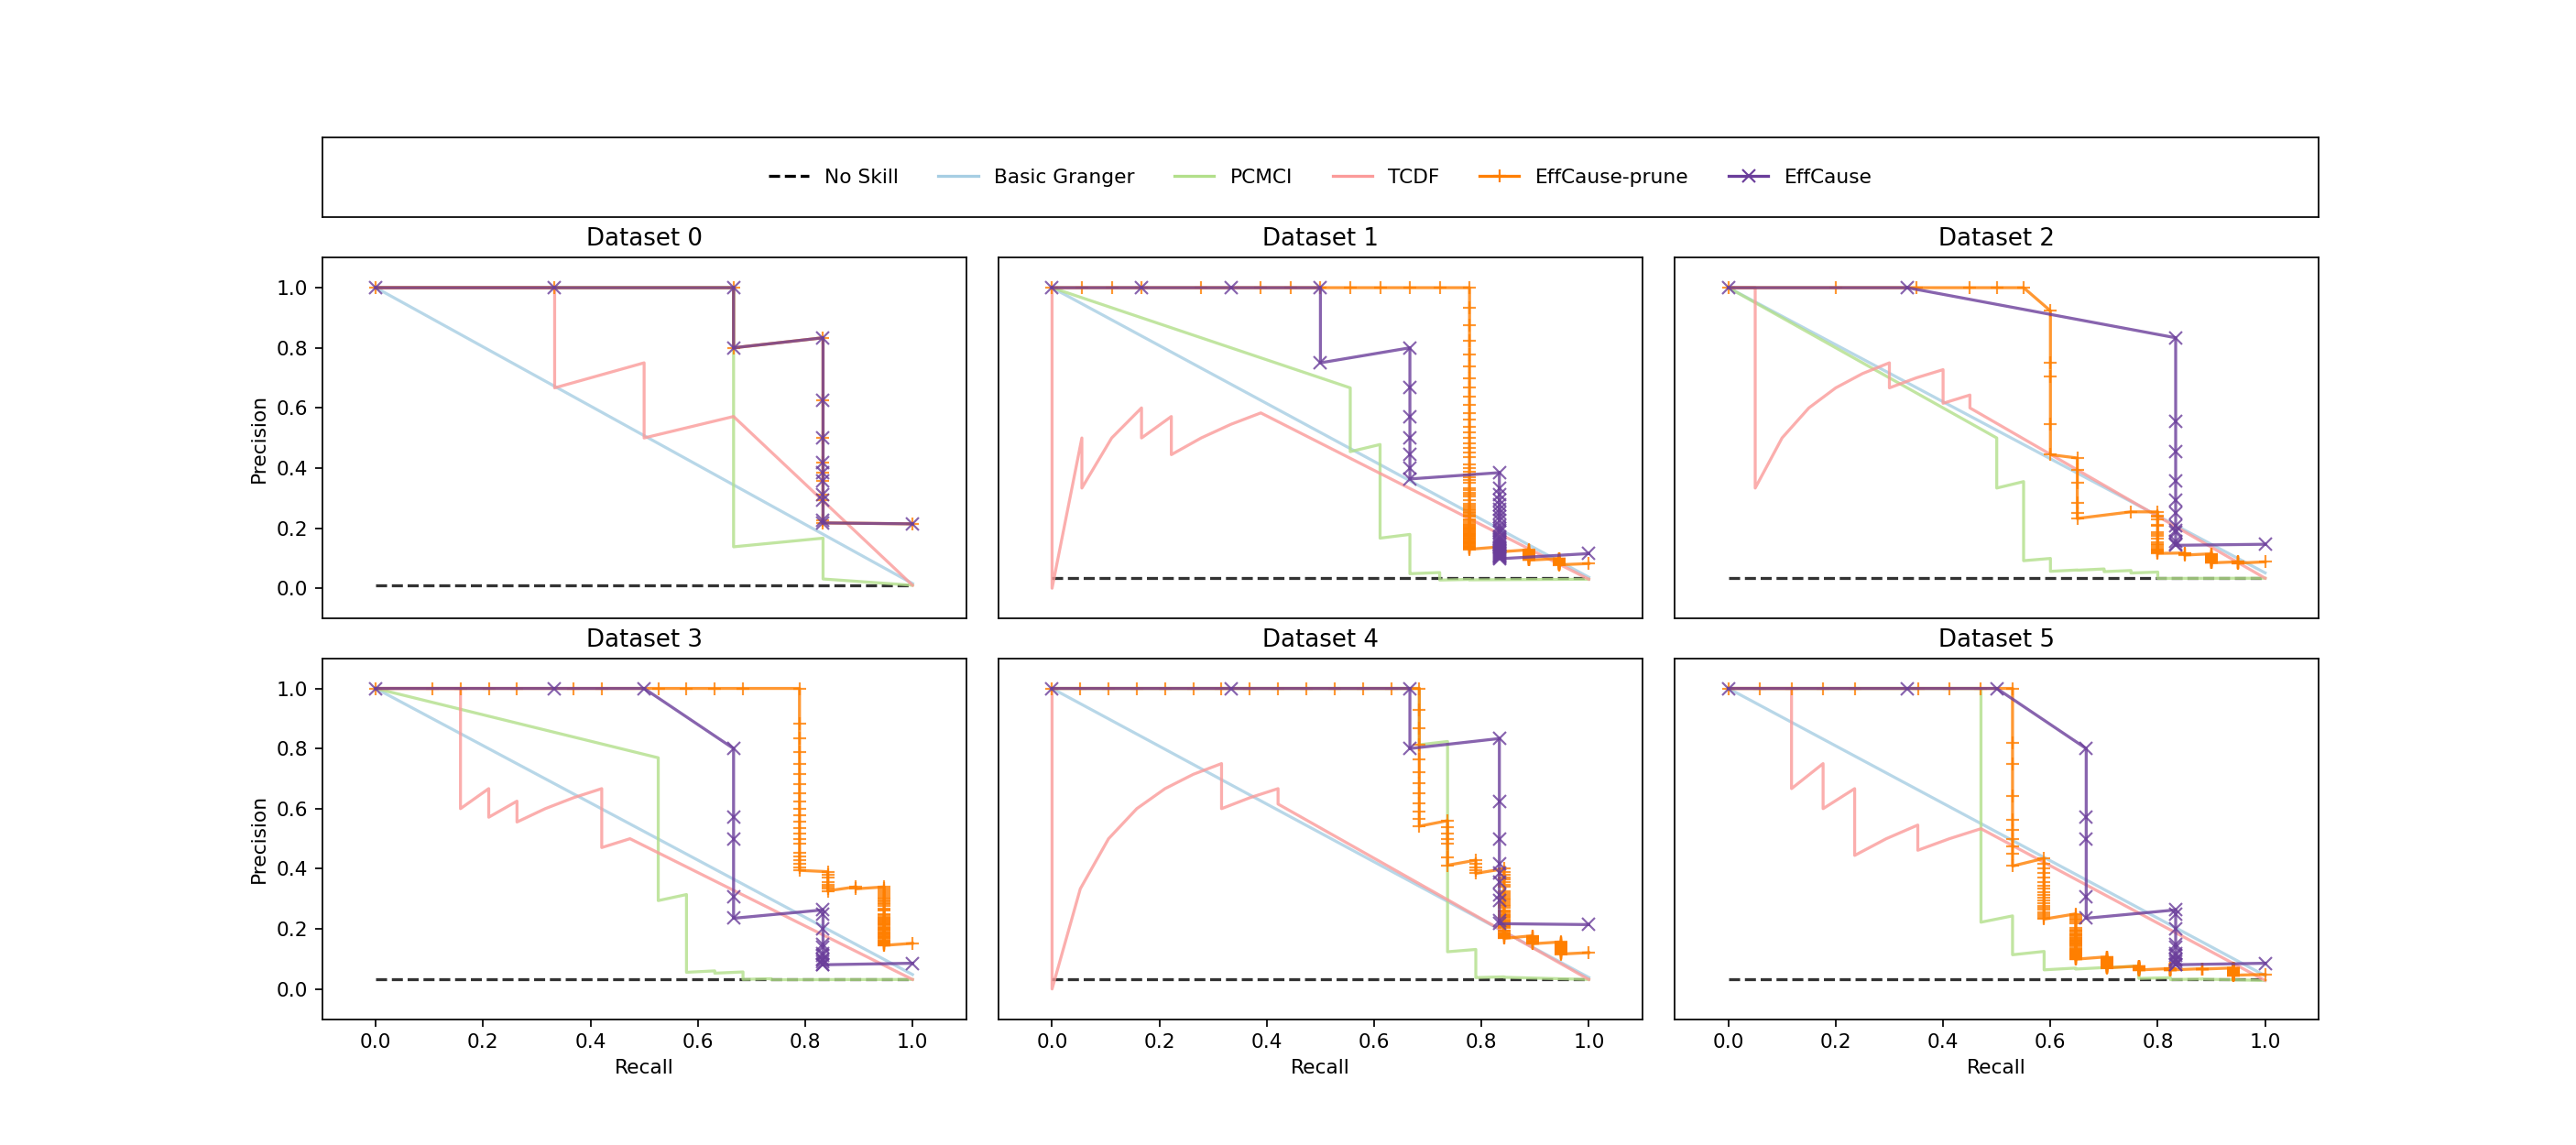

In [49]:
%matplotlib notebook
rcParams['font.family'] = 'Serif'
plt.style.use('default')

name_dict = {
    'basicgranger': "Basic Granger",
    'dycause': "EffCause-prune",
    'effcause': "EffCause",
    'pcmci': 'PCMCI',
    'tcdf': 'TCDF'
}
meth_keys = ['basicgranger', 'pcmci', 'tcdf', 'dycause', 'effcause']


fig = plt.figure(figsize=[18,8])
fig.clf()


axs = fig.subplots(3, 3, gridspec_kw={"height_ratios": [0.1, 0.45, 0.45]})
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
# axbig.annotate("Legend", (0.5, 0.5), xycoords="axes fraction", va='center', ha='center')
axbig.set_xticks([])
axbig.set_yticks([])
cmap=plt.get_cmap('Paired')
from matplotlib.lines import Line2D
def get_marker_by_meth(name):
    if name == 'dycause':
        return '+'
    elif name == 'effcause':
        return 'x'
    return None
lines = [
    Line2D([], [], color=cmap(i/5), label=name_dict[label], marker=get_marker_by_meth(label))
    for i, label in enumerate(meth_keys)]
lines = [Line2D([], [], color='k', label='No Skill', linestyle='dashed')] + lines
axbig.legend(handles=lines, loc='center', framealpha=0.5, ncol=6, frameon=False)
# axbig.set_axis_off()
axbig.set_frame_on(True)

fig.subplots_adjust(hspace=0.15, wspace=0.05)

# ax0 = fig.add_axes([0.0, legend_bottom, 1.0, 1.0-legend_bottom])

# from matplotlib.patches import Rectangle

# width = 0.45
# height = legend_bottom-0.1
# center=0.56
# ax1 = fig.add_axes([0, 0, width, height])
# ax2 = fig.add_axes([center, 0, width, height])

for i in range(len(datasets)):
    N = datasets[i].shape[1]
    no_skill = len(gt_graphs[i].edges) / (N*(N-1))
    ax = axs[(i//3)+1, i%3]
    ax.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.8)
    for j, meth in enumerate(meth_keys):
        precision = dataset_roc_curve_data[i][meth]["precision"]
        recall = dataset_roc_curve_data[i][meth]["recall"]
        # calculate precision-recall AUC
        auc = skmetrics.auc(recall, precision)
        ap = dataset_roc_curve_data[i][meth]["ap"]

        f1 = 2 * recall * precision / (precision + recall)
        # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
        max_i = np.nanargmax(f1)

        
        
#         axs.plot(recall, precision, label="{} AUC:{:.3f} AP:{:.3f}".format(name_dict[meth], auc, ap))
        ax.plot(recall, precision, label="{} auc:{:.2f}".format(name_dict[meth], auc), marker=get_marker_by_meth(meth), 
               color=cmap(j/5), alpha=0.8)
    if i>=3:
        ax.set_xlabel("Recall")
    else:
        ax.set_xticks([])
    if i in [0, 3]:
        ax.set_ylabel("Precision")
    else:
        ax.set_yticks([])
    ax.set_title("Dataset {}".format(i))
#     ax.legend(loc='upper right')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
#     fname = os.path.join("temp_results/all/tcdf_finance/roccurves", "dataset-{}.png".format(i))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     fig.savefig(fname, dpi=300, bbox_inches='tight')
    if i>=5:
        break
fname = os.path.join("temp_results/all/tcdf_finance/roccurves_combined_v2.png")
os.makedirs(os.path.dirname(fname), exist_ok=True)
fig.savefig(fname, dpi=600, bbox_inches='tight')
fig.show()
#     break

## PC algorithm
> Too slow for T=4000, do not use this method for now.
* Datasets50:     Avg. Prec. 54.13%, Avg.Rec. 45.60%, Avg.F1 49.00%. Mean AP: 3.02% Time: 0.2856 seconds.
* Finance datasets: 

In [ ]:
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest, ChiSquaredTest, MutualInformationTest
import pandas as pd

def build_graph_pc(data, alpha):
    node_num = data.shape[1]
    X = dict()
    variable_types = dict()
    for i in range(node_num):
        X[str(i)] = data[:, i]
        variable_types[str(i)] = 'c'
    X = pd.DataFrame(X)

    # run the search
    ic_algorithm = IC(RobustRegressionTest, alpha=alpha)
    graph = ic_algorithm.search(X, variable_types)

    N = [[0]*node_num for i in range(node_num)]
    for u, v in graph.edges:
        N[int(u)][int(v)] = 1
    return N

In [ ]:
pc_op_pts_list = []
pbar = tqdm(total=len(datasets)*len(np.arange(0.1, 0.5, 0.05)))
times = []
tic = time.time()
pc_exp_rets = []
dataset_aps = []
for i, data in enumerate(datasets):
    mat_list = []
    op_pts = []
    for alpha in np.arange(0.1, 0.5, 0.05):
        mat = np.array(build_graph_pc(data.to_numpy(), alpha))
        p, r, f1 = calc_f1(mat, gt_graph, N)
        op_pts.append((p,r))
        pc_exp_rets.append((f"dataset{i}", alpha, p, r, f1))
#         print(f"TP:{tp}\tFP:{fp}\tTN:{tn}\tFN:{fn}\tP:{prec:.2f}\tR:{recall:.2f}\tF1:{f1:.2f}")   
        pbar.update(1)
        toc = time.time()
        times.append(toc-tic)
        tic = toc
    ap = calc_ap(op_pts)
    dataset_aps.append(ap)
#     print("AP:", ap)
    pc_op_pts_list.append(op_pts)

In [ ]:
arr = np.array(pc_op_pts_list).squeeze()
arr_f1 = 2 * arr[:, :, 0] * arr[:, :, 1] / (arr[:, :, 0] + arr[:, :, 1])
arr_f1_idx = np.argmax(arr_f1, axis=1)
f1_mean = np.mean(arr_f1[range(len(datasets)), arr_f1_idx])
pr_max = arr[range(len(datasets)), arr_f1_idx, :]
pr_mean = np.mean(pr_max, axis=0)
print("Avg.Prec:{:.5f}\tAvg.Recall:{:.5f}\tAvg.F1:{:.5f}".format(*tuple(pr_mean), f1_mean))
print("Mean AP over 50 simulation datasets:", np.mean(dataset_aps))
print("Avg.Time: {} seconds".format(np.mean(times)))

## PCMCI
From tigramite 4.2.2.1.

* Datasets50 (Exclude self edges): Avg. Prec. 47.55%, Avg.Rec. 85.20%, Avg.F1 60.67%. Time: 0.9860 seconds.
* Finance:                 Avg. Prec: 3.54%,  Avg.Rec. 46.66%, Avg.F1 6.53%,  Time: 61.40 seconds.  
* finance (pc_alpha=[None, 0.1], alpha=np.arange(0.01, 0.21, 0.01), save_file=`exp_rets_20210809_195603.pkl`)
  * 59.87%, 50.74%, 49.69%, 71.87s (auc:40.95%, ap:37.19%, sklearn metrics with the PCMCI graph)
* fmri (pc_alpha=[None, 0.1], alpha=np.arange(0.01, 0.21, 0.01), save_file=`exp_rets_20211011_192809.pkl`)
  * precision:66.14%, recall:80.30%, f1:72.30%, auc:53.36%, ap:56.76%, time:2.15s

In [34]:
def run_pcmci(data, tau_max=3, pc_alpha=0.1, verbosity=0):
    """Run PCMCI algorithm and get intermidiate results (p value matrix ...).
    
    Params:
        data: numpy array of shape [T, N]. T is the number of samples and N is the number of variables.
        tau_max:
        pc_alpha: the PC1 algorithm alpha value. Could be None for automatic choosing.
    """
    dataframe = pp.DataFrame(data)
    cond_ind_test = ParCorr()
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=verbosity)
    pcmci_res = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=pc_alpha)
    # pcmci.print_significant_links(p_matrix=results['p_matrix'],
    #                                      val_matrix=results['val_matrix'],
    #                                      alpha_level=0.1)
    return pcmci_res

def pcmci_build_g(pcmci, pcmci_res, alpha):
    pcmci_links = pcmci.return_significant_links(pcmci_res['p_matrix'], pcmci_res['val_matrix'], alpha_level=alpha, include_lagzero_links=False)
    N = pcmci_res['p_matrix'].shape[0]
    g = nx.DiGraph()
    for i in range(N):
        g.add_node(i)
    for n, links in pcmci_links['link_dict'].items():
        for l in links:
            g.add_edge(n, l[0])
    return g

In [23]:
# Search through parameters and save results.
exp_rets = []
pbar = tqdm(total=len(datasets) * 2)
for i, data in enumerate(datasets):
    for pc_alpha in [None, 0.1]:
        tic = time.time()
        pcmci_res = run_pcmci(data.to_numpy(), pc_alpha=pc_alpha)
        toc = time.time()
        exp_rets.append({
            "dataset_id": i, 
            "pc_alpha": pc_alpha, 
            "pcmci_res": pcmci_res,
            "time": toc-tic
        })
        pbar.desc = "{:.2f} s".format(toc-tic)
        pbar.update(1)
pbar.close()

In [37]:
# Search through parameters and save results for Root Cause Analysis.
exp_rets = []
pbar = tqdm(total=3 ** 4)
for bef in [100, 200, 300]:
    for aft in [100, 200, 300]:
        for sign in [0.01, 0.05, 0.1]:
            for lag in [5, 10, 15]:
                tic = time.time()
                pcmci_res = run_pcmci(df.to_numpy()[4653-bef:4653+aft, :], pc_alpha=sign, tau_max=lag)
                dataframe = pp.DataFrame(df.to_numpy()[4653-bef:4653+aft, :])
                cond_ind_test = ParCorr()
                pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0)
                g = pcmci_build_g(pcmci, pcmci_res, sign)
                adj = nx.to_numpy_matrix(g)
                toc = time.time()
                exp_rets.append({
                    'bef': bef,
                    'aft': aft,
                    'pivot_time': 4653,
                    "pc_alpha": sign, 
                    'tau_max': lag,
                    "adj": adj,
                    "time": toc-tic
                })
                pbar.desc = "{:.2f} s".format(toc-tic)
                pbar.update(1)
pbar.close()

In [38]:
# Use the timezone in my location.
local_tz = datetime.timezone(datetime.timedelta(hours=8))
time_str = datetime.datetime.now(local_tz).strftime("%Y%m%d_%H%M%S")
fname = os.path.join("temp_results", "pcmci", "ibm_micro_service", f"exp_rets_{time_str}.pkl")
print(fname)
os.makedirs(os.path.dirname(fname), exist_ok=True)
with open(fname, "wb") as f:
    pickle.dump(exp_rets, f)

temp_results/pcmci/ibm_micro_service/exp_rets_20211115_124154.pkl


In [39]:
exp_rets[0]['adj']

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
with open(os.path.join("temp_results", "pcmci", "tcdf_finance", "exp_rets_20210809_195603.pkl"), "rb") as f:
    exp_rets = pickle.load(f)

### sklearn metrics (with PCMCI own graph build method)

In [28]:
exp_metrics = []
pbar = tqdm(total=len(exp_rets))
avg_metric = {} # Store the best sklearn metrics with different alpha for each dataset.
def append_dict(d, k, v):
    if k in d:
        d[k].append(v)
    else:
        d[k] = [v]
        
def get_edge_minp(link_dict, p_matrix, N):
    g = nx.DiGraph()
    for i in range(N):
        g.add_node(i)
    edge_p = {}
    for v1, links in link_dict.items():
        lag_pvalues = []
        for v2, tau in links:
            g.add_edge(v1, v2)
            append_dict(edge_p, (v1,v2), (tau, p_matrix[v1, v2, -tau]))
    edge_minp = {}
    for k, v in edge_p.items():
        edge_minp[k] = float(np.min([_[1] for _ in v]))
    return g, edge_minp

for d in exp_rets:
    dataset_id = d["dataset_id"]
    
    pc_alpha=d['pc_alpha']
    pcmci_res=d['pcmci_res']
    toc=d['time']
    
    if dataset_id not in avg_metric:
        avg_metric[dataset_id] = {}
    N = datasets[dataset_id].shape[1]
    dataframe = pp.DataFrame(datasets[dataset_id])
    cond_ind_test = ParCorr()
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0)
    
    for alpha in np.arange(0.01, 0.21, 0.01):
        pcmci_links = pcmci.return_significant_links(pcmci_res['p_matrix'], 
                                                     pcmci_res['val_matrix'], 
                                                     alpha_level=alpha, 
                                                     include_lagzero_links=False)

        
        g, edge_minp = get_edge_minp(pcmci_links['link_dict'], pcmci_res['p_matrix'], N)
        mat = nx.to_numpy_array(g)

        def get_decision_values(N, edge_minp, gt_graph):
            y = []
            pred = []
            for i in range(N):
                for j in range(N):
                    if i!=j:
                        key = (i, j)
                        if key in edge_minp:
                            pred.append(1-edge_minp[key])
                        else:
                            pred.append(0)
                        y.append((i, j) in gt_graphs[dataset_id].edges)
            return y, pred
    
        y, pred = get_decision_values(N, edge_minp, gt_graphs[dataset_id])
    
        precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
        # calculate precision-recall AUC
        auc = skmetrics.auc(recall, precision)
        ap = skmetrics.average_precision_score(y, pred)
    
        f1 = 2 * recall * precision / (precision + recall)
        max_i = np.nanargmax(f1) # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
        assert max_i < len(precision), "The last precision and recall value is not from the data, should not be uesd!"
        
        append_dict(avg_metric[dataset_id], 'alpha', alpha)
        append_dict(avg_metric[dataset_id], 'threshold', thresholds[max_i])
        append_dict(avg_metric[dataset_id], 'precision', precision[max_i])
        append_dict(avg_metric[dataset_id], 'recall', recall[max_i])
        append_dict(avg_metric[dataset_id], 'f1', f1[max_i])
        append_dict(avg_metric[dataset_id], 'auc', auc)
        append_dict(avg_metric[dataset_id], 'ap', ap)
        append_dict(avg_metric[dataset_id], 'time', toc)
#     if dataset_id==6:
#         break
    pbar.update(1)
pbar.close()

In [26]:
len(avg_metric[0]['alpha'])

40

In [29]:
select_max_key = 'f1'
dataset_best_metric = {}
for i in range(len(datasets)):
    # Not all selected metric are nans, we can always get a maximum skiping the nans.
    if not np.all(np.isnan(avg_metric[i][select_max_key])):
        # Set nans to 0.0 and argmax.
        a = np.array(avg_metric[i][select_max_key]).copy()
        a[np.isnan(a)] = 0
        idx = np.argmax(a)
        for key in ['alpha', 'threshold', 'precision', 'recall', 'f1', 'auc', 'ap', 'time']:
            append_dict(dataset_best_metric, key, avg_metric[i][key][idx])
        append_dict(dataset_best_metric, 'idx', idx)
    # If all select_max_key is nans, meaning that f1 is nan, and all precision and recall is 0.0.
    #   For auc and ap, we use the maximum.
    else:
        for key in ['precision', 'recall']:
            append_dict(dataset_best_metric, key, 0.0)
        for key in ['alpha', 'threshold', 'f1', 'idx']:
            append_dict(dataset_best_metric, key, np.nan)
        for key in ['auc', 'ap']:
            append_dict(dataset_best_metric, key, np.max(avg_metric[i][key]))
        append_dict(dataset_best_metric, 'time', np.max(avg_metric[i]['time']))
for k, v in dataset_best_metric.items():
    print("Avg.{}: {:.5f}".format(k, np.mean(v)), end='\t')
print("\n")
for key in ['precision', 'recall', 'f1', 'auc', 'ap']:
    a = np.mean(dataset_best_metric[key])
    print("{}:{:.2%}".format(key, a), end=', ')
print("{}:{:.2f}s".format("time", np.mean(dataset_best_metric["time"])), end='\t')

Avg.alpha: 0.12556	Avg.threshold: 0.96491	Avg.precision: 0.59870	Avg.recall: 0.50739	Avg.f1: 0.49691	Avg.auc: 0.40951	Avg.ap: 0.37191	Avg.time: 71.87056	Avg.idx: 20.44444	

precision:59.87%, recall:50.74%, f1:49.69%, auc:40.95%, ap:37.19%, time:71.87s	

In [28]:
dataset_best_metric

{'alpha': [0.11, 0.01, 0.13, 0.08, 0.11, 0.060000000000000005],
 'threshold': [0.9867790859509504,
  0.252962865323094,
  0.9976471297667407,
  0.9999981038477657,
  0.9968361582301354,
  0.9982011889028468],
 'precision': [0.6666666666666666,
  0.6923076923076923,
  0.5714285714285714,
  0.5714285714285714,
  0.8,
  0.6666666666666666],
 'recall': [0.8, 0.8181818181818182, 0.8, 0.8, 0.8, 0.8],
 'f1': [0.7272727272727272,
  0.7500000000000001,
  0.6666666666666666,
  0.6666666666666666,
  0.8000000000000002,
  0.7272727272727272],
 'auc': [0.45499999999999996,
  0.6104663013753923,
  0.3638095238095238,
  0.48839285714285713,
  0.6987878787878787,
  0.585],
 'ap': [0.5366666666666666,
  0.61005106005106,
  0.4442857142857143,
  0.47678571428571426,
  0.7342424242424244,
  0.6033333333333333],
 'time': [0.3537170886993408,
  3.687626600265503,
  2.1014087200164795,
  4.197614431381226,
  1.3233225345611572,
  1.2651309967041016],
 'idx': [30, 0, 12, 7, 10, 5]}

#### ROC PCMCI

In [30]:
# rcParams['font.family'] = 'Serif'
# fig = plt.figure(1, figsize=[5,5])
# axs = fig.subplots(1, 1)

for i in range(len(datasets)):
    best_algo_idx = dataset_best_metric['idx'][i]
    exp_idx = int(best_algo_idx / 20) + i * 2
    d=exp_rets[exp_idx]
    dataset_id = d["dataset_id"]
    toc = d["time"]
    
    N = datasets[dataset_id].shape[1]
    
    pc_alpha=d['pc_alpha']
    pcmci_res=d['pcmci_res']
    dataframe = pp.DataFrame(datasets[dataset_id])
    cond_ind_test = ParCorr()
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0)
    
    
    pcmci_links = pcmci.return_significant_links(pcmci_res['p_matrix'], 
                                                 pcmci_res['val_matrix'], 
                                                 alpha_level=dataset_best_metric['alpha'][i], 
                                                 include_lagzero_links=False)


    g, edge_minp = get_edge_minp(pcmci_links['link_dict'], pcmci_res['p_matrix'], N)

    def get_decision_values(N, edge_minp, gt_graph):
        y = []
        pred = []
        for i in range(N):
            for j in range(N):
                if i!=j:
                    key = (i, j)
                    if key in edge_minp:
                        pred.append(1-edge_minp[key])
                    else:
                        pred.append(0)
                    y.append((i, j) in gt_graphs[dataset_id].edges)
        return y, pred

    y, pred = get_decision_values(N, edge_minp, gt_graphs[dataset_id])

    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)

    if i not in dataset_roc_curve_data:
        dataset_roc_curve_data[i] = {}
    dataset_roc_curve_data[i]["pcmci"] = {"precision": precision,
                                                  "recall": recall,
                                                  "ap": ap}
    
#     f1 = 2 * recall * precision / (precision + recall)
#     # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
#     max_i = np.nanargmax(f1)
    
    
#     no_skill = sum([i == True for i in y]) / len(y)
#     axs.clear()
#     axs.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.4)
#     axs.plot(recall, precision, label='PCMCI')
#     axs.set_xlabel("Recall")
#     axs.set_ylabel("Precision")
#     axs.set_title("Dataset {} AUC:{:.4f} AP:{:.4f} \nTime: {:.2f}s".format(
#         dataset_id, auc, ap, toc))
#     axs.legend()
#     fname = os.path.join("temp_results/pcmci/tcdf_finance/roccurves", "dataset-{}.png".format(dataset_id))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     fig.savefig(fname, dpi=300, bbox_inches='tight')
#     fig.show()
#     break

In [ ]:
g_list = []
pbar = tqdm(total=len(datasets))
tic = time.time()
times = []
for data in datasets:
    g_list.append(run_pcmci(data, pc_alpha=0.01, verbosity=0))
    toc = time.time()
    times.append(toc-tic)
    tic = toc
    pbar.update(1)
pbar.close()

In [ ]:
np.mean(times)

In [ ]:
g_list[0].edges

In [ ]:
mat, gt_graph.edges

In [ ]:
prec_list = []
rec_list = []
f1_list = []
for g in g_list:
    N = 5
    mat = np.zeros([N, N])
    for e in g.edges:
        mat[e[0], e[1]] = 1
#     tp, fp, tn, fn = calc_pred(mat, gt_graph, N)
    prec, recall, f1 = calc_f1(mat, gt_graph, N, self_edges=False)
    prec_list.append(prec)
    rec_list.append(recall)
    f1_list.append(f1)
    print(f"P: {prec}\tR:{recall}\tF1:{f1}")
#     break

In [ ]:
np.mean(prec_list), np.mean(rec_list), np.mean(f1_list)

In [ ]:
dataframe = pp.DataFrame(datasets[0].to_numpy())
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=1)
pcmci_res = pcmci.run_pcmci(tau_max=3, pc_alpha=0.1)
# pcmci.print_significant_links(p_matrix=results['p_matrix'],
#                                      val_matrix=results['val_matrix'],
#                                      alpha_level=0.1)

In [ ]:
pcmci_res['val_matrix']

In [ ]:
edge_maxp

In [ ]:
fig = plt.figure(figsize=[5,5])
axs = fig.subplots(1, 1)
axs.plot(recall, precision, label='PCMCI')
no_skill = sum([i == True for i in y]) / len(y)
axs.plot([0, 1], [no_skill, no_skill], label='No Skill')
# axs.plot([0, 1], [0, 1], linestyle='dashed', color='k', alpha=0.4)
axs.set_xlabel("Recall")
axs.set_ylabel("Precision")
axs.set_title("AUC: {:.4f}".format(auc))
axs.legend()
plt.show()

In [ ]:
print(precision, recall, thresholds)

In [ ]:
pred

In [ ]:
mat = np.zeros([N, N])
for e in g.edges:
    mat[e[0], e[1]] = 1
#     tp, fp, tn, fn = calc_pred(mat, gt_graph, N)
prec, recall, f1 = calc_f1(mat, gt_graphs[0], N, self_edges=False)
prec, recall, f1

In [ ]:
gt_graphs[0].edges

In [58]:
sorted(os.listdir("temp_results/tcdf/tcdf_fmri"))

['exp_records_sign0.1_20211011_112952.pkl',
 'exp_records_sign0.2_20211011_114215.pkl',
 'exp_records_sign0.3_20211011_114409.pkl',
 'exp_records_sign0.4_20211011_114603.pkl',
 'exp_records_sign0.5_20211011_114757.pkl',
 'exp_records_sign0.6_20211011_114951.pkl',
 'exp_records_sign0.7_20211011_115146.pkl',
 'exp_records_sign0.8_20211011_115342.pkl',
 'exp_records_sign0.9_20211011_115543.pkl']

## TCDF exps

* finance, `exp_records_20210813_172251.pkl`

* fmri, in folder `temp_results/tcdf/tcdf_fmri`
  - precision:41.67%, recall:72.73%, f1:45.54%, auc:51.26%, ap:35.99%, 12.91s, `exp_records_sign0.8_20211011_115342.pkl`
  - precision:46.84%, recall:66.06%, f1:46.39%, auc:48.76%, ap:35.90%, 13.38s, `exp_records_sign0.9_20211011_115543.pkl`

In [32]:
with open(os.path.join("temp_results", "tcdf", "tcdf_finance", "exp_records_0.8_20210813_172251.pkl"), "rb") as f:
    _ = pickle.load(f)
#     print(_)
    exp_records = _['exp_records']
    toc = _['time']
print("Avg. Time: {:.2f}s".format(toc/9))

Avg. Time: 93.83s


In [60]:
len(_['exp_records'])

6

### TCDF original metrics
* In TCDF, the author calculates a extendted Precision, Recall and F1 metrics 
  that include the indirect causal links. These extended ones are called F1'.
  The traditional metric is called F1direct and etc.

In [94]:
dataset_best_metric = {}
for d in exp_records:
#     print(d.keys())
    tp = d["TP"]
    fp = d["FP"]
    fn = d["FN"]
    prec = recall = 0.0
    if (tp+fp) > 0:
        prec = tp / (tp + fp)
    if (tp+fn) > 0:
        recall = tp / (tp + fn)
    f1 = d["F1"]
    append_dict(dataset_best_metric, "prec", prec)
    append_dict(dataset_best_metric, "recall", recall)
    append_dict(dataset_best_metric, "f1", f1)
    
    tp = d["TPdirect"]
    fp = d["FPdirect"]
    fn = d["FN"]
    prec = recall = 0.0
    if (tp+fp) > 0:
        prec = tp / (tp + fp)
    if (tp+fn) > 0:
        recall = tp / (tp + fn)
    f1 = d["F1direct"]
    append_dict(dataset_best_metric, "precdirect", prec)
    append_dict(dataset_best_metric, "recalldirect", recall)
    append_dict(dataset_best_metric, "f1direct", f1)
#     break

for key in ['precdirect', 'recalldirect', 'f1direct']:
    a = np.mean(dataset_best_metric[key])
    print("{}:{:.2%}".format(key, a), end=', ')

precdirect:44.72%, recalldirect:25.63%, f1direct:27.85%, 

### TCDF own graph with sklearn metrics

In [33]:
pbar = tqdm(total=len(exp_records))
avg_metric = {} # Store the best sklearn metrics with different alpha for each dataset.
for dataset_id, d in enumerate(exp_records):
    allcauses = d["allcauses"]
    allscores = d["allscores"]

    N = datasets[dataset_id].shape[1]
    y = []
    pred = []
    for i in range(N):
        for j in range(N):
            if i!=j:
                key = (i, j)
                if i in allcauses[j]:
                    pred.append(allscores[j][i])
                else:
                    pred.append(0)
                y.append((i, j) in gt_graphs[dataset_id].edges)
    
    if dataset_id not in avg_metric:
        avg_metric[dataset_id] = {}

    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    print(pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)

    f1 = 2 * recall * precision / (precision + recall)
    max_i = np.nanargmax(f1) # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
    assert max_i < len(precision), "The last precision and recall value is not from the data, should not be uesd!"

    append_dict(avg_metric[dataset_id], 'threshold', thresholds[max_i])
    append_dict(avg_metric[dataset_id], 'precision', precision[max_i])
    append_dict(avg_metric[dataset_id], 'recall', recall[max_i])
    append_dict(avg_metric[dataset_id], 'f1', f1[max_i])
    append_dict(avg_metric[dataset_id], 'auc', auc)
    append_dict(avg_metric[dataset_id], 'ap', ap)

    pbar.update(1)
pbar.close()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.51713228225708, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.1662588119506836, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3529719114303589, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.4302082061767578, 1.502501130104065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
avg_metric

In [34]:
select_max_key = 'f1'
dataset_best_metric = {}
for i in range(len(datasets)):
    # Not all selected metric are nans, we can always get a maximum skiping the nans.
    if not np.all(np.isnan(avg_metric[i][select_max_key])):
        # Set nans to 0.0 and argmax.
        a = np.array(avg_metric[i][select_max_key]).copy()
        a[np.isnan(a)] = 0
        idx = np.argmax(a)
        for key in ['threshold', 'precision', 'recall', 'f1', 'auc', 'ap']:
            append_dict(dataset_best_metric, key, avg_metric[i][key][idx])
        append_dict(dataset_best_metric, 'idx', idx)
    # If all select_max_key is nans, meaning that f1 is nan, and all precision and recall is 0.0.
    #   For auc and ap, we use the maximum.
    else:
        for key in ['precision', 'recall']:
            append_dict(dataset_best_metric, key, 0.0)
        for key in ['threshold', 'f1', 'idx']:
            append_dict(dataset_best_metric, key, np.nan)
        for key in ['auc', 'ap']:
            append_dict(dataset_best_metric, key, np.max(avg_metric[i][key]))
for k, v in dataset_best_metric.items():
    print("Avg.{}: {:.5f}".format(k, np.mean(v)), end='\t')
print("\n")
for key in ['precision', 'recall', 'f1', 'auc', 'ap']:
    a = np.mean(dataset_best_metric[key])
    print("{}:{:.2%}".format(key, a), end=', ')

Avg.threshold: 1.04164	Avg.precision: 0.47714	Avg.recall: 0.54092	Avg.f1: 0.38653	Avg.auc: 0.34589	Avg.ap: 0.25569	Avg.idx: 0.00000	

precision:47.71%, recall:54.09%, f1:38.65%, auc:34.59%, ap:25.57%, 

In [53]:
dataset_best_metric

{'threshold': [0, 0, 0, 0, 0, 0],
 'precision': [0.25, 0.12222222222222222, 0.25, 0.25, 0.25, 0.25],
 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'f1': [0.4, 0.21782178217821782, 0.4, 0.4, 0.4, 0.4],
 'auc': [0.625, 0.5611111111111111, 0.625, 0.625, 0.625, 0.625],
 'ap': [0.25, 0.12222222222222222, 0.25, 0.25, 0.25, 0.25],
 'idx': [0, 0, 0, 0, 0, 0]}

In [35]:
# rcParams['font.family'] = 'Serif'
# fig = plt.figure(1, figsize=[5,5])
# axs = fig.subplots(1, 1)

for i in range(len(datasets)):
    best_algo_idx = dataset_best_metric['idx'][i]
    exp_idx = best_algo_idx + i * 1
    d=exp_records[exp_idx]
    dataset_id = i
    
    N = datasets[dataset_id].shape[1]

    allcauses = d["allcauses"]
    allscores = d["allscores"]

    N = datasets[dataset_id].shape[1]
    y = []
    pred = []
    for i_ in range(N):
        for j_ in range(N):
            if i_!=j_:
                key = (i_, j_)
                if i_ in allcauses[j_]:
                    pred.append(allscores[j_][i_])
                else:
                    pred.append(0)
                y.append((i_, j_) in gt_graphs[dataset_id].edges)

    precision, recall, thresholds = skmetrics.precision_recall_curve(y, pred)
    # calculate precision-recall AUC
    auc = skmetrics.auc(recall, precision)
    ap = skmetrics.average_precision_score(y, pred)

    if dataset_id not in dataset_roc_curve_data:
        dataset_roc_curve_data[dataset_id] = {}
    dataset_roc_curve_data[dataset_id]["tcdf"] = {"precision": precision,
                                                  "recall": recall,
                                                  "ap": ap}
    
#     f1 = 2 * recall * precision / (precision + recall)
#     max_i = np.nanargmax(f1) # The best threshold index using sklearn metrics. We use np.nanargmax to ignore possible nans.
#     assert max_i < len(precision), "The last precision and recall value is not from the data, should not be uesd!"
    
#     no_skill = sum([i == True for i in y]) / len(y)
#     axs.clear()
#     axs.plot([0, 1], [no_skill, no_skill], label='No Skill', linestyle='dashed', color='k', alpha=0.4)
#     axs.plot(recall, precision, label='TCDF')
#     axs.set_xlabel("Recall")
#     axs.set_ylabel("Precision")
#     axs.set_title("Dataset {} AUC:{:.4f} AP:{:.4f} \nTime: {:.2f}s".format(
#         dataset_id, auc, ap, toc))
#     axs.legend()
#     fname = os.path.join("temp_results/tcdf/tcdf_finance/roccurves", "dataset-{}.png".format(dataset_id))
#     os.makedirs(os.path.dirname(fname), exist_ok=True)
#     fig.savefig(fname, dpi=300, bbox_inches='tight')
#     fig.show()

In [36]:
dataset_roc_curve_data[0]['tcdf']

{'precision': array([0.01      , 0.57142857, 0.5       , 0.6       , 0.75      ,
        0.66666667, 1.        , 1.        , 1.        ]),
 'recall': array([1.        , 0.66666667, 0.5       , 0.5       , 0.5       ,
        0.33333333, 0.33333333, 0.16666667, 0.        ]),
 'ap': 0.5569047619047618}

## Window Time Cost Distribution

In [ ]:
with open(os.path.join("temp_results", "dycause", "temp", "runtime-data", "time_stat_dict_20210722_120554.pkl"), "rb") as f:
    time_stat_dict1 = pickle.load(f)
print(time_stat_dict1["Construct-Impact-Graph-Phase"])
t = np.concatenate(time_stat_dict1['time_window'])
fig = plt.figure(figsize=[10, 5])
axs = fig.subplots(1, 1)
hist, bin_edges = np.histogram(t, bins=100)
# ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0])

axs.plot((bin_edges[:-1]+bin_edges[1:])/2.0, hist, label='dycause', color='k', alpha=0.8)
# axs.set_yscale('log')
pass

with open(os.path.join("temp_results", "dycause", "temp", "runtime-data", "time_stat_dict_20210722_151421.pkl"), "rb") as f:
    time_stat_dict2 = pickle.load(f)
print(time_stat_dict2["Construct-Impact-Graph-Phase"])
t = np.concatenate(time_stat_dict_2['time_window'])
# fig = plt.figure(figsize=[10, 5])
# ax = fig.subplots(1, 1)
hist, _ = np.histogram(t, bins=bin_edges)
# ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0])
axs.plot((bin_edges[:-1]+bin_edges[1:])/2.0, hist, label='standard', color='k', alpha=0.8)
# axs.set_yscale('log')

with open(os.path.join("temp_results", "effcause", "temp", "runtime-data", "time_stat_dict_20210722_115731.pkl"), "rb") as f:
    time_stat_dict3 = pickle.load(f)

print(time_stat_dict3["Construct-Impact-Graph-Phase"])
t = np.concatenate(time_stat_dict_3['time_window'])
hist, _ = np.histogram(t, bins=bin_edges)
# ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0])
axs.plot((bin_edges[:-1]+bin_edges[1:])/2.0, hist, label='effcause', color='k', alpha=0.8)
axs.set_yscale('log')

axs.set_xticks(((bin_edges[:-1]+bin_edges[1:])/2.0)[::10])
axs.set_ylabel("Histogram",fontsize='x-large')
axs.set_xlabel("Window Time (Second)",fontsize='x-large')    
axs.legend(fontsize='x-large')
pass

# RCA Performances

In [ ]:
3 ** 5

In [ ]:
from effcause_rca import effcause_rca

prk_acc_list = []
pbar = tqdm(total=3 ** 5)
for bef in [100, 200, 300]:
    for aft in [100, 200, 300]:
        for step in [50, 60, 70]:
            for sign in [0.01, 0.05, 0.1]:
                for lag in [5, 10, 15]:
                    tic = time.time()
                    prks, acc = effcause_rca(
                        # Data params
                        data_source="external",
                        aggre_delta=1,
                        start_time=1200,
                        before_length=bef,
                        after_length=aft,
                        # Granger interval based graph construction params
                        # step=50,
                        step=step,
                        significant_thres=sign,
                        lag=lag,  # must satisfy: step > 3 * lag + 1
                        auto_threshold_ratio=0.7,
                        runtime_debug=True,
                        # Root cause analysis params
                        testrun_round=1,
                        frontend=16,
                        max_path_length=None,
                        mean_method="harmonic",
                        true_root_cause=[1],
                        topk_path=150,
                        num_sel_node=3,
                        # Debug params
                        use_multiprocess=True,
                        verbose=False,
                        max_workers=3,
                        data=data,
                        data_head=data_head
                    )
                    toc = time.time()-tic
                    prk_acc_list.append({
                        "bef": bef,
                        "aft": aft,
                        "step": step,
                        "sign": sign,
                        "lag": lag,
                        "prks": prks,
                        "acc": acc,
                        "time": toc
                    })
                    pbar.update(1)
pbar.close()

In [ ]:
with open("effcause-ibm-rca-logs.txt", "rt") as f:
    lines = f.readlines()

In [ ]:
import re


re.search(r'\'backtrace rca\': (.*)}', lines[-1]).groups()[0]

In [ ]:
times = []
for line in lines:
    mat = re.search(r'\'backtrace rca\': (.*)}', line)
    if mat:
        times.append(mat.groups()[0])

In [ ]:
len(times)

In [ ]:
idx = np.argsort([i['acc'] for i in prk_acc_list])
for i in idx[-10:]:
    print(i, prk_acc_list[i], times[i])
# prk_acc_list[idx]

## IBM Microservices Dynamic Plots

In [ ]:
dcc_eff_new['0->1']

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

node_props = {
    1: ((700, 365), 'event'),
    31: ((310, 365), 'event'),
    6: ((1066, 365), 'event'),
    30: ((2000, 365), 'event'),
    33: ((2425, 365), 'event'),
    28: ((2940, 365), 'event'),
    16: ((1440, 570), 'console'),
    25: ((535, 745), 'console'),
    19: ((965, 745), 'console'),
    3: ((1690, 745), 'others'),
    9: ((2105, 745), 'others'),
    2: ((2435, 870), 'security'),
    22: ((2630, 1080), 'security'),
    27: ((2025, 1080), 'others'),
    21: ((2710, 1345), 'security'),
    23: ((950, 1345), 'console'),
    10: ((1190, 1495), 'others'),
    7: ((2010, 1495), 'others'),
    17: ((2910, 1555), 'security'),
    12: ((3330, 1555), 'security'),
    15: ((2425, 1800), 'security'),
    5: ((3345, 1800), 'security'),
    11: ((2495, 2185), 'dashboard'),
    4: ((2850, 2185), 'dashboard'),
    14: ((3150, 2050), 'dashboard'),
    29: ((3470, 2050), 'dashboard')
}
nodes = node_props.keys()
node_pos = {k: v[0] for k,v in node_props.items()}
choose_color = { 
    'event': '#ff6600',
    'console': '#bdd0e9',
    'others': '#c5e0b3',
    'security': '#efb7f7',
    'dashboard': '#fee599'
}
node_color = [choose_color[node_props[v][1]] for v in nodes]

adaptive_threshold = 0.8
N = df.shape[1]
g = nx.DiGraph()
for i in node_pos.keys():
    g.add_node(i)

# Global edge construction algorithm
pred = get_decision_values(dcc_eff_new, N)
thres = np.sort(pred)[-30]
max_h = 0
for i in range(1, N+1):
    for j in range(1, N+1):
        if i!=j and i in nodes and j in nodes:
#             print(type(dcc_eff_new[f'{i-1}->{j-1}']))
            w = float(sum(dcc_eff_new[f'{i-1}->{j-1}']))
            h = float(np.max(dcc_eff_new[f'{i-1}->{j-1}']))
            if h>max_h:
                max_h = h
#             if w>=thres:
#                 g.add_edge(i, j)

# Make edges from 1 node using comparison and auto-threshold
for x_i in range(1, N+1):
    bar_data = []
    for y_i in range(1, N+1):
        if y_i == x_i:
            bar_data.append(0)
            continue
        key = "{0}->{1}".format(x_i-1, y_i-1)
        w = float(sum(dcc_eff_new[key]))
        bar_data.append(w)
    bar_data_thres = np.max(bar_data) * adaptive_threshold
    for y_i in range(1, N+1):
        if bar_data[y_i-1] >= bar_data_thres \
            and y_i!=x_i and x_i in nodes and y_i in nodes:
            g.add_edge(x_i, y_i)
                

# Normalize dcc_eff_new to [0, 1]
dcc_eff_new_nm = {}
for (v1, v2) in g.edges():
    dcc_eff_new_nm[f'{v1-1}->{v2-1}'] = dcc_eff_new[f'{v1-1}->{v2-1}'] / max_h
    

def plot_ibm_instant_graph(timestamp, ax):

    node_size=800

    nx.draw_networkx_labels(g, node_pos, labels={i: str(i) for i in nodes}, ax=ax)
    nx.draw_networkx_nodes(g, node_pos, alpha=1.0, ax=ax, node_shape='H',
                           nodelist=nodes, node_color=node_color,
                           node_size=node_size)

    cmap = plt.get_cmap('Greys')
    cs = []
    for (v1, v2) in g.edges():
        cs.append(float(dcc_eff_new_nm[f'{v1-1}->{v2-1}'][timestamp]))
    from matplotlib.colors import Normalize
#     norm = Normalize()
#     cs = norm(cs)
    cs = [cmap(i) for i in cs]
#     print(cs)

    edgelist = g.edges
    # [(31, 25), (1, 6), (31, 11)]


    nx.draw_networkx_edges(g, node_pos, ax=ax,
        arrows=True, arrowstyle='->', arrowsize=10, 
#         connectionstyle="angle, angleA=90, angleB=0, rad=3",
        connectionstyle="arc3, rad=0.5",
        alpha=0.8,
        edgelist=edgelist, 
        edge_color=cs,
        width=2, node_size=node_size)

    

    # plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.03)

    
    
fig = plt.figure(figsize=(10*3, 6*3), dpi=300)
axs = fig.subplots(3, 3)
fig.subplots_adjust(wspace=0, hspace=0)
j = 0
for i in range(0, 400, step):
    plot_ibm_instant_graph(i, axs[j//3, j%3])
    j += 1
#     if j==6:
#         break
for _ in axs.flatten():
    _.set_axis_off()
    _.set_frame_on(False)

os.makedirs(os.path.join("temp_results", "plot", "ibm_micro_service"), 
            exist_ok=True)
plt.savefig(os.path.join("temp_results", "plot", "ibm_micro_service", "instant_plot_4.png"), 
            dpi=600, bbox_inches='tight')
plt.close()

# fig = plt.figure(figsize=(10, 6), dpi=300)
# ax = fig.subplots(1, 1)
# plot_ibm_instant_graph(360, ax)

In [ ]:
axs.flatten()

# Traffic

**PEMS-Bay**
* `step=1000,sign=1e-2,lag=50` for `selected_cols`, entire time range. Save file: `exp_rets_20210924_202023.pkl`.
* `step=200,sign=1e-2,lag=20` for `selected_cols`, entire time range. save file: `exp_rets_20211007_051621.pkl`.
* `step=total,sign=1e-2,lag=20` for all cols, entire time range. save file: `exp_rets_20211017_133440.pkl`


* weekly_df, 107 selected_cols, early stopped output for first 3: `exp_rets_20211021_210509.pkl`
  
  continued output : `exp_rets_20211024_122036.pkl`
  
**METR-LA**
* `step=total,sign=1e-2,lag=20` for all cols, entire time range. save file: `exp_rets_20211108_152720.pkl`

## All dcc for pairs of 107/42 selected nodes

In [41]:
# pems-bay
# with open("temp_results/effcause/pems-bay/exp_rets_20211021_210509.pkl", "rb") as f:
#     d_list = pickle.load(f)

# with open("temp_results/effcause/pems-bay/exp_rets_20211024_122036.pkl", "rb") as f:
#     d_list.extend(pickle.load(f))
    
# metr-la
with open("temp_results/effcause/metr-la/exp_rets_20211109_082852.pkl", "rb") as f:
    d_list = pickle.load(f)
selected_cols = [ 51,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 206]

In [39]:
d_list[0].keys()

dict_keys(['week_id', 'step', 'sign', 'lag', 'local_results', 'time_stat_dict'])

In [40]:
d_list[0]['step']

200

In [50]:
# Concatanate the weekly dcc for selected cols
sign = 1e-2
N = df.shape[1]
all_dcc = np.zeros([N, N, df.shape[0]])
time_ind = 0
for d in d_list:
    week_id = d['week_id']
    

    local_length = weekly_df[week_id].shape[0]
    step=d["step"]
    list_segment_split = get_segment_split(local_length, step)
    effcause_build_intervals(len(selected_cols), d['local_results'], sign, list_segment_split, verbose=False)
    
#     dcc_eff_temp = generate_DCC(d['local_results'], local_length, len(selected_cols), interval_key="intervals")
    dcc_eff_temp = generate_DCC(d['local_results'], local_length, len(selected_cols), interval_key="intervals_noinv")
    for i in range(len(selected_cols)):
        for j in range(len(selected_cols)):
            if i!=j:
                k = f"{i}->{j}"
                dcc = dcc_eff_temp[k].reshape(-1)
                l = len(dcc)
                all_dcc[selected_cols[i], selected_cols[j], time_ind:time_ind+l] = dcc
    time_ind += l

In [51]:
# Normalize at each time step
amax = np.amax(np.amax(all_dcc, axis=0, keepdims=True), axis=1, keepdims=True)
for t in range(all_dcc.shape[2]):
#     loc_max = np.max(all_dcc[:,:,t])
    loc_max = amax[0, 0, t]
    if loc_max != 0:
        all_dcc[:, :, t] = all_dcc[:, :, t] / loc_max

In [54]:
all_dcc[:, :, 0].nonzero()

(array([ 51,  51,  51, ..., 206, 206, 206]),
 array([53, 54, 56, ..., 93, 96, 98]))

In [55]:
all_dcc[51, 53, :]

array([0.1, 0.1, 0.1, ..., 0. , 0. , 0. ])

<IPython.core.display.Javascript object>


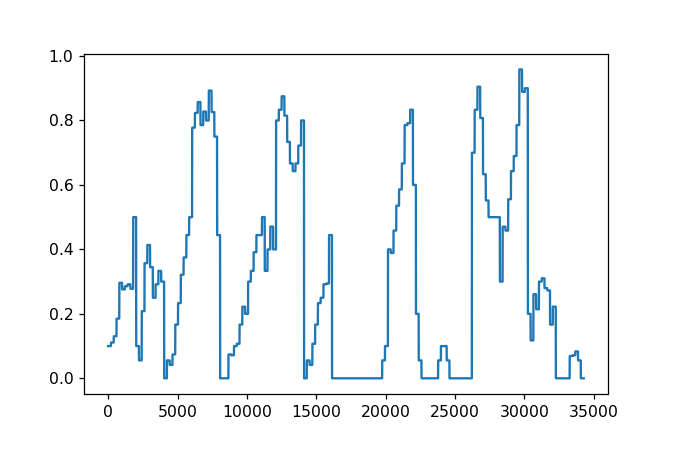

In [56]:
fig = plt.figure(figsize=[6, 4])
plt.plot(all_dcc[51, 53, :])

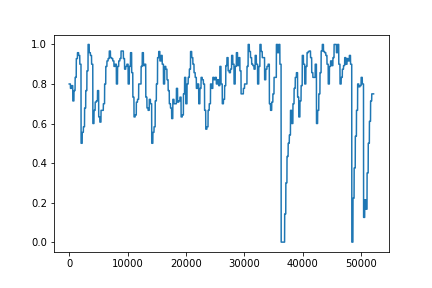

In [36]:
fig = plt.figure(figsize=[6, 4])
plt.plot(all_dcc[1, 8, :])

In [57]:
# np.savez_compressed("temp_results/effcause/pems-bay/all_dcc_weekly_sel", all_dcc)

np.savez_compressed("temp_results/effcause/metr-la/all_dcc_weekly_sel_noinv.npz", all_dcc)

In [3]:
all_dcc = np.load("temp_results/effcause/pems-bay/all_dcc_weekly_sel_noinv.npz")["arr_0"]

In [88]:
selected_cols = [  1,   2,   8,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 161, 324]
print(len(selected_cols))

107


In [5]:
np.sum(all_dcc==0)

5165055320

In [59]:
import scipy
all_dcc = all_dcc.reshape(-1, df.shape[0]) # flatten the N*N node dimensions to 1 dimension, now shape [N*N, T]
all_dcc = scipy.sparse.coo_matrix(all_dcc) # convert to coo sparse matrix
scipy.sparse.save_npz("temp_results/effcause/metr-la/all_dcc_metrla_weekly_sel_noinv_sparse.npz", all_dcc)

In [44]:
all_dcc = all_dcc.tocsc()

In [81]:
all_dcc[1*325+8, :].todense()

matrix([[0.8 , 0.8 , 0.8 , ..., 0.75, 0.75, 0.75]])

In [127]:
all_dcc.shape

(105625, 52116)

In [134]:
x = np.random.randn(5, 4)
x[:, [0,1]]

array([[ 0.18178126,  0.78968302],
       [-0.21072675, -0.16595577],
       [-0.28331965,  0.19491425],
       [-0.3174879 ,  0.71176468],
       [ 1.90021124, -0.17282555]])

### Graph video generate

In [42]:
locations = pd.read_csv("/workspace/DCRNN/data/sensor_graph/graph_sensor_locations_bay.csv", header=None, names=["sensor_id", "lat", "lon"])
locations

,sensor_id,lat,lon
0,400001,37.364085,-121.901149
1,400017,37.253303,-121.945440
2,400030,37.359087,-121.906538
3,400040,37.294949,-121.873109
4,400045,37.363402,-121.902233
...,...,...,...
320,413845,37.422887,-121.925747
321,413877,37.321613,-121.899642
322,413878,37.324641,-121.888603
323,414284,37.323066,-121.896538


In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.patches import ConnectionPatch

# from matplotlib.animation import FFMpegWriter
# metadata = dict(title='PEMS-Bay DCC', artist='Matplotlib',
#                 comment='Generated by PanYicheng')
# writer = FFMpegWriter(fps=30, metadata=metadata)


fig = plt.figure(figsize=[6, 5], dpi=100)
fig.subplots_adjust(top=0.95)
ax = fig.add_subplot(autoscale_on=False, xlim=(-122.0905, -121.8303), ylim=(37.2433, 37.4361))
ax.set_aspect('equal')
ax.grid()

# Scatter all sensors with red and black
scatter_arts = [ax.scatter(locations["lon"][selected_cols], locations["lat"][selected_cols], color='r', alpha=0.5)]
oth_inds = list(set(locations.index) - set(selected_cols))
locs = locations.iloc[oth_inds, :]
scatter_arts.append(ax.scatter(locs["lon"], locs["lat"], alpha=0.5, color="#3b2121"))

def get_pos(sensor_ind):
    return (locations["lon"][sensor_ind], locations["lat"][sensor_ind])


def add_arrow(sa, sb, lw=1.5, c='k'):
#     print(f"{sa}->{sb}: {c}")
    p = ConnectionPatch(get_pos(sa), get_pos(sb), 
                    "data", arrowstyle='->', connectionstyle="arc3, rad=0.5", 
                    alpha=0.5, lw=lw, color=c)
    ax.add_patch(p)
    return p


# Choose a limited number `num_arrs` of sensor pairs
num_arrs = 50
pairs = []
for i in range(len(selected_cols)):
    for j in range(len(selected_cols)):
        if i!=j:
            pairs.append((selected_cols[i], selected_cols[j]))
pairs = [pairs[i] for i in np.random.choice(range(len(pairs)), size=num_arrs, replace=False)]



cmap = plt.get_cmap("cool")

patch_list = []
for i,j in pairs:
    patch_list.append(add_arrow(i, j, c=(0,0,0)))
    
def init():
    return scatter_arts + patch_list

N = df.shape[1]
def run(time_step):
    t_dcc = all_dcc[:, time_step].todense() # shape [N*N, 1]
    for it, (i,j) in enumerate(pairs):
        v = t_dcc[i * N + j, 0]
        patch_list[it].set_color(cmap(v))
    return scatter_arts + patch_list


tot_step = all_dcc.shape[1]
ani = animation.FuncAnimation(fig, run, range(tot_step), interval=1000/60, blit=True)
plt.show()

# Show as a html video
# video = ani.to_html5_video()
# html = display.HTML(video)
# display.display(html)

# pbar = tqdm(total=tot_step)
# i_prev = 0
def callback(i, n):
    print(f"{i/n:.4f}", end="\r")
#     pbar.update(1)
#     pbar.write(f"{i/n:.2f}")
#     i_prev = i
ani.save("temp_results/effcause/pems-bay/dcc_movie_2.mp4", writer,
         progress_callback=callback)
plt.close()                   # avoid plotting a spare static plot
# pbar.close()

In [115]:
np.random.choice(range(10), size=2)

array([4, 8])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

fig = plt.figure(figsize=[6, 5], dpi=200)
fig.subplots_adjust(top=0.95)
ax = fig.add_subplot(autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
ax.set_aspect('equal')
ax.grid()
# cmap = plt.get_cmap("Greys")
cmap = plt.get_cmap("cool")
patch_list = []

patch_list.append(ConnectionPatch([-0.5,0.5], [0.5,0.5], 
                    "data", arrowstyle='->', connectionstyle="arc3, rad=0.5", 
                    alpha=0.9, lw=2, color=cmap(1)))
patch_list.append(ConnectionPatch([-0.5,-0.5], [0.5,-0.5], 
                    "data", arrowstyle='->', connectionstyle="arc3, rad=0.5", 
                    alpha=0.9, lw=2, color=cmap(1)))
[ax.add_patch(p) for p in patch_list]
ax.scatter([-0.5, -0.5, 0.5, 0.5], [0.5, -0.5, 0.5, -0.5], color='r', alpha=1.0)

def run(time_step):
    patch_list[0].set_color(cmap((time_step%30)/30.0))
    patch_list[1].set_color(cmap((time_step%40)/40.0))
    return patch_list

# run(0)
ani = animation.FuncAnimation(fig, run, range(100), interval=1000/30, blit=True)

# Show in jupyter
# plt.show()

# Show as a html video
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

In [86]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
from matplotlib.animation import FFMpegWriter

# Fixing random state for reproducibility
np.random.seed(19680801)


metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure()
l, = plt.plot([], [], 'k-o')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

x0, y0 = 0, 0

with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(1000):
        x0 += 0.1 * np.random.randn()
        y0 += 0.1 * np.random.randn()
        l.set_data(x0, y0)
        writer.grab_frame()

2021-10-25 11:40:54,752 INFO: MovieWriter._run: running command: /usr/bin/ffmpeg -f rawvideo -vcodec rawvideo -s 600x400 -pix_fmt rgba -r 15 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -metadata 'title=Movie Test' -metadata artist=Matplotlib -metadata 'comment=Movie support!' -y writer_test.mp4


In [80]:
from datetime import timedelta
print(timedelta(seconds=df.shape[0]*(t2-t1)))

1 day, 7:52:57.518346


t2-t1

In [21]:
sign = 1e-2
lag = 20
local_results, dcc, mat, time_stat_dict = effcause_causal_discover(
    # Data params
    df.to_numpy(),
    # Granger interval based graph construction params
    step=df.shape[0],
    significant_thres=sign,
    lag=lag,  # must satisfy: step > 3 * lag + 1
    reuse_invdirection=True,
    rolling_method="zyf",
    min_nobs=25,
    max_segment_len=None,
    adftest=True,
    share_data_by_pickle=False,
    adaptive_threshold=0.7,
    use_multiprocess=True,
    max_workers=3,
    # Debug_params
    verbose=True,
    runtime_debug=True,
)

------------------------------------EffCause------------------------------------
--------------------EffCause impact graph construction phase--------------------
          Starting at                                 20211015_015628                                 
          Calculating granger intervals:
               data shape   :(52116, 325)
               lag          :20
               significant  :0.01
               step         :52116
               min len      :52116
               max len      :52116
               method       :v1
               rolling meth :zyf
               min_nobs     :25
               adf test     :True
               share_data_by_pickle:False
               segment split: [0, 52116]
Using ProcessPoolExecutor.


KeyboardInterrupt: 

## Total graph and run time estimation

**pems-bay**
1. `step=200,sign=1e-2,lag=20`
  ```
  Time of a single pair: 0:44:43.513894
  Time of 100 pairs: 3 days, 2:32:31.389427
  Time of 5761 pairs: 178 days, 22:22:03.544870
  Time of 2694 pairs: 83 days, 16:09:46.431154
  ```

2. `step=1000,sign=1e-2,lag=50`
  ```
  Time of a single pair: 0:04:23.638734
  Time of 100 pairs: 7:19:23.873378
  Time of 5761 pairs: 17 days, 13:53:42.745332
  Time of 2694 pairs: 8 days, 5:17:22.748815
  ```
  
3. Weekly, `step=200,sign=1e-2,lag=20`
  ```
  Time of a single pair: 0:00:02.631606
  Time of 100 pairs: 0:04:23.160606
  Time of 5761 pairs: 4:12:40.682533
  Time of 2694 pairs: 1:58:09.546736
  ```
  
**metr-la**
1. `temp_results/effcause/metr-la/exp_rets_20211108_203504.pkl`
  `step=200, sign=1e-2, lag=20`
  `selected_cols=[1,2,3]`
  ```
  Time of a single pair: 0:05:53.274330
  Time of 100 pairs: 9:48:47.432993
  Time of 5761 pairs: 23 days, 13:20:13.414711
  Time of 2694 pairs: 11 days, 0:22:01.044824
  ```
2. Weekly, `temp_results/effcause/metr-la/exp_rets_20211108_205042.pkl`
  `step=200, sign=1e-2, lag=20`
  `selected_cols=[1,2,3]`
  ```
  Time of a single pair: 0:00:42.772678
  Time of 100 pairs: 1:11:17.267827
  Time of 900 pairs: 10:41:35.410442
  Time of 2694 pairs: 1 day, 8:00:29.595257
  ```

In [24]:
106 * 105

11130

In [30]:
with open("temp_results/effcause/metr-la/exp_rets_20211108_205042.pkl", "rb") as f:
    d_list = pickle.load(f)
print([d["time_stat_dict"]['Construct-Impact-Graph-Phase'] for d in d_list])
t = np.sum([d["time_stat_dict"]['Construct-Impact-Graph-Phase'] for d in d_list])
# t = d["time_stat_dict"]['Construct-Impact-Graph-Phase']
selected_cols = [1, 2, 3]
t_1 = t / (len(selected_cols) * len(selected_cols) / 2)

from datetime import timedelta
print("Time of a single pair:", timedelta(seconds=t_1))
num = 100
print(f"Time of {num} pairs:", timedelta(seconds=t_1 * num))
num = 900
print(f"Time of {num} pairs:", timedelta(seconds=t_1 * num))
num = 2694
print(f"Time of {num} pairs:", timedelta(seconds=t_1 * num))

[13.079708099365234, 12.70238995552063, 6.332878351211548, 8.647212266921997, 13.491162538528442, 11.383624792098999, 12.506001710891724, 10.295213460922241, 17.227860927581787, 13.358268737792969, 8.601994514465332, 10.016595125198364, 13.550476551055908, 10.105920553207397, 10.257713317871094, 6.492690324783325, 14.427340984344482]
Time of a single pair: 0:00:42.772678
Time of 100 pairs: 1:11:17.267827
Time of 900 pairs: 10:41:35.410442
Time of 2694 pairs: 1 day, 8:00:29.595257


64.0

## Estimate adjacency matrix from overall test

In [34]:
# with open("temp_results/effcause/pems-bay/exp_rets_20211007_051621.pkl", "rb") as f:
#     d = pickle.load(f)[0]
with open("temp_results/effcause/metr-la/exp_rets_20211108_152720.pkl", "rb") as f:
    d = pickle.load(f)[0]
for k in ["step", "sign", "lag"]:
    print(k, ":", d[k])
# print("Time:", d["time_stat_dict"]['Construct-Impact-Graph-Phase'])
# print("Node pairs:", d['local_results'].keys())

step : 34272
sign : 0.01
lag : 20


In [35]:
d.keys()

dict_keys(['step', 'sign', 'lag', 'local_results'])

In [36]:
N = df.shape[1]
bidirection = True
reuse_bidirection = True
sign = 1e-40
mat = np.zeros([N, N])
def trans_f(x):
    return np.array(1.0) - x
for i in range(N):
    for j in range(N):
        if i==j:
            mat[i, j] = 1.0
            continue
        if i>j and reuse_bidirection is True:
            continue
        k = '{}->{}'.format(i, j)
        res_YX = d['local_results'][k]['result_YX']
        res_XY = d['local_results'][k]['result_XY']
        if not bidirection:
            if res_YX[0, 1]<=sign and res_XY[0, 1]>sign:
                mat[i, j] = trans_f(res_YX[0, 1])
            if reuse_bidirection is True:
                if res_YX[0, 1] > sign and res_XY[0, 1] <= sign:
                    mat[j, i] = trans_f(res_XY[0, 1])
        else:
            if res_YX[0, 1]<=sign:
                mat[i, j] = trans_f(res_YX[0, 1])
            if reuse_bidirection is True:
                if res_XY[0, 1]<=sign:
                    mat[j, i] = trans_f(res_XY[0, 1])
print("Num of nonzero elements: {}".format(np.sum(mat > 0)))

Num of nonzero elements: 8291


In [15]:
a = mat.flatten()
print(np.histogram(a, bins=10))
print()
print(np.histogram(a[a<0.1], bins=10, range=(0,0.1)))

np.mean(a[a<0.1]), np.std(a[a<0.1])

(array([34558,     0,     0,     0,     0,     0,     0,     0,     0,
        8291]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

(array([34558,     0,     0,     0,     0,     0,     0,     0,     0,
           0]), array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]))


(0.0, 0.0)

<IPython.core.display.Javascript object>


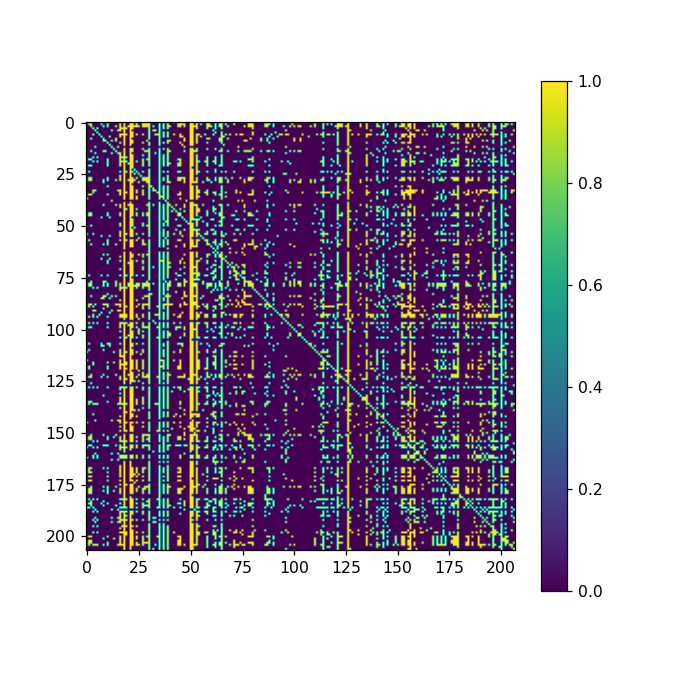

In [16]:
fig = plt.figure(figsize=[6, 6])
ax = fig.subplots(1, 1)
im = ax.imshow(mat)
plt.colorbar(im, ax=ax)
plt.show()

In [37]:
# Count the importance of each node and sort them descending
xs, ys = mat.nonzero()
node_v = np.zeros([N])
node_v[xs] += 1
node_v[ys] += 1
inds = np.argsort(node_v)[::-1]
print(len(inds))
np.sort(inds[:42])

207


array([ 51,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 206])

In [32]:
np.sqrt(900*2)

42.42640687119285

In [31]:
31 * 30 / 2

465.0

In [129]:
a = np.sort(mat.flatten())
a = np.unique(a)
ind = -1
mat_1 = mat.copy()
mat_1[mat_1 < a[ind]] = 0.0
print("Num of nonzero elements:", np.sum(mat_1>0))

Num of nonzero elements: 74226


74226

In [94]:
a = mat.flatten()
mask = a > 0
a_min = np.min(a[mask])
a_max = np.max(a[mask])
print("a_min over 0:", a_min)
print("a_max over 0:", a_max)
a[mask] = (a[mask] - a_min) / (a_max-a_min)
print(np.histogram(a, bins=10))
print(np.histogram(a[a<0.1], bins=10))


a_min over 0: 0.9900304593567619
a_max over 0: 1.0
(array([ 7114,   145,   157,   174,   211,   226,   328,   427,   713,
       96130]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([7005,    9,   14,   11,   16,   13,   12,    8,   10,   16]), array([0.        , 0.00994774, 0.01989547, 0.02984321, 0.03979094,
       0.04973868, 0.05968641, 0.06963415, 0.07958188, 0.08952962,
       0.09947735]))


In [161]:
with open(os.path.join("temp_results/effcause/pems-bay", f"raw_sim_matrix_ele5761.pkl"), "rb") as f:
    mat = pickle.load(f)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [144]:
# 生成原始的相似度矩阵，即采用 1-显著性水平作为相似度。此方法的矩阵会有很多值（98311）非常接近1.0，彼此的区别很小。
with open(os.path.join("temp_results/effcause/pems-bay", f"raw_sim_matrix_ele5761.pkl"), "wb") as f:
    pickle.dump(mat, f)

(array([32745.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0., 72880.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <BarContainer object of 10 artists>)


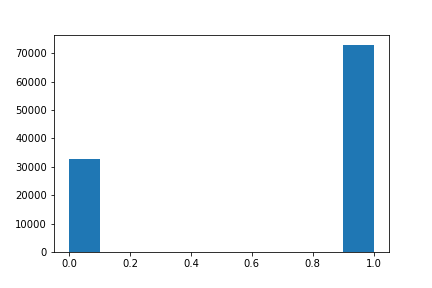

In [25]:
a = mat.flatten()
print(plt.hist(a))
plt.show()

(array([95805.,   713.,   427.,   328.,   226.,   211.,   174.,   157.,
         145.,   125.]), array([0.        , 0.00099695, 0.00199391, 0.00299086, 0.00398782,
       0.00498477, 0.00598172, 0.00697868, 0.00797563, 0.00897259,
       0.00996954]), <BarContainer object of 10 artists>)


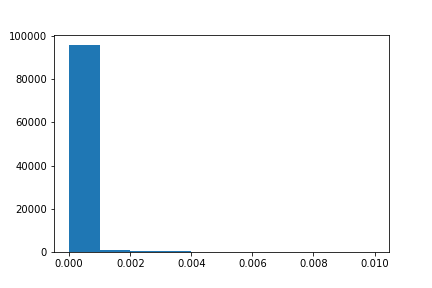

In [44]:
plt.figure()
a = mat.flatten()
print(plt.hist(a[a<0.1]))
plt.show()

0.009969540643238116
(array([95805.,   713.,   427.,   328.,   226.,   211.,   174.,   157.,
         145.,  7439.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <BarContainer object of 10 artists>)


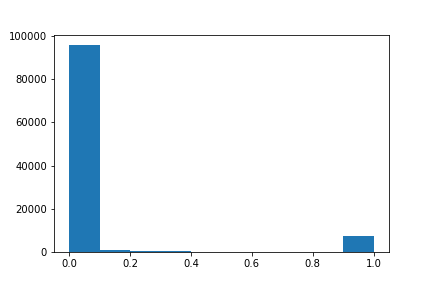

In [47]:
a = mat.flatten()
mask = a<0.1
a_max = np.max(a[mask])
print(a_max)
a[mask] = a[mask] / a_max
plt.figure()
print(plt.hist(a))
plt.show()

# 根据原始的相似度矩阵，即采用 1-显著性水平作为相似度。之后再将小于0.1的值向上缩放到0-1的范围内。
with open(os.path.join("temp_results/effcause/pems-bay", f"scaled_sim_matrix_sign{sign:.2f}.pkl"), "wb") as f:
    _ = 1.0 - a.reshape(*mat.shape)
    pickle.dump(_, f)

In [35]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data


sensor_ids, sensor_id_to_ind, adj_mx  = load_pickle("/workspace/DCRNN/"+"data/sensor_graph/adj_mx_bay.pkl")

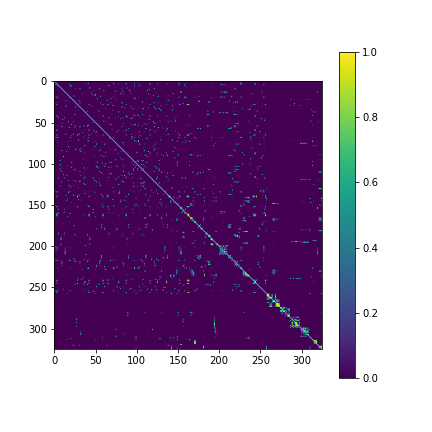

In [52]:
fig = plt.figure(figsize=[6, 6])
ax = fig.subplots(1, 1)
im = ax.imshow(adj_mx)
plt.colorbar(im, ax=ax)
plt.show()

In [100]:
hist, bin_edges = np.histogram(adj_mx.flatten(), bins=10)
print(hist, "\n", bin_edges)

[102931    433    251    205    174    193    171    196    243    828] 
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [128]:
sum(hist[1:])

2694

In [29]:
local_length = df.shape[0]
step=d["step"]
list_segment_split = get_segment_split(local_length, step)
effcause_build_intervals(len(selected_cols), d['local_results'], 1e-2, list_segment_split, verbose=False)
# build_intervals_bidirected(local_results_eff, 0.1, 600, 100, df.shape[1])
dcc_eff_new = generate_DCC(d['local_results'], local_length, len(selected_cols), interval_key="intervals")

In [30]:
dcc_eff_new["5->4"]

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

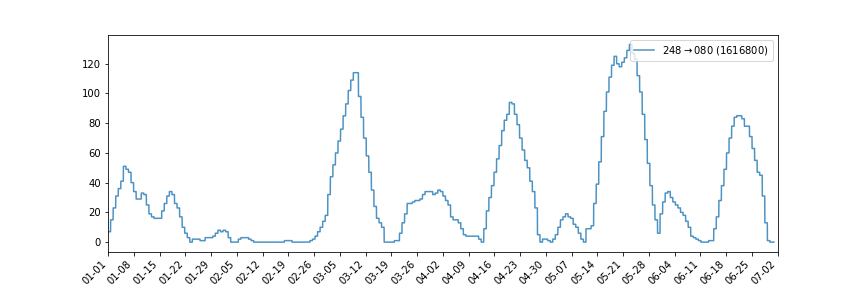

In [34]:
N = df.shape[1]

for y_i in range(len(selected_cols)):
    if selected_cols[y_i] != 80:
        continue
    fig = plt.figure(figsize=[12,4])
    fig.subplots_adjust(hspace=0.05)
    axs = fig.subplots(1, 1, sharex=True, squeeze=False)
    dcc_sums = []
    for x_i in range(len(selected_cols)):
        if x_i != y_i:
            if selected_cols[x_i] != 248:
                continue
#             print(f"{x_i}->{y_i}")
            one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]
            dcc_sums.append([np.sum(one_dcc), x_i])
    # sort by dcc sum
#     inds = sorted(dcc_sums, key=lambda x: x[0], reverse=True)
    inds = dcc_sums
    for _, x_i in inds:
        one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]
        text = r'$\mathrm{%s}\rightarrow \mathrm{%s}\;(%d)$' % (
            f"{selected_cols[x_i]:>03d}", f"{selected_cols[y_i]:>03d}", sum(one_dcc))
        axs[0,0].plot(raw_index, one_dcc, label=text, alpha=0.8)

    axs[0, 0].legend(loc='upper right')
    import matplotlib.dates as mdates
    axs[0, 0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
    axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    axs[0, 0].set_xlim(mdates.datestr2num("2017-01-01"), mdates.datestr2num("2017-07-02"))
    plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha="right")
    
    fname = os.path.join("temp_results", "plot", "pems-bay", f"selected-pairs-lag20-3-to{selected_cols[y_i]}.png")
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    plt.savefig(fname, dpi=600, bbox_inches='tight')
    plt.show()
#     break
pass

In [ ]:
from matplotlib.patches import FancyArrowPatch
locations = pd.read_csv("/workspace/DCRNN/data/sensor_graph/graph_sensor_locations_bay.csv", header=None, names=["sensor_id", "lat", "lon"])


selected_cols = [248, 122, 247, 224, 80, 93]

fig = plt.figure(figsize=[6, 5], dpi=100)
fig.subplots_adjust(top=0.95)
ax = fig.subplots(1, 1)

ax.scatter(locations["lon"][selected_cols], locations["lat"][selected_cols], color='r', alpha=0.8)
for i in selected_cols:
    ax.text(locations["lon"][i], locations["lat"][i], str(i)+":"+str(locations['sensor_id'][i]))

oth_inds = list(set(locations.index) - set(selected_cols))
locs = locations.iloc[oth_inds, :]
ax.scatter(locs["lon"], locs["lat"], alpha=0.3, c='gray')

dcc_sums = []
for y_i in range(len(selected_cols)):
    for x_i in range(len(selected_cols)):
        if x_i != y_i:
            one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]
            dcc_sums.append([np.sum(one_dcc), x_i, y_i])
arrs = []

cmap = plt.get_cmap('cool')
dcc_sum_max = np.max([i[0] for i in dcc_sums])
def norm(v):
    return v/dcc_sum_max





for dcc_sum, x_i, y_i in dcc_sums:
    start_pos = (locations["lon"][selected_cols[x_i]], locations["lat"][selected_cols[x_i]])
    end_pos = (locations["lon"][selected_cols[y_i]], locations["lat"][selected_cols[y_i]])
#     print("{s[0]:.4f},{s[1]:.4f} -> {e[0]:.4f},{e[1]:.4f} [{} -> {}]".format(
#         selected_cols[x_i], selected_cols[y_i],
#         s=start_pos, e=end_pos))
    
    arrow = FancyArrowPatch(start_pos, end_pos,
        arrowstyle='->', 
        connectionstyle="Arc3, rad=0.3",
        alpha=0.5,
        color=cmap(norm(dcc_sum)),
        linewidth=2,
#         shrinkA=0,
#         shrinkB=0,
        mutation_scale=15
    )
    ax.add_patch(arrow)
    arrs.append(arrow)
    
#     arrs.append(ax.arrow(start_pos[0], start_pos[1], end_pos[0]-start_pos[0], end_pos[1]-start_pos[1], 
#                         color=cmap(norm(dcc_sum)), 
#                         length_includes_head=True, width=1e-4))
#     break
            

ax.set_xlim(-1.22e2-0.06, -1.22e2+0.02)
ax.set_ylim(37.3935, 37.4100)
plt.show()

In [ ]:
def get_decision_values(dcc,N, agg_func=sum, self_edges=False):
    pred = []
    for i in range(len(selected_cols)):
        for j in range(len(selected_cols)):
            if i != j:
                pred.append(float(agg_func(dcc['{}->{}'.format(i, j)])))
            elif i==j and self_edges:
                # Consider self edges
                pred.append(float(agg_func(dcc['{}->{}'.format(i, j)])))
    return pred

pred = get_decision_values(dcc_eff_new, len(selected_cols))
print(pred)

thr = sorted(pred)[-5]
for i in range(len(selected_cols)):
    for j in range(len(selected_cols)):
        if i != j:
            w = float(sum(dcc_eff_new['{}->{}'.format(i, j)]))
            if w >= thr:
                print(f"Edge: {selected_cols[i]} -> {selected_cols[j]}")

In [ ]:
selected_cols

In [ ]:
np.sum(
    dcc_eff_new['{}->{}'.
            format(selected_cols.index(80), selected_cols.index(224))]
)

## OLS Traffic Prediction

Select one best fit interval and pairs to perform OLS regression. And show the prediction versus the groundtruth. If the results are good, it can be used as an evaluation.

In [36]:
from effcause_lib.granger import get_lagged_data, fit_regression_rolling
from statsmodels.regression.linear_model import OLS, WLS
from scipy import stats

lag = 20

target = [80]
feature = [248]

time_ranges = [slice("2017-02-12", "2017-02-19"), slice("2017-03-05", "2017-03-12")]

def get_ols_ssr(target, feature, data, lag):
    if feature is None:
        x = data[:, target]
    else:
        x = data[:, target+feature]
    dta, dtaown, dtajoint = get_lagged_data(x, lag, True, False)
    if feature is not None:
        res2djoint = OLS(dta[:, 0], dtajoint[:, :]).fit()
        y_hat = res2djoint.predict(dtajoint)
    #     print(y_hat.shape)
        ssr = np.sum((y_hat - dta[:, 0]) ** 2)
    #     print("SSR of Joint Model:", ssr_joint)
    else:
        res2down = OLS(dta[:, 0], dtaown[:, :]).fit()
        y_hat = res2down.predict(dtaown)
#         print(y_hat.shape)
        ssr = np.sum((y_hat - dta[:, 0]) ** 2)
    return ssr, y_hat, dta[:, 0]

y_hat_list = []
for time_range in time_ranges:
    data = raw_df[time_range].to_numpy()
    ssr, y_hat, y = get_ols_ssr(target, feature, data, lag)
    y_hat_list.append([y_hat, y])
    rmse = np.sqrt(ssr / (data.shape[0]-lag))
    print(time_range, f"ssr={ssr} rmse={rmse}")



# data = raw_df[time_range].to_numpy()
# print('-'*10, "Using", feature, "to predict", target)
# x = data[:, target+feature]
# dta, dtaown, dtajoint = get_lagged_data(x, lag, True, True)

# res2djoint = OLS(dta[:, 0], dtajoint[:, :]).fit()
# y_hat_1 = res2djoint.predict(dtajoint)
# # print(y_hat.shape)
# ssr_joint = np.sum((y_hat_1 - dta[:, 0]) ** 2)
# print("SSR of Joint Model:", ssr_joint)
# print("RMSE of Joint Model:", np.sqrt(ssr_joint/dta.shape[0]))

# res2down = OLS(dta[:, 0], dtaown[:, :]).fit()
# y_hat_2 = res2down.predict(dtaown)
# # print(y_hat.shape)
# ssr_own = np.sum((y_hat_2 - dta[:, 0]) ** 2)
# print("SSR of Own Model:", ssr_own)


# feature = [122]
# print('-'*10, "Using", feature, "to predict", target)
# x = data[:, target+feature]
# dta, dtaown, dtajoint = get_lagged_data(x, lag, True, True)
# res2djoint = OLS(dta[:, 0], dtajoint[:, :]).fit()
# y_hat = res2djoint.predict(dtajoint)
# print(y_hat.shape)
# ssr_joint = np.sum((y_hat - dta[:, 0]) ** 2)
# print("SSR of Joint Model:", ssr_joint)

# res2down = OLS(dta[:, 0], dtaown[:, :]).fit()
# y_hat = res2down.predict(dtaown)
# print(y_hat.shape)
# ssr_own = np.sum((y_hat - dta[:, 0]) ** 2)
# print("SSR of Own Model:", ssr_own)

slice('2017-02-12', '2017-02-19', None) ssr=7956.595805414603 rmse=1.866446726377609
slice('2017-03-05', '2017-03-12', None) ssr=7753.040271350612 rmse=1.8472762914348455


In [49]:
np.product(raw_df.shape)

16937700

In [ ]:
# Continuous time series prediction mode
y_hat_1_cont = []
target_v = dtajoint[0, 0:lag].reshape(-1)
for i in range(dtajoint.shape[0]):
    
    feature_v = dtajoint[i, lag:2*lag].reshape(-1)
    y_hat_1_cont.append(res2djoint.predict(np.concatenate([target_v, feature_v, [1.0]], axis=0)))
    
    target_v = np.concatenate([y_hat_1_cont[-1], target_v[:lag-1]])
# print(y_hat.shape)
ssr_joint = np.sum((y_hat_1_cont - dta[:, 0]) ** 2)
print("SSR of Joint Model:", ssr_joint)

In [ ]:
fig = plt.figure(figsize=[10, 6])
fig.subplots_adjust(hspace=0.20, top=0.9, bottom=0.1)
axs = fig.subplots(3, 1, sharex=True)
axs[0].plot(raw_df[time_range].index, raw_df[time_range].iloc[:, target], alpha=0.5,c='r')
axs[0].set_title("Ground truth")
axs[1].plot(raw_df[time_range].index[lag:], y_hat_1, alpha=0.5,c='b')
axs[1].plot(raw_df[time_range].index[lag:], y_hat_1_cont, alpha=0.5,c='m')
axs[1].set_title("Joint y_hat")
axs[1].set_ylim(30, 70)
axs[2].plot(raw_df[time_range].index[lag:], y_hat_2, alpha=0.5,c='b')
axs[2].set_title("Own y_hat")

# axs[-1].set_xlim(mdates.datestr2num("2017-03-5"), mdates.datestr2num("2017-03-12"))
# plt.savefig(os.path.join("data", "pems-bay", "alldata.png"), dpi=my_dpi*5,
#            subplot_layout='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(hspace=0.05, top=0.9, bottom=0.1)
axs = fig.subplots(2, 1, sharex=True)
axs[0].plot(df[time_range].index, df[time_range].iloc[:, target], alpha=0.5,c='r')
axs[1].plot(df[time_range].index[lag:], y_hat_1, alpha=0.5,c='b')
# axs[-1].set_xlim(mdates.datestr2num("2017-03-5"), mdates.datestr2num("2017-03-12"))
# plt.savefig(os.path.join("data", "pems-bay", "alldata.png"), dpi=my_dpi*5,
#            subplot_layout='tight')
plt.show()

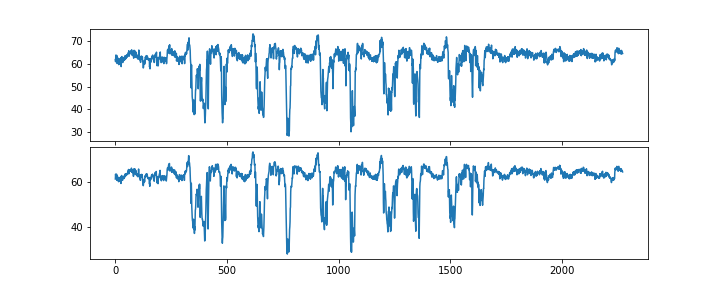

In [45]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(hspace=0.05, top=0.9, bottom=0.1)
axs = fig.subplots(2, 1, sharex=True)
axs[0].plot(y_hat_list[1][0])
axs[1].plot(y_hat_list[1][1] )

## Seasonal Pattern Mine
* Construct the subdatasets per week for selected nodes in `selected_cols`. Params: `step=200,sign=1e-2,lag=20`, Save file: `temp_results/effcause/pems-bay/exp_rets_20211005_193621.pkl`

In [ ]:
fig = plt.figure(figsize=[10, 8])
fig.subplots_adjust(hspace=0.05, top=0.9, bottom=0.1)
axs = fig.subplots(3, 1, sharex=True)
for i, col in enumerate([248, 122, 80]):
    axs[i].plot(df.index, df.iloc[:, col], label=str(col))
    axs[i].legend(loc='upper right')
axs[-1].set_xlim(mdates.datestr2num("2017-03-5"), mdates.datestr2num("2017-03-12"))
# plt.savefig(os.path.join("data", "pems-bay", "alldata.png"), dpi=my_dpi*5,
#            subplot_layout='tight')
plt.show()

In [ ]:
weekly_df

In [ ]:
weekly_df[-1].index

In [ ]:
step=100
lag=20

local_results_eff, dcc_eff, mat_eff, time_stat_dict_eff = effcause_causal_discover(
    # Data params
    weekly_df[0].to_numpy()[:, :],
    # Granger interval based graph construction params
    step=step,
    significant_thres=0.01,
    lag=lag,  # must satisfy: step > 3 * lag + 1
    adaptive_threshold=0.7,
    use_multiprocess=True,
    max_workers=3,
    reuse_invdirection=True,
    rolling_method="zyf",
    max_segment_len=None,
    adftest=False,
    # Debug_params
    verbose=True,
    runtime_debug=True,
)
print(time_stat_dict_eff['Construct-Impact-Graph-Phase'])

In [6]:
# weekly_df[0]
# with open("temp_results/dycause/pems-bay/exp_rets_20211005_041303.pkl", "rb") as f:
#     exp_rets = pickle.load(f)
with open("temp_results/effcause/pems-bay/exp_rets_20211005_041946.pkl", "rb") as f:
    exp_rets = pickle.load(f)

In [7]:
d = exp_rets[0]
print(d.keys())
local_results_eff = d["local_results"]

dict_keys(['week_id', 'step', 'sign', 'lag', 'local_results', 'dcc', 'time_stat_dict'])


In [16]:
len(local_results_eff.keys())

105300

In [12]:
d["dcc"]["0->1"].shape

(2016, 1)

In [15]:
 d['time_stat_dict']["time_total"] * len(weekly_df) / 3600

9900.39984408785

In [ ]:
N = weekly_df[0].shape[1]
step = d["step"]
local_length = weekly_df[0].shape[0]
list_segment_split = get_segment_split(local_length, step)
effcause_build_intervals(weekly_df[0].shape[1], d["local_results"], 1e-2, list_segment_split, verbose=False)
# build_intervals_bidirected(local_results_eff, 0.1, 600, 100, df.shape[1])
dcc_eff_new = generate_DCC(d["local_results"], local_length, df.shape[1], interval_key="intervals")

In [ ]:
decision_values = [float(np.sum(dcc)) for dcc in dcc_eff_new.values()]
thr = np.max(decision_values) * 0.8
significant_pairs = []
for x in range(N):
    for y in range(N):
        if x!=y:
            if float(np.sum(dcc_eff_new[f"{x}->{y}"])) >= thr:
                significant_pairs.append((x, y))

In [ ]:
significant_pairs

In [ ]:
# N = df.shape[1]
# for x_i in [248]:
#     for y_i in [224]:
fig = plt.figure(figsize=[12,4])
fig.subplots_adjust(hspace=0.05)
axs = fig.subplots(1, 1, sharex=True, squeeze=False)
for (x_i, y_i) in significant_pairs[:20]:
    if x_i != y_i:
        one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]
        text = r'$\mathrm{%s}\rightarrow \mathrm{%s}\;(%d)$' % (
            f"{df.columns[x_i]:>03d}", f"{df.columns[y_i]:>03d}", sum(one_dcc))
        axs[0,0].plot(one_dcc, label=text)
axs[0, 0].legend(loc='upper right')
# fname = os.path.join("temp_results", "plot", "timino", "selected-pairs-lag50.png")
# os.makedirs(os.path.dirname(fname), exist_ok=True)
# plt.savefig(fname, dpi=600, bbox_inches='tight')
pass

In [ ]:
# weekly_df for selected_cols
with open("temp_results/effcause/pems-bay/exp_rets_20211005_193621.pkl", "rb") as f:
    exp_rets = pickle.load(f)

In [ ]:
print(len(exp_rets))
print(exp_rets[0].keys())

In [ ]:
print(selected_cols)

In [ ]:
N = len(selected_cols)


for y_i in range(len(selected_cols)):
    fig = plt.figure(figsize=[12,4])
    fig.subplots_adjust(hspace=0.05)
    axs = fig.subplots(1, 1, sharex=True, squeeze=False)
    dcc_sums = []
    for x_i in range(len(selected_cols)):
        if x_i != y_i:
            plot_x = None
            plot_y = None
            for d in exp_rets:
                df_id = d["week_id"]
                x = weekly_df[df_id].index
                plot_x = np.concatenate([plot_x, x]) if plot_x is not None else x
            
                step = d["step"]
                local_length = weekly_df[df_id].shape[0]
                list_segment_split = get_segment_split(local_length, step)
                effcause_build_intervals(N, d["local_results"], 1e-2, list_segment_split, verbose=False)
                # build_intervals_bidirected(local_results_eff, 0.1, 600, 100, df.shape[1])
                dcc_eff_new = generate_DCC(d["local_results"], local_length, N, interval_key="intervals")

                one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]

                plot_y = np.concatenate([plot_y, one_dcc]) if plot_y is not None else one_dcc

            text = r'$\mathrm{%s}\rightarrow \mathrm{%s}\;(%d)$' % (
                f"{selected_cols[x_i]:>03d}", f"{selected_cols[y_i]:>03d}", sum(plot_y))
            axs[0,0].plot(plot_x, plot_y, label=text)
                
#                 dcc_sums.append([np.sum(one_dcc), x_i])
    # sort by dcc sum
#     inds = sorted(dcc_sums, key=lambda x: x[0], reverse=True)
#     for _, x_i in inds:
#         one_dcc = dcc_eff_new["{}->{}".format(x_i,y_i)]
#         text = r'$\mathrm{%s}\rightarrow \mathrm{%s}\;(%d)$' % (
#             f"{df.columns[selected_cols[x_i]]:>03d}", f"{df.columns[selected_cols[y_i]]:>03d}", sum(one_dcc))
#         axs[0,0].plot(one_dcc, label=text)

    axs[0, 0].legend(loc='upper right')
    
    import matplotlib.dates as mdates
    axs[0, 0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
    axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    axs[0, 0].set_xlim(mdates.datestr2num("2017-01-01"), mdates.datestr2num("2017-07-02"))
    plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha="right")
#     plt.show()
#     break
    
    fname = os.path.join("temp_results", "plot", "pems-bay", f"weekly_dcc_selected_to{selected_cols[y_i]}.png")
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    plt.savefig(fname, dpi=600, bbox_inches='tight')
pass

## Compare similarity metrics for 2 periods
We first select 2 periods that hvae different causality strengths. And compare the similarity metrics for these 2 periods, such as ParCorr, GPDC, CMIknn.

In [4]:
time_ranges = [slice("2017-02-12", "2017-02-19"), slice("2017-03-05", "2017-03-12")]

In [6]:
feature, target = 248, 80
from tigramite.independence_tests import ParCorr, GPDC, CMIknn

def get_sim_metric(raw_df, time_range, feature, target, cond_cols, metric_inst):
    if feature in cond_cols:
        cond_cols.remove(feature)
    if target in cond_cols:
        cond_cols.remove(target)
    cols = raw_df.columns
    xy_df = raw_df[time_range][[cols[feature], cols[target]]]

    z_df = raw_df[time_range][[cols[_] for _ in cond_cols]]

    
    array = np.concatenate([xy_df.to_numpy(), z_df.to_numpy()], axis=1).T
    xyz = np.ones(array.shape[0])
    xyz[0] = 0
    xyz[1] = 1 
    val = metric_inst.get_dependence_measure(array, xyz)
    return val

inst_list = [
    (ParCorr(), "ParCorr"),
    (GPDC(), "GPDC"),
    (CMIknn(), "CMIknn")
]
for time_range in time_ranges:
    for i in range(3):
        print(inst_list[i][1], ":", end='')
        print(get_sim_metric(raw_df, time_range, 248, 80, selected_cols[:], inst_list[i][0]))

ParCorr :0.21318059310313903
GPDC :0.04652300103283032
CMIknn :0.45159463478559925
ParCorr :0.39758491758952924
GPDC :0.056768042611330914
CMIknn :0.3808714619907887


In [37]:
y_hat_list

[[array([64.16022469, 62.1246712 , 61.66765723, ..., 65.30574502,
         64.02296545, 65.62203153]),
  array([62.6, 62. , 62.3, ..., 64.5, 65.4, 64.5])],
 [array([61.89048674, 60.99398717, 63.9030883 , ..., 64.7987567 ,
         64.87350082, 64.60798587]),
  array([61.4, 63.6, 62.5, ..., 65.3, 64.8, 64.6])]]

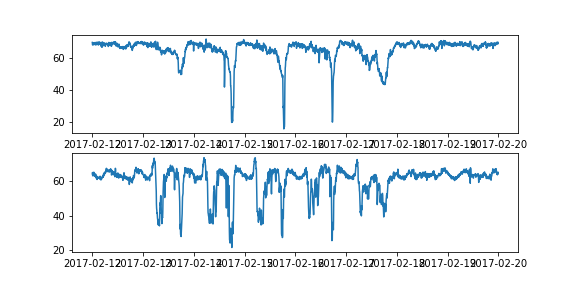

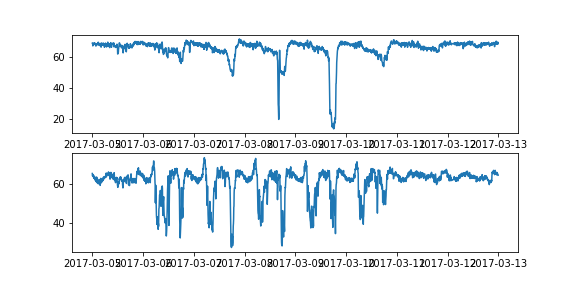

In [47]:
feature, target = 248, 80
for time_range in time_ranges:
    fig = plt.figure(figsize=[8, 4])
    axs = fig.subplots(2, 1)
    cols = raw_df.columns
    xy_df = raw_df[time_range][[cols[feature], cols[target]]]
    axs[0].plot(xy_df.index, xy_df.iloc[:, 0])
    axs[1].plot(xy_df.index, xy_df.iloc[:, 1])
    plt.show()

In [43]:
for j in range(2):
    for i in range(2):
        print(inst_list[i][1], " : ", end='')
        array = np.concatenate([y_hat_list[j][0].reshape(1,-1), y_hat_list[j][1].reshape(1, -1)], axis=0)
        xyz = [0, 1]
        val = inst_list[i][0].get_dependence_measure(array, xyz)
        print(j, val)

ParCorr  : 0 0.9753821102474662
GPDC  : 0 0.9019750489930853
ParCorr  : 1 0.9694363877329142
GPDC  : 1 0.8859958853811236


In [41]:
array.shape

(1, 4568)

In [9]:
for time_range in time_ranges:
#     for i in range(3):
#         print(inst_list[i][1], ":", end='')
    print(get_sim_metric(raw_df, time_range, 248, 80, selected_cols, CMIknn(knn=15)))

1.1655839177282628
1.037420567750856


In [ ]:
temp_df = pd.DataFrame(data, columns=list(map(str, range(data.shape[1]))))
get_part_corr(temp_df, '248', '80', list(map(str, selected_cols)))

In [ ]:
feature = [248, 122, 247, 80, 93]



ssr_list = []
for feat in feature:
    ssr_list.append(get_ols_ssr([224], [feat], data, lag=lag))

In [ ]:
print(tabulate([feature, ssr_list]))

In [ ]:
fig = plt.figure(figsize=[8, 4])
ax = fig.subplots(1, 1)
bar_hs = ssr_list + [get_ols_ssr([224], None, data, lag=lag)]
ax.bar(range(len(bar_hs)), bar_hs)
ax.set_yscale("log")
ax.set_xticks(range(len(bar_hs)))
ax.set_xticklabels(feature+["Own"])
plt.show()

In [ ]:
from effcause_lib.granger import get_lagged_data, fit_regression_rolling
from statsmodels.regression.linear_model import OLS, WLS
from scipy import stats

lag = 50
data = df.to_numpy()[:, :]
target = [224]
feature = [248]
print('-'*10, "Using", feature, "to predict", target)
x = data[:, target+feature]
dta, dtaown, dtajoint = get_lagged_data(x, lag, True, True)

w = dcc_eff_new['0->3'][50:]
w = w / np.max(w)
res2djoint = WLS(dta[:, 0], dtajoint[:, :]).fit()
y_hat = res2djoint.predict(dtajoint)
print(y_hat.shape)
ssr_joint = np.sum((y_hat - dta[:, 0]) ** 2)
print("SSR of Joint Model:", ssr_joint)

# Other figures

## Ablation

In [ ]:
plt.style.use('seaborn')

method_names = ["Basic Granger", "Dynamic Granger", "DyCause", "EffCause"]
prec_list = [4.79, 66.67, 66.67, 66.67]
recall_list = [96.32, 59.49, 59.49, 59.49]
f1_list = [9.06, 57.70, 57.70, 57.70]
l = [prec_list, recall_list, f1_list]
time_list = [16.55, 2203.87, 1437.54, 1028.46]

fig = plt.figure(figsize=[10, 6])
fig.subplots_adjust(wspace=0.1)
ax1 = fig.add_subplot(1, 4, (1, 3))
ax2 = fig.add_subplot(1, 4, (4))
ax2.get_yaxis().set_visible(False)
ax2 = ax2.twinx()

cmap = plt.get_cmap("Paired")
metric_names = ["Prec", "Rec", "F1"]
ax1.set_xticks(np.arange(3))
ax1.set_xticklabels(metric_names)
width = 0.9 / len(method_names)
edge=0.2
ax1.set_xlim(-width*2-edge, width*2+len(metric_names)-1+edge)
for i in range(len(method_names)):
    x = np.arange(3) + width * i - (len(method_names)/2.0 - 0.5) * width
    ax1.bar(x, [_[i] for _ in l], width=width, color=cmap(i/len(method_names)), label=method_names[i])
ax1.legend(loc='upper right', fontsize='large')

ax2.set_xticks([0])
ax2.set_xticklabels(["Time (s)"])
width = 0.9 / len(method_names)
ax2.set_xlim(-width*2-edge, width*2+edge)
for i in range(len(method_names)):
    x = 0 + width * i - (len(method_names)/2.0 - 0.5) * width
    ax2.bar(x, time_list[i], width=width, color=cmap(i/len(method_names)))
plt.savefig(os.path.join("temp_results/plot", "ablation.png"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join("temp_results/plot", "ablation.pdf"), dpi=600, bbox_inches='tight')